# Neural Network - Advanced Model Training
## Forest Cover Type Dataset

This notebook trains a deep neural network with advanced architecture and optimization techniques.

### Model Architecture:
- **Wide & Deep MLP** with 4 hidden layers [1024, 512, 512, 256]
- **Swish activation** (Google's self-gated activation)
- **Batch Normalization** for stable training
- **Dropout** for regularization
- **Embedding layers** for categorical features

### Optimization:
- **AdamW optimizer**
- **Mixed precision training** (FP16) for speed
- **Learning rate scheduling**
- **Early stopping**
- **GPU acceleration** with XLA JIT compilation

**Target:** 95%+ accuracy

## 1. Import Required Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
import os

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully")

TensorFlow version: 2.16.0-rc0
Libraries imported successfully


## 2. Configuration

In [2]:
print("=" * 80)
print("NEURAL NETWORK TRAINING (95% TARGET)")
print("=" * 80)

NEURAL NETWORK TRAINING (95% TARGET)


## 3. GPU Configuration

Optimize GPU settings for maximum performance.

In [3]:
print("\n[GPU SETUP]")
gpus = tf.config.list_physical_devices('GPU')
print(f"Physical GPUs detected: {len(gpus)}")

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"  ✓ Using GPU: {gpus[0]}")
        
        from tensorflow.keras import mixed_precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("  ✓ Mixed Precision Enabled (FP16)")
        print("    - Faster training on NVIDIA Tensor Cores")
        print("    - Reduced memory usage")
        
    except RuntimeError as e:
        print(f"  ⚠ GPU setup error: {e}")
else:
    print("  ⚠ NO GPU DETECTED!")
    print("  Training will be slow on CPU.")
    print("  Consider using Google Colab or installing CUDA/cuDNN.")

tf.config.optimizer.set_jit(True)
print("  ✓ XLA JIT Compilation Enabled")


[GPU SETUP]
Physical GPUs detected: 0
  ⚠ NO GPU DETECTED!
  Training will be slow on CPU.
  Consider using Google Colab or installing CUDA/cuDNN.
  ✓ XLA JIT Compilation Enabled


## 4. Load Processed Data

In [4]:
print("\nLoading processed data...")

base_dir = os.path.abspath('../..')
data_path = os.path.join(base_dir, 'data_95_v2', 'advanced_data_v2.npz')

if not os.path.exists(data_path):
    print(f"Error: {data_path} not found!")
    raise FileNotFoundError("Please run the preprocessing notebook first.")

data = np.load(data_path)
X_cont_train = data['X_cont_train']
X_cont_test = data['X_cont_test']
X_wild_train = data['X_wild_train']
X_wild_test = data['X_wild_test']
X_soil_train = data['X_soil_train']
X_soil_test = data['X_soil_test']
y_train_cat = data['y_train_cat']
y_test_cat = data['y_test_cat']

print(f"✓ Data loaded successfully")
print(f"  - Continuous features: {X_cont_train.shape[1]}")
print(f"  - Training samples: {X_cont_train.shape[0]:,}")
print(f"  - Test samples: {X_cont_test.shape[0]:,}")
print(f"  - Classes: {y_train_cat.shape[1]}")


Loading processed data...


✓ Data loaded successfully
  - Continuous features: 32
  - Training samples: 493,860
  - Test samples: 87,152
  - Classes: 7


## 5. Model Architecture

Define the Wide & Deep neural network with embedding layers.

In [5]:
def create_model():
    """
    Create a Wide & Deep MLP with embeddings for categorical features.
    
    Architecture:
    - Embedding layers for Wilderness Area (4 categories) and Soil Type (40 categories)
    - Deep network for continuous features
    - Concatenation of embeddings and deep features
    - Multiple dense layers with BatchNorm and Dropout
    """
    
    input_cont = layers.Input(shape=(X_cont_train.shape[1],), name='continuous_input')
    input_wild = layers.Input(shape=(1,), name='wilderness_input')
    input_soil = layers.Input(shape=(1,), name='soil_input')
    
    emb_wild = layers.Embedding(
        input_dim=4,
        output_dim=4,
        name='wilderness_embedding'
    )(input_wild)
    emb_wild = layers.Flatten()(emb_wild)
    
    emb_soil = layers.Embedding(
        input_dim=40,
        output_dim=16,
        name='soil_embedding'
    )(input_soil)
    emb_soil = layers.Flatten()(emb_soil)
    
    x = layers.Dense(1024, activation='swish', name='continuous_dense')(input_cont)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    merged = layers.Concatenate(name='merge_features')([x, emb_wild, emb_soil])
    x = merged
    
    x = layers.Dense(1024, activation='swish', name='deep_block_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(512, activation='swish', name='deep_block_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256, activation='swish', name='deep_block_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(7, name='output_logits')(x)
    output = layers.Activation('softmax', dtype='float32', name='output')(x)
    
    model = models.Model(
        inputs=[input_cont, input_wild, input_soil], 
        outputs=output,
        name='WideDeepMLP'
    )
    
    return model

## 6. Create and Compile Model

In [6]:
print("\nCreating model...")
model = create_model()

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model created and compiled")
print("\nModel Summary:")
model.summary()


Creating model...
✓ Model created and compiled

Model Summary:


Model: "WideDeepMLP"

┏━━━━┳━━━━┳━━┳━━━━┓
┃ L… ┃ O… ┃  ┃ C… ┃
┃ (… ┃ S… ┃  ┃ to ┃
┡━━━━╇━━━━╇━━╇━━━━┩
│ c… │ (… │  │ -  │
│ (… │ 3… │  │    │
├────┼────┼──┼────┤
│ c… │ (… │  │ c… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ w… │ (… │  │ -  │
│ (… │ 1) │  │    │
├────┼────┼──┼────┤
│ s… │ (… │  │ -  │
│ (… │ 1) │  │    │
├────┼────┼──┼────┤
│ b… │ (… │  │ c… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ w… │ (… │  │ w… │
│ (… │ 1, │  │    │
│    │ 4) │  │    │
├────┼────┼──┼────┤
│ s… │ (… │  │ s… │
│ (… │ 1, │  │    │
│    │ 1… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ b… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ f… │ (… │  │ w… │
│ (… │ 4) │  │    │
├────┼────┼──┼────┤
│ f… │ (… │  │ s… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ m… │ (… │  │ d… │
│ (… │ 1… │  │ f… │
│    │    │  │ f… │
├────┼────┼──┼────┤
│ d… │ (… │  │ m… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ b… │ (… │  │ d… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ b… │
│ (… │ 1… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ d… │
│ (… │ 5… │  │    │
├────┼────┼──┼────┤
│ b… │ (… │  │ d… │
│ (… │ 5… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ b… │
│ (… │ 5… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ d… │
│ (… │ 2… │  │    │
├────┼────┼──┼────┤
│ b… │ (… │  │ d… │
│ (… │ 2… │  │    │
├────┼────┼──┼────┤
│ d… │ (… │  │ b… │
│ (… │ 2… │  │    │
├────┼────┼──┼────┤
│ o… │ (… │  │ d… │
│ (… │ 7) │  │    │
├────┼────┼──┼────┤
│ o… │ (… │  │ o… │
│ (… │ 7) │  │    │
└────┴────┴──┴────┘

 Total params: 1,773,719 (6.77 MB)

 Trainable params: 1,768,087 (6.74 MB)

 Non-trainable params: 5,632 (22.00 KB)

## 7. Training Callbacks

Configure callbacks for monitoring and optimization during training.

In [7]:
print("\nConfiguring callbacks...")

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    ),
    
    callbacks.ModelCheckpoint(
        os.path.join(base_dir, 'best_95_v2_model.weights.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - EarlyStopping (patience=15)")
print("  - ReduceLROnPlateau (factor=0.5, patience=5)")
print("  - ModelCheckpoint (save best weights)")


Configuring callbacks...
✓ Callbacks configured:
  - EarlyStopping (patience=15)
  - ReduceLROnPlateau (factor=0.5, patience=5)
  - ModelCheckpoint (save best weights)


## 8. Train Model

In [8]:
print("\n" + "=" * 80)
print("STARTING TRAINING")
print("=" * 80)

history = model.fit(
    [X_cont_train, X_wild_train, X_soil_train],
    y_train_cat,
    validation_split=0.1,
    epochs=100,
    batch_size=1024,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✓ Training complete!")


STARTING TRAINING
Epoch 1/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 17:26 2s/step - accuracy: 0.1680 - loss: 2.7494

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.2808 - loss: 2.4819

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3408 - loss: 2.3146

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3810 - loss: 2.1885

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4108 - loss: 2.0910

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4341 - loss: 2.0101

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4523 - loss: 1.9453

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4674 - loss: 1.8903

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4804 - loss: 1.8423

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4918 - loss: 1.7999

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.5019 - loss: 1.7620

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5065 - loss: 1.7445

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5107 - loss: 1.7279

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5185 - loss: 1.6967

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5255 - loss: 1.6683

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5318 - loss: 1.6424

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5376 - loss: 1.6188

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.5428 - loss: 1.5971

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5477 - loss: 1.5769

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5521 - loss: 1.5579

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5562 - loss: 1.5401

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5600 - loss: 1.5232

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5635 - loss: 1.5072

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5652 - loss: 1.4995

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5669 - loss: 1.4920

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5700 - loss: 1.4776

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5730 - loss: 1.4638

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5758 - loss: 1.4507

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5785 - loss: 1.4383

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5811 - loss: 1.4264

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5835 - loss: 1.4149

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.5858 - loss: 1.4040

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5879 - loss: 1.3936

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5900 - loss: 1.3836

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5919 - loss: 1.3739

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5938 - loss: 1.3646

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5956 - loss: 1.3556

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5973 - loss: 1.3469

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5990 - loss: 1.3386

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6006 - loss: 1.3305

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6022 - loss: 1.3227

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6037 - loss: 1.3151

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6051 - loss: 1.3077

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6065 - loss: 1.3006

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6079 - loss: 1.2936

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6092 - loss: 1.2869

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6105 - loss: 1.2803

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6117 - loss: 1.2739

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6129 - loss: 1.2677

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6141 - loss: 1.2616

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6152 - loss: 1.2557

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6163 - loss: 1.2500

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6174 - loss: 1.2444

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6184 - loss: 1.2390

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6194 - loss: 1.2336

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6204 - loss: 1.2284

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6214 - loss: 1.2234

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6223 - loss: 1.2184

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6233 - loss: 1.2135

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6242 - loss: 1.2087

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6251 - loss: 1.2040

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6259 - loss: 1.1995

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6268 - loss: 1.1950

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6276 - loss: 1.1906

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6284 - loss: 1.1863

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6292 - loss: 1.1821

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6300 - loss: 1.1779

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6308 - loss: 1.1738

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6315 - loss: 1.1699

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6323 - loss: 1.1659

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6330 - loss: 1.1621

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6338 - loss: 1.1583

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.6345 - loss: 1.1545

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6352 - loss: 1.1509

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6359 - loss: 1.1473

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6365 - loss: 1.1437

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6372 - loss: 1.1403

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6379 - loss: 1.1368

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6385 - loss: 1.1335

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6391 - loss: 1.1302

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6397 - loss: 1.1269

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6404 - loss: 1.1237

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6410 - loss: 1.1206

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.6415 - loss: 1.1175

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6421 - loss: 1.1144

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6427 - loss: 1.1114

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6433 - loss: 1.1085

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6438 - loss: 1.1055

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6444 - loss: 1.1027

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6449 - loss: 1.0998

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6454 - loss: 1.0970

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6460 - loss: 1.0943

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6465 - loss: 1.0916

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6470 - loss: 1.0889

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.6475 - loss: 1.0862

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6480 - loss: 1.0836

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6485 - loss: 1.0811

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6489 - loss: 1.0785

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6494 - loss: 1.0760

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6499 - loss: 1.0735

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6503 - loss: 1.0711

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6508 - loss: 1.0687

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6513 - loss: 1.0663

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6517 - loss: 1.0640

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6521 - loss: 1.0616

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6526 - loss: 1.0593

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6530 - loss: 1.0571 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6534 - loss: 1.0548

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6538 - loss: 1.0526

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6543 - loss: 1.0504

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6547 - loss: 1.0483

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6551 - loss: 1.0461

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6555 - loss: 1.0440

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6559 - loss: 1.0419

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6563 - loss: 1.0399

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6567 - loss: 1.0378

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6570 - loss: 1.0358

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6574 - loss: 1.0338

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6578 - loss: 1.0318

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6582 - loss: 1.0299

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6585 - loss: 1.0279

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6589 - loss: 1.0260

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6593 - loss: 1.0241

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6596 - loss: 1.0223

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6600 - loss: 1.0204

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6603 - loss: 1.0186

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6607 - loss: 1.0168

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6610 - loss: 1.0150

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6614 - loss: 1.0132

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6617 - loss: 1.0115

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6620 - loss: 1.0097

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6624 - loss: 1.0080

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6627 - loss: 1.0063

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6630 - loss: 1.0046

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6633 - loss: 1.0029

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6637 - loss: 1.0013

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6640 - loss: 0.9996

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6643 - loss: 0.9980

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6646 - loss: 0.9964

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6649 - loss: 0.9948

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6652 - loss: 0.9932

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6655 - loss: 0.9917

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6658 - loss: 0.9901

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6661 - loss: 0.9886

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6664 - loss: 0.9871

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6667 - loss: 0.9856

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6670 - loss: 0.9841

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6673 - loss: 0.9826

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6676 - loss: 0.9811

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6678 - loss: 0.9797

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.6681 - loss: 0.9782

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6684 - loss: 0.9768

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6687 - loss: 0.9754

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6689 - loss: 0.9740

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6692 - loss: 0.9726

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6695 - loss: 0.9712

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6698 - loss: 0.9698

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6700 - loss: 0.9684

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6703 - loss: 0.9671

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6705 - loss: 0.9658

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6708 - loss: 0.9644

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6711 - loss: 0.9631

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6713 - loss: 0.9618

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6716 - loss: 0.9605

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6718 - loss: 0.9592

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6721 - loss: 0.9579

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6723 - loss: 0.9566

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6726 - loss: 0.9554

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6728 - loss: 0.9541

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6731 - loss: 0.9529

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6733 - loss: 0.9516

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6736 - loss: 0.9504

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6738 - loss: 0.9492

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6740 - loss: 0.9480

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6743 - loss: 0.9468

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6745 - loss: 0.9456

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6747 - loss: 0.9444

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6750 - loss: 0.9433

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6752 - loss: 0.9421

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6754 - loss: 0.9409

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6757 - loss: 0.9398

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6759 - loss: 0.9386

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6761 - loss: 0.9375

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6764 - loss: 0.9364

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6766 - loss: 0.9353

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6768 - loss: 0.9341

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6770 - loss: 0.9330

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6772 - loss: 0.9320

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6775 - loss: 0.9309

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6777 - loss: 0.9298

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6779 - loss: 0.9287

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6781 - loss: 0.9276

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6782 - loss: 0.9271

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6783 - loss: 0.9266

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6785 - loss: 0.9255

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6788 - loss: 0.9245

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6790 - loss: 0.9234

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6792 - loss: 0.9224

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6794 - loss: 0.9214

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6796 - loss: 0.9204

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6798 - loss: 0.9194

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6800 - loss: 0.9183

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6802 - loss: 0.9173

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6804 - loss: 0.9164

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6806 - loss: 0.9154

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6808 - loss: 0.9144

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6810 - loss: 0.9134

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6812 - loss: 0.9124

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6814 - loss: 0.9115

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6816 - loss: 0.9105

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6818 - loss: 0.9096

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6820 - loss: 0.9086

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6822 - loss: 0.9077

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6824 - loss: 0.9067

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6826 - loss: 0.9058

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6827 - loss: 0.9049

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6829 - loss: 0.9040

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6831 - loss: 0.9031

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6833 - loss: 0.9021

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6835 - loss: 0.9012

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6837 - loss: 0.9003


Epoch 1: val_accuracy improved from -inf to 0.71168, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.6838 - loss: 0.8999 - val_accuracy: 0.7117 - val_loss: 0.6484 - learning_rate: 0.0010


Epoch 2/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.7812 - loss: 0.5466

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7720 - loss: 0.5594

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.7647 - loss: 0.5713

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.7611 - loss: 0.5767

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7600 - loss: 0.5774

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7594 - loss: 0.5764

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7588 - loss: 0.5758

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7583 - loss: 0.5759

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7578 - loss: 0.5761

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7573 - loss: 0.5764

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7567 - loss: 0.5768

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7564 - loss: 0.5772

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7561 - loss: 0.5774

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7558 - loss: 0.5777

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7555 - loss: 0.5779

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7554 - loss: 0.5778

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7553 - loss: 0.5777

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7552 - loss: 0.5775

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7552 - loss: 0.5773

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7552 - loss: 0.5772

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7552 - loss: 0.5770

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7553 - loss: 0.5768

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7553 - loss: 0.5766

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7553 - loss: 0.5764

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7553 - loss: 0.5762

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7553 - loss: 0.5761

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7554 - loss: 0.5759

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7555 - loss: 0.5757

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7555 - loss: 0.5755

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7556 - loss: 0.5753

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7556 - loss: 0.5751

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7557 - loss: 0.5749

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7558 - loss: 0.5746

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7558 - loss: 0.5744

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7559 - loss: 0.5741

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7560 - loss: 0.5738

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7560 - loss: 0.5736

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7561 - loss: 0.5733

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7562 - loss: 0.5730

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7563 - loss: 0.5727

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7564 - loss: 0.5725

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7565 - loss: 0.5722

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7566 - loss: 0.5719

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7566 - loss: 0.5717

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7567 - loss: 0.5714

 91/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7568 - loss: 0.5712

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7569 - loss: 0.5710

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7570 - loss: 0.5707

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7571 - loss: 0.5705

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7572 - loss: 0.5702

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7573 - loss: 0.5700

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7574 - loss: 0.5697

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7575 - loss: 0.5695

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7576 - loss: 0.5692

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7577 - loss: 0.5690

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7578 - loss: 0.5688

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7578 - loss: 0.5685

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7579 - loss: 0.5683

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7580 - loss: 0.5681

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7581 - loss: 0.5679

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7582 - loss: 0.5676

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7583 - loss: 0.5674

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7584 - loss: 0.5672

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7585 - loss: 0.5670

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7585 - loss: 0.5667

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7586 - loss: 0.5665

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7587 - loss: 0.5663

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7588 - loss: 0.5661

137/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7589 - loss: 0.5659

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7589 - loss: 0.5657

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7590 - loss: 0.5655

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7591 - loss: 0.5653

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7592 - loss: 0.5651

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7593 - loss: 0.5649

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7593 - loss: 0.5648

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7594 - loss: 0.5646

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7595 - loss: 0.5644

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7596 - loss: 0.5642

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7596 - loss: 0.5640

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7597 - loss: 0.5638

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7598 - loss: 0.5636

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7599 - loss: 0.5634

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7600 - loss: 0.5632

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7600 - loss: 0.5631

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7601 - loss: 0.5629

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7602 - loss: 0.5627

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7603 - loss: 0.5625

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7604 - loss: 0.5623

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7605 - loss: 0.5621

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7605 - loss: 0.5619

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7606 - loss: 0.5618

183/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7607 - loss: 0.5616

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7608 - loss: 0.5614

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7609 - loss: 0.5612

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7609 - loss: 0.5610

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7610 - loss: 0.5608

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7611 - loss: 0.5607

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7612 - loss: 0.5605

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7613 - loss: 0.5603

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7613 - loss: 0.5601

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7614 - loss: 0.5599

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7615 - loss: 0.5598

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7616 - loss: 0.5596

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7616 - loss: 0.5594 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7617 - loss: 0.5592

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7618 - loss: 0.5591

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7619 - loss: 0.5589

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7619 - loss: 0.5587

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7620 - loss: 0.5586

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7621 - loss: 0.5584

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7621 - loss: 0.5582

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7622 - loss: 0.5581

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7623 - loss: 0.5579

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7624 - loss: 0.5577

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7624 - loss: 0.5576

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7625 - loss: 0.5574

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7626 - loss: 0.5573

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7626 - loss: 0.5571

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7627 - loss: 0.5569

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7628 - loss: 0.5568

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7628 - loss: 0.5566

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7629 - loss: 0.5565

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7630 - loss: 0.5563

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7630 - loss: 0.5562

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7631 - loss: 0.5560

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7632 - loss: 0.5559

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7632 - loss: 0.5557

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7633 - loss: 0.5556

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7634 - loss: 0.5554

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7634 - loss: 0.5553

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7635 - loss: 0.5551

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7636 - loss: 0.5550

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7636 - loss: 0.5548

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7637 - loss: 0.5547

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7638 - loss: 0.5545

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7638 - loss: 0.5544

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7639 - loss: 0.5542

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7640 - loss: 0.5541

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7640 - loss: 0.5540

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7641 - loss: 0.5538

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7641 - loss: 0.5537

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7642 - loss: 0.5535

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7643 - loss: 0.5534

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7643 - loss: 0.5533

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7643 - loss: 0.5533

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7644 - loss: 0.5532

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7644 - loss: 0.5530

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7645 - loss: 0.5529

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7645 - loss: 0.5528

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7646 - loss: 0.5526

298/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7647 - loss: 0.5525

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7647 - loss: 0.5524

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7648 - loss: 0.5522

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7648 - loss: 0.5521

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7649 - loss: 0.5520

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7649 - loss: 0.5518

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7650 - loss: 0.5517

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7651 - loss: 0.5516

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7651 - loss: 0.5515

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7652 - loss: 0.5513

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7652 - loss: 0.5512

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7653 - loss: 0.5511

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7653 - loss: 0.5509

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7654 - loss: 0.5508

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7655 - loss: 0.5507

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7655 - loss: 0.5505

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7656 - loss: 0.5504

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7656 - loss: 0.5503

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7657 - loss: 0.5502

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7657 - loss: 0.5500

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7658 - loss: 0.5499

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7659 - loss: 0.5498

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7659 - loss: 0.5496

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7660 - loss: 0.5495

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7660 - loss: 0.5494

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7661 - loss: 0.5493

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7661 - loss: 0.5491

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7662 - loss: 0.5490

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7662 - loss: 0.5489

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7663 - loss: 0.5488

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7663 - loss: 0.5486

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7664 - loss: 0.5485

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7665 - loss: 0.5484

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7665 - loss: 0.5483

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7666 - loss: 0.5481

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7666 - loss: 0.5480

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7667 - loss: 0.5479

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7667 - loss: 0.5478

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7668 - loss: 0.5476

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7668 - loss: 0.5475

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7669 - loss: 0.5474

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7669 - loss: 0.5473

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7670 - loss: 0.5472

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7670 - loss: 0.5470

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7671 - loss: 0.5469

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7671 - loss: 0.5468

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7672 - loss: 0.5467

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7672 - loss: 0.5466

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7673 - loss: 0.5464

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7674 - loss: 0.5463

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7674 - loss: 0.5462

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7675 - loss: 0.5461

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7675 - loss: 0.5460

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7676 - loss: 0.5458

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7676 - loss: 0.5457

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7677 - loss: 0.5456

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7677 - loss: 0.5455

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7678 - loss: 0.5454

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7678 - loss: 0.5453

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7679 - loss: 0.5451

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7679 - loss: 0.5450

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7680 - loss: 0.5449

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7680 - loss: 0.5448

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7681 - loss: 0.5447

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7681 - loss: 0.5446

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7682 - loss: 0.5445

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7682 - loss: 0.5443

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7683 - loss: 0.5442

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7683 - loss: 0.5441


Epoch 2: val_accuracy improved from 0.71168 to 0.81709, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7684 - loss: 0.5440 - val_accuracy: 0.8171 - val_loss: 0.4294 - learning_rate: 0.0010


Epoch 3/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.8057 - loss: 0.4512

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8007 - loss: 0.4692

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.7978 - loss: 0.4762

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.7966 - loss: 0.4807

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7954 - loss: 0.4841

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7947 - loss: 0.4863

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7938 - loss: 0.4882

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7931 - loss: 0.4897

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7924 - loss: 0.4909

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7919 - loss: 0.4920

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7916 - loss: 0.4926

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7914 - loss: 0.4928

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7913 - loss: 0.4928

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7912 - loss: 0.4929

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7911 - loss: 0.4928

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7911 - loss: 0.4927

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7911 - loss: 0.4925

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7911 - loss: 0.4923

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7912 - loss: 0.4921

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7912 - loss: 0.4919

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7913 - loss: 0.4917

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7913 - loss: 0.4916

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7913 - loss: 0.4914

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.7913 - loss: 0.4913

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7913 - loss: 0.4912

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7914 - loss: 0.4911

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7914 - loss: 0.4910

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7914 - loss: 0.4909

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7914 - loss: 0.4908

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7915 - loss: 0.4907

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7915 - loss: 0.4906

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7916 - loss: 0.4904

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7916 - loss: 0.4903

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7917 - loss: 0.4901

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7918 - loss: 0.4900

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7918 - loss: 0.4899

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7919 - loss: 0.4897

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7919 - loss: 0.4896

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7920 - loss: 0.4894

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7921 - loss: 0.4893

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7921 - loss: 0.4891

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7922 - loss: 0.4889

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7922 - loss: 0.4888

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7923 - loss: 0.4886

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7924 - loss: 0.4884

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7925 - loss: 0.4883

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7925 - loss: 0.4881

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7926 - loss: 0.4880

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7927 - loss: 0.4878

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7927 - loss: 0.4877

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7928 - loss: 0.4875

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7928 - loss: 0.4874

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7929 - loss: 0.4872

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7930 - loss: 0.4871

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7930 - loss: 0.4870

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7931 - loss: 0.4868

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7931 - loss: 0.4867

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.7932 - loss: 0.4866

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7933 - loss: 0.4865

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7933 - loss: 0.4863

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7934 - loss: 0.4862

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7934 - loss: 0.4861

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7935 - loss: 0.4860

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7936 - loss: 0.4859

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7936 - loss: 0.4858

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7937 - loss: 0.4856

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7937 - loss: 0.4855

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7937 - loss: 0.4855

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7938 - loss: 0.4854

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7938 - loss: 0.4853

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7939 - loss: 0.4852

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7939 - loss: 0.4851

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7940 - loss: 0.4850

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7940 - loss: 0.4849

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7941 - loss: 0.4848

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7941 - loss: 0.4847

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7942 - loss: 0.4846

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7942 - loss: 0.4845

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7943 - loss: 0.4844

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7943 - loss: 0.4843

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7944 - loss: 0.4842

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7944 - loss: 0.4841

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7944 - loss: 0.4840

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7945 - loss: 0.4840

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.7945 - loss: 0.4839

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7945 - loss: 0.4839

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7946 - loss: 0.4838

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7946 - loss: 0.4837

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7946 - loss: 0.4836

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7947 - loss: 0.4835

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7947 - loss: 0.4834

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7948 - loss: 0.4833

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7948 - loss: 0.4833

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7948 - loss: 0.4832

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7949 - loss: 0.4831

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7949 - loss: 0.4830

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7950 - loss: 0.4829

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7950 - loss: 0.4828

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7951 - loss: 0.4827

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7951 - loss: 0.4827

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7951 - loss: 0.4826

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7952 - loss: 0.4825

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7952 - loss: 0.4824

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7953 - loss: 0.4823

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7953 - loss: 0.4822

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7954 - loss: 0.4821

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7954 - loss: 0.4820

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7954 - loss: 0.4820 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7955 - loss: 0.4819

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7955 - loss: 0.4818

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7956 - loss: 0.4817

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7956 - loss: 0.4816

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7956 - loss: 0.4815

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7957 - loss: 0.4815

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7957 - loss: 0.4814

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7958 - loss: 0.4813

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7958 - loss: 0.4812

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7958 - loss: 0.4811

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7959 - loss: 0.4810

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7959 - loss: 0.4809

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7960 - loss: 0.4808

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7960 - loss: 0.4808

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7961 - loss: 0.4807

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7961 - loss: 0.4806

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7961 - loss: 0.4805

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7962 - loss: 0.4804

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7962 - loss: 0.4803

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7963 - loss: 0.4802

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7963 - loss: 0.4802

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7963 - loss: 0.4801

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7964 - loss: 0.4800

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7964 - loss: 0.4799

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7965 - loss: 0.4798

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7965 - loss: 0.4797

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7965 - loss: 0.4797

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7966 - loss: 0.4796

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7966 - loss: 0.4795

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7967 - loss: 0.4794

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7967 - loss: 0.4794

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7967 - loss: 0.4793

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7968 - loss: 0.4792

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7968 - loss: 0.4791

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7968 - loss: 0.4790

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7969 - loss: 0.4790

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7969 - loss: 0.4789

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7969 - loss: 0.4788

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7970 - loss: 0.4787

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7970 - loss: 0.4787

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7971 - loss: 0.4786

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7971 - loss: 0.4785

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7971 - loss: 0.4784

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.7972 - loss: 0.4783

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7972 - loss: 0.4783

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7972 - loss: 0.4782

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7973 - loss: 0.4781

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7973 - loss: 0.4780

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7973 - loss: 0.4780

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7974 - loss: 0.4779

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7974 - loss: 0.4778

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7974 - loss: 0.4777

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7975 - loss: 0.4777

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7975 - loss: 0.4776

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7975 - loss: 0.4775

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7976 - loss: 0.4774

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7976 - loss: 0.4774

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7976 - loss: 0.4773

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7977 - loss: 0.4772

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7977 - loss: 0.4771

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7977 - loss: 0.4771

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7978 - loss: 0.4770

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7978 - loss: 0.4769

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7978 - loss: 0.4768

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7979 - loss: 0.4768

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7979 - loss: 0.4767

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7979 - loss: 0.4766

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7980 - loss: 0.4766

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7980 - loss: 0.4765

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7980 - loss: 0.4764

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7981 - loss: 0.4763

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7981 - loss: 0.4763

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7981 - loss: 0.4762

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7982 - loss: 0.4761

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7982 - loss: 0.4761

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7982 - loss: 0.4760

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7983 - loss: 0.4759

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7983 - loss: 0.4758

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7983 - loss: 0.4758

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7984 - loss: 0.4757

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7984 - loss: 0.4756

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7984 - loss: 0.4756

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7985 - loss: 0.4755

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7985 - loss: 0.4754

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7985 - loss: 0.4754

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7985 - loss: 0.4753

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7986 - loss: 0.4752

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7986 - loss: 0.4752

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7986 - loss: 0.4751

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7987 - loss: 0.4750

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7987 - loss: 0.4750

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7987 - loss: 0.4749

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7988 - loss: 0.4748

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7988 - loss: 0.4748

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7988 - loss: 0.4747

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7988 - loss: 0.4746

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7989 - loss: 0.4746

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7989 - loss: 0.4745

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7989 - loss: 0.4744

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7990 - loss: 0.4744

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7990 - loss: 0.4743

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7990 - loss: 0.4742

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7990 - loss: 0.4742

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7991 - loss: 0.4741

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7991 - loss: 0.4740

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7991 - loss: 0.4740

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7991 - loss: 0.4739

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7992 - loss: 0.4738

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7992 - loss: 0.4738

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7992 - loss: 0.4737

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7993 - loss: 0.4737

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7993 - loss: 0.4736


Epoch 3: val_accuracy improved from 0.81709 to 0.83538, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7993 - loss: 0.4735 - val_accuracy: 0.8354 - val_loss: 0.3921 - learning_rate: 0.0010


Epoch 4/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.8037 - loss: 0.4797

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8101 - loss: 0.4630

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8077 - loss: 0.4663

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8065 - loss: 0.4679

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8057 - loss: 0.4688

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8046 - loss: 0.4697

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8037 - loss: 0.4705

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8032 - loss: 0.4709

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8029 - loss: 0.4708

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8027 - loss: 0.4708

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8026 - loss: 0.4708

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8025 - loss: 0.4705

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8026 - loss: 0.4701

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8026 - loss: 0.4698

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8027 - loss: 0.4695

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8028 - loss: 0.4692

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8029 - loss: 0.4689

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8030 - loss: 0.4685

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8030 - loss: 0.4681

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.8031 - loss: 0.4679

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8031 - loss: 0.4676

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8032 - loss: 0.4673

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8032 - loss: 0.4670

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8033 - loss: 0.4667

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8033 - loss: 0.4664

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8034 - loss: 0.4662

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8035 - loss: 0.4659

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8036 - loss: 0.4656

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8037 - loss: 0.4653

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8038 - loss: 0.4651

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8038 - loss: 0.4648

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8039 - loss: 0.4645

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8040 - loss: 0.4642

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8041 - loss: 0.4639

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8042 - loss: 0.4637

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8043 - loss: 0.4634

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8045 - loss: 0.4631

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8046 - loss: 0.4628

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8047 - loss: 0.4625

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8048 - loss: 0.4623

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8048 - loss: 0.4622

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8049 - loss: 0.4621

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8049 - loss: 0.4619

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8051 - loss: 0.4617

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8051 - loss: 0.4615

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8052 - loss: 0.4612

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8053 - loss: 0.4610

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8054 - loss: 0.4607

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8055 - loss: 0.4604

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8056 - loss: 0.4602

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8057 - loss: 0.4599

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8058 - loss: 0.4597

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8059 - loss: 0.4594

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8060 - loss: 0.4592

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8061 - loss: 0.4589

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8062 - loss: 0.4587

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8063 - loss: 0.4585

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8064 - loss: 0.4582

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8065 - loss: 0.4580

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8066 - loss: 0.4579

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8067 - loss: 0.4577

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8067 - loss: 0.4574

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8068 - loss: 0.4572

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8069 - loss: 0.4570

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8070 - loss: 0.4568

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8071 - loss: 0.4566

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8072 - loss: 0.4563

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8072 - loss: 0.4562

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8073 - loss: 0.4560

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8074 - loss: 0.4558

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8075 - loss: 0.4556

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8076 - loss: 0.4554

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8077 - loss: 0.4552

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8078 - loss: 0.4551

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8078 - loss: 0.4549

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8079 - loss: 0.4548

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8080 - loss: 0.4546

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8080 - loss: 0.4544

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8081 - loss: 0.4542

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8082 - loss: 0.4540

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8083 - loss: 0.4538

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8083 - loss: 0.4537

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8084 - loss: 0.4535

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8085 - loss: 0.4533

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8086 - loss: 0.4531

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8086 - loss: 0.4530

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8087 - loss: 0.4528

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8088 - loss: 0.4526

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8088 - loss: 0.4525

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8089 - loss: 0.4523

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8090 - loss: 0.4522

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8090 - loss: 0.4520

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8091 - loss: 0.4518

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8092 - loss: 0.4517

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8092 - loss: 0.4515

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8093 - loss: 0.4514

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8094 - loss: 0.4512

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8094 - loss: 0.4510

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8095 - loss: 0.4509

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8096 - loss: 0.4507

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8096 - loss: 0.4506

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8097 - loss: 0.4504

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8098 - loss: 0.4503

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8098 - loss: 0.4501

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8099 - loss: 0.4500

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8100 - loss: 0.4498

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8100 - loss: 0.4497

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8101 - loss: 0.4496

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8101 - loss: 0.4494

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8102 - loss: 0.4493

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8103 - loss: 0.4491

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8103 - loss: 0.4490

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8104 - loss: 0.4489 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8104 - loss: 0.4487

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8105 - loss: 0.4486

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8106 - loss: 0.4484

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8106 - loss: 0.4483

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8107 - loss: 0.4482

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8107 - loss: 0.4481

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8108 - loss: 0.4480

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8108 - loss: 0.4478

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8109 - loss: 0.4477

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8109 - loss: 0.4476

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8110 - loss: 0.4474

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8111 - loss: 0.4473

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8111 - loss: 0.4472

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8111 - loss: 0.4471

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8112 - loss: 0.4470

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8112 - loss: 0.4469

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8113 - loss: 0.4468

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8113 - loss: 0.4467

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8114 - loss: 0.4465

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8114 - loss: 0.4464

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8115 - loss: 0.4463

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8115 - loss: 0.4462

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8116 - loss: 0.4460

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8116 - loss: 0.4459

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8117 - loss: 0.4458

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8118 - loss: 0.4457

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8118 - loss: 0.4456

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8119 - loss: 0.4455

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8119 - loss: 0.4453

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8120 - loss: 0.4452

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8120 - loss: 0.4451

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8121 - loss: 0.4450

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8121 - loss: 0.4449

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8122 - loss: 0.4448

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8122 - loss: 0.4446

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8122 - loss: 0.4445

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8123 - loss: 0.4444

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8123 - loss: 0.4443

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8124 - loss: 0.4442

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8124 - loss: 0.4441

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8125 - loss: 0.4440

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8125 - loss: 0.4438

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8126 - loss: 0.4437

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8126 - loss: 0.4436

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8127 - loss: 0.4435

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8127 - loss: 0.4434

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8128 - loss: 0.4433

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8128 - loss: 0.4432

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8129 - loss: 0.4431

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8129 - loss: 0.4430

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8130 - loss: 0.4429

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8130 - loss: 0.4428

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8131 - loss: 0.4427

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8131 - loss: 0.4426

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8131 - loss: 0.4425

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8132 - loss: 0.4424

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8132 - loss: 0.4423

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8133 - loss: 0.4422

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8133 - loss: 0.4421

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8133 - loss: 0.4420

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8134 - loss: 0.4420

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8134 - loss: 0.4419

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8134 - loss: 0.4418

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8135 - loss: 0.4417

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8135 - loss: 0.4416

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8136 - loss: 0.4415

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8136 - loss: 0.4414

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8137 - loss: 0.4413

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8137 - loss: 0.4412

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8137 - loss: 0.4411

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8138 - loss: 0.4410

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8138 - loss: 0.4409

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8139 - loss: 0.4408

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8139 - loss: 0.4408

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8139 - loss: 0.4407

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8140 - loss: 0.4406

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8140 - loss: 0.4405

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8141 - loss: 0.4404

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8141 - loss: 0.4403

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8141 - loss: 0.4402

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8142 - loss: 0.4401

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8142 - loss: 0.4401

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8142 - loss: 0.4400

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8143 - loss: 0.4399

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8143 - loss: 0.4398

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8143 - loss: 0.4398

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8144 - loss: 0.4397

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8144 - loss: 0.4396

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8145 - loss: 0.4395

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8145 - loss: 0.4394

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8145 - loss: 0.4394

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8146 - loss: 0.4393

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8146 - loss: 0.4392

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8146 - loss: 0.4391

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8146 - loss: 0.4391

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8147 - loss: 0.4391

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8147 - loss: 0.4390

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8147 - loss: 0.4390

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8147 - loss: 0.4389

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8148 - loss: 0.4388

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8148 - loss: 0.4388

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8148 - loss: 0.4387

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8149 - loss: 0.4386

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8149 - loss: 0.4385

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8149 - loss: 0.4384

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8150 - loss: 0.4383

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8150 - loss: 0.4383

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8151 - loss: 0.4382

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8151 - loss: 0.4381

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8151 - loss: 0.4380

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8152 - loss: 0.4379

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8152 - loss: 0.4379

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8152 - loss: 0.4378

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8153 - loss: 0.4377

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8153 - loss: 0.4376

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8153 - loss: 0.4375


Epoch 4: val_accuracy improved from 0.83538 to 0.85391, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8154 - loss: 0.4375 - val_accuracy: 0.8539 - val_loss: 0.3486 - learning_rate: 0.0010


Epoch 5/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.8193 - loss: 0.4349

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8249 - loss: 0.4226

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8234 - loss: 0.4216

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8214 - loss: 0.4235

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8215 - loss: 0.4227

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8216 - loss: 0.4223

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8217 - loss: 0.4220

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8218 - loss: 0.4217

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8219 - loss: 0.4214

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8222 - loss: 0.4210

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8225 - loss: 0.4205

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8227 - loss: 0.4202

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8229 - loss: 0.4200

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8230 - loss: 0.4197

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8231 - loss: 0.4194

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8233 - loss: 0.4192

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8234 - loss: 0.4190

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8235 - loss: 0.4188

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8236 - loss: 0.4187

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8237 - loss: 0.4184

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8238 - loss: 0.4182

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8239 - loss: 0.4179

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8240 - loss: 0.4177

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8241 - loss: 0.4175

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8242 - loss: 0.4172

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8243 - loss: 0.4170

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8244 - loss: 0.4168

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8245 - loss: 0.4166

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8246 - loss: 0.4164

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8247 - loss: 0.4161

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8248 - loss: 0.4159

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8250 - loss: 0.4157

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8251 - loss: 0.4154

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8252 - loss: 0.4152

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8253 - loss: 0.4150

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8254 - loss: 0.4148

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8255 - loss: 0.4146

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8256 - loss: 0.4144

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8257 - loss: 0.4142

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8258 - loss: 0.4140

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8259 - loss: 0.4137

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8260 - loss: 0.4135

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8261 - loss: 0.4133

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8262 - loss: 0.4132

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8263 - loss: 0.4130

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8264 - loss: 0.4128

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8265 - loss: 0.4126

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8266 - loss: 0.4124

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8267 - loss: 0.4123

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8268 - loss: 0.4121

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8268 - loss: 0.4119

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8269 - loss: 0.4117

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8270 - loss: 0.4116

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8271 - loss: 0.4114

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8272 - loss: 0.4112

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8273 - loss: 0.4110

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8274 - loss: 0.4109

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8274 - loss: 0.4107

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8275 - loss: 0.4106

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8276 - loss: 0.4104

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8277 - loss: 0.4103

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8277 - loss: 0.4102

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8278 - loss: 0.4100

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8279 - loss: 0.4099

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8280 - loss: 0.4097

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8280 - loss: 0.4096

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8281 - loss: 0.4095

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8282 - loss: 0.4093

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8282 - loss: 0.4092

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8283 - loss: 0.4091

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8283 - loss: 0.4089

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8284 - loss: 0.4088

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8285 - loss: 0.4087

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8285 - loss: 0.4086

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8286 - loss: 0.4084

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8286 - loss: 0.4083

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8287 - loss: 0.4082

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8287 - loss: 0.4081

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8288 - loss: 0.4080

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8289 - loss: 0.4079

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8289 - loss: 0.4078

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8290 - loss: 0.4077

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8290 - loss: 0.4075

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8291 - loss: 0.4074

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8291 - loss: 0.4073

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8292 - loss: 0.4072

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8292 - loss: 0.4071

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8293 - loss: 0.4070

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8293 - loss: 0.4069

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8294 - loss: 0.4068

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8294 - loss: 0.4067

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8294 - loss: 0.4066

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8295 - loss: 0.4065

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8295 - loss: 0.4064

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8296 - loss: 0.4062

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8296 - loss: 0.4061

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8297 - loss: 0.4060

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8297 - loss: 0.4059

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8298 - loss: 0.4058

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8298 - loss: 0.4058

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8298 - loss: 0.4057

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8299 - loss: 0.4056

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8299 - loss: 0.4055

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8299 - loss: 0.4054

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8300 - loss: 0.4053 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8300 - loss: 0.4052

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8300 - loss: 0.4052

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8301 - loss: 0.4052

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8301 - loss: 0.4051

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8301 - loss: 0.4050

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8302 - loss: 0.4049

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8302 - loss: 0.4049

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8302 - loss: 0.4048

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8302 - loss: 0.4048

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8302 - loss: 0.4047

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8303 - loss: 0.4047

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8303 - loss: 0.4046

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8303 - loss: 0.4046

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8303 - loss: 0.4045

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4045

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4045

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4044

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4044

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4044

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8304 - loss: 0.4043

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8305 - loss: 0.4042

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8305 - loss: 0.4042

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8305 - loss: 0.4042

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8305 - loss: 0.4041

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8305 - loss: 0.4041

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4040

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4040

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4040

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4039

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4039

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8306 - loss: 0.4039

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8307 - loss: 0.4038

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8307 - loss: 0.4038

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8307 - loss: 0.4037

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8307 - loss: 0.4037

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8307 - loss: 0.4036

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8308 - loss: 0.4036

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8308 - loss: 0.4035

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8308 - loss: 0.4034

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8309 - loss: 0.4034

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8309 - loss: 0.4033

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8309 - loss: 0.4032

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8309 - loss: 0.4032

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8310 - loss: 0.4031

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8310 - loss: 0.4031

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8310 - loss: 0.4030

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8311 - loss: 0.4029

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8311 - loss: 0.4029

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8311 - loss: 0.4028

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8311 - loss: 0.4028

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8312 - loss: 0.4027

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8312 - loss: 0.4027

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8312 - loss: 0.4026

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8312 - loss: 0.4025

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8313 - loss: 0.4025

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8313 - loss: 0.4025

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8313 - loss: 0.4024

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8313 - loss: 0.4024

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8313 - loss: 0.4023

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8314 - loss: 0.4022

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8314 - loss: 0.4022

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8314 - loss: 0.4021

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8315 - loss: 0.4021

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8315 - loss: 0.4020

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8315 - loss: 0.4019

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8315 - loss: 0.4019

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8316 - loss: 0.4018

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8316 - loss: 0.4017

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8316 - loss: 0.4017

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8316 - loss: 0.4016

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8317 - loss: 0.4016

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8317 - loss: 0.4015

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8317 - loss: 0.4014

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8318 - loss: 0.4014

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8318 - loss: 0.4013

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8318 - loss: 0.4013

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8318 - loss: 0.4012

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8319 - loss: 0.4011

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8319 - loss: 0.4011

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8319 - loss: 0.4010

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8319 - loss: 0.4010

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8320 - loss: 0.4009

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8320 - loss: 0.4009

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8320 - loss: 0.4008

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8320 - loss: 0.4007

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8321 - loss: 0.4007

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8321 - loss: 0.4006

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8321 - loss: 0.4006

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8321 - loss: 0.4005

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8322 - loss: 0.4004

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8322 - loss: 0.4004

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8322 - loss: 0.4003

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8322 - loss: 0.4003

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8323 - loss: 0.4002

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8323 - loss: 0.4001

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8323 - loss: 0.4001

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8323 - loss: 0.4000

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8324 - loss: 0.4000

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8324 - loss: 0.3999

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8324 - loss: 0.3999

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8324 - loss: 0.3998

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8325 - loss: 0.3998

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8325 - loss: 0.3997

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8325 - loss: 0.3996

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8325 - loss: 0.3996

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8326 - loss: 0.3995

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8326 - loss: 0.3995

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8326 - loss: 0.3994

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8326 - loss: 0.3994

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8327 - loss: 0.3993

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8327 - loss: 0.3993

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8327 - loss: 0.3992

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8327 - loss: 0.3991

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8328 - loss: 0.3991

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8328 - loss: 0.3990

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8328 - loss: 0.3990

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8328 - loss: 0.3989

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8329 - loss: 0.3989

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8329 - loss: 0.3988

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8329 - loss: 0.3988

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8329 - loss: 0.3987

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8329 - loss: 0.3987

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8330 - loss: 0.3986

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8330 - loss: 0.3986

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8330 - loss: 0.3985

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8330 - loss: 0.3984

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8331 - loss: 0.3984

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8331 - loss: 0.3983

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8331 - loss: 0.3983

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8331 - loss: 0.3983

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8331 - loss: 0.3982

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8332 - loss: 0.3982


Epoch 5: val_accuracy improved from 0.85391 to 0.86966, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8332 - loss: 0.3981 - val_accuracy: 0.8697 - val_loss: 0.3156 - learning_rate: 0.0010


Epoch 6/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.8252 - loss: 0.3995

  2/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8284 - loss: 0.3960

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8327 - loss: 0.3914

  6/435 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8350 - loss: 0.3892

  7/435 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8358 - loss: 0.3884

  9/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8369 - loss: 0.3868

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8371 - loss: 0.3863

 12/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8376 - loss: 0.3854

 14/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8380 - loss: 0.3847

 15/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8382 - loss: 0.3843

 17/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8385 - loss: 0.3839

 19/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8387 - loss: 0.3837

 21/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8390 - loss: 0.3835

 23/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8392 - loss: 0.3834

 25/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8393 - loss: 0.3834

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8394 - loss: 0.3834

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8395 - loss: 0.3833

 31/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8396 - loss: 0.3832

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8397 - loss: 0.3831

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8399 - loss: 0.3830

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8400 - loss: 0.3828

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8402 - loss: 0.3826

 41/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8403 - loss: 0.3824

 43/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8404 - loss: 0.3821

 45/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8405 - loss: 0.3819

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8406 - loss: 0.3817

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8407 - loss: 0.3815

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8408 - loss: 0.3813

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8409 - loss: 0.3811

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8410 - loss: 0.3809

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8411 - loss: 0.3808

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8411 - loss: 0.3806

 61/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8412 - loss: 0.3805

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8412 - loss: 0.3804

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8413 - loss: 0.3803

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8413 - loss: 0.3802

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8414 - loss: 0.3800

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8414 - loss: 0.3799

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8414 - loss: 0.3798

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8415 - loss: 0.3797

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8415 - loss: 0.3796

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8416 - loss: 0.3795

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8416 - loss: 0.3794

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8416 - loss: 0.3793

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8417 - loss: 0.3792

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8417 - loss: 0.3791

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8417 - loss: 0.3791

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8417 - loss: 0.3791

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8418 - loss: 0.3790

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8418 - loss: 0.3789

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8418 - loss: 0.3788

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8419 - loss: 0.3787

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8419 - loss: 0.3786

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8419 - loss: 0.3786

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8419 - loss: 0.3785

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8419 - loss: 0.3784

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8420 - loss: 0.3783

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8420 - loss: 0.3783

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8420 - loss: 0.3782

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8420 - loss: 0.3781

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8421 - loss: 0.3780

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8421 - loss: 0.3780

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8421 - loss: 0.3779

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8421 - loss: 0.3778

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8422 - loss: 0.3777

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8422 - loss: 0.3776

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8422 - loss: 0.3776

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8422 - loss: 0.3775

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8423 - loss: 0.3774

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8423 - loss: 0.3773

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8423 - loss: 0.3773

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8424 - loss: 0.3772

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8424 - loss: 0.3771

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8424 - loss: 0.3770

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8425 - loss: 0.3769

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8425 - loss: 0.3768

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8425 - loss: 0.3767

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8426 - loss: 0.3766

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8426 - loss: 0.3765

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8426 - loss: 0.3764

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8427 - loss: 0.3763

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8427 - loss: 0.3762

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8427 - loss: 0.3761

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8428 - loss: 0.3760

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8428 - loss: 0.3760

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8429 - loss: 0.3759

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8429 - loss: 0.3758

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8429 - loss: 0.3757

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8430 - loss: 0.3756

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8430 - loss: 0.3755

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8430 - loss: 0.3754

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8431 - loss: 0.3753

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8431 - loss: 0.3753

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8431 - loss: 0.3752

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8432 - loss: 0.3751

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8432 - loss: 0.3750

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8432 - loss: 0.3749

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8432 - loss: 0.3749

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8433 - loss: 0.3748

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8433 - loss: 0.3748

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8433 - loss: 0.3747

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8434 - loss: 0.3746

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8434 - loss: 0.3745

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8434 - loss: 0.3744

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8435 - loss: 0.3744

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8435 - loss: 0.3743

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8435 - loss: 0.3742

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8435 - loss: 0.3741

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8436 - loss: 0.3741

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8436 - loss: 0.3740

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8436 - loss: 0.3739

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8437 - loss: 0.3739 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8437 - loss: 0.3738

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8437 - loss: 0.3737

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8437 - loss: 0.3737

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8438 - loss: 0.3736

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8438 - loss: 0.3735

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8438 - loss: 0.3735

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8439 - loss: 0.3734

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8439 - loss: 0.3733

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8439 - loss: 0.3733

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8439 - loss: 0.3732

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8440 - loss: 0.3731

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8440 - loss: 0.3731

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8440 - loss: 0.3730

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8440 - loss: 0.3730

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8441 - loss: 0.3729

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8441 - loss: 0.3728

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8441 - loss: 0.3728

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8441 - loss: 0.3727

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8442 - loss: 0.3726

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8442 - loss: 0.3726

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8442 - loss: 0.3725

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8442 - loss: 0.3725

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8443 - loss: 0.3724

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8443 - loss: 0.3723

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8443 - loss: 0.3723

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8443 - loss: 0.3722

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8444 - loss: 0.3722

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8444 - loss: 0.3721

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8444 - loss: 0.3721

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8444 - loss: 0.3720

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8445 - loss: 0.3719

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8445 - loss: 0.3719

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8445 - loss: 0.3718

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8445 - loss: 0.3718

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8445 - loss: 0.3717

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8446 - loss: 0.3717

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8446 - loss: 0.3716

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8446 - loss: 0.3716

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8446 - loss: 0.3715

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8447 - loss: 0.3715

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8447 - loss: 0.3714

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8447 - loss: 0.3714

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8447 - loss: 0.3713

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8447 - loss: 0.3713

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8448 - loss: 0.3712

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8448 - loss: 0.3712

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8448 - loss: 0.3711

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8448 - loss: 0.3711

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8448 - loss: 0.3710

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8449 - loss: 0.3710

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8449 - loss: 0.3709

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8449 - loss: 0.3709

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8449 - loss: 0.3708

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8449 - loss: 0.3708

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8450 - loss: 0.3707

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8450 - loss: 0.3707

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8450 - loss: 0.3706

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8450 - loss: 0.3706

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8451 - loss: 0.3705

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8451 - loss: 0.3705

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8451 - loss: 0.3704

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8451 - loss: 0.3704

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8451 - loss: 0.3703

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8452 - loss: 0.3703

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8452 - loss: 0.3702

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8452 - loss: 0.3702

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8452 - loss: 0.3701

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8452 - loss: 0.3701

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3700

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3700

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3700

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3699

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3699

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8453 - loss: 0.3698

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8454 - loss: 0.3698

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8454 - loss: 0.3698

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8454 - loss: 0.3697

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8454 - loss: 0.3697

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8454 - loss: 0.3696

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8454 - loss: 0.3696

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3696

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3695

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3695

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3694

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3694

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3694

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3694

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8455 - loss: 0.3693

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8456 - loss: 0.3693

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8456 - loss: 0.3693

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8456 - loss: 0.3692

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8456 - loss: 0.3692

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8456 - loss: 0.3691

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8456 - loss: 0.3691

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3691

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3690

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3690

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3689

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3689

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8457 - loss: 0.3689

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3688

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3688

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3687

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3687

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3687

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3686

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8458 - loss: 0.3686

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8459 - loss: 0.3686

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8459 - loss: 0.3685

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8459 - loss: 0.3685

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8459 - loss: 0.3684

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8459 - loss: 0.3684


Epoch 6: val_accuracy improved from 0.86966 to 0.87995, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8459 - loss: 0.3684 - val_accuracy: 0.8799 - val_loss: 0.2886 - learning_rate: 0.0010


Epoch 7/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.8545 - loss: 0.3462

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8538 - loss: 0.3469

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8528 - loss: 0.3477

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8526 - loss: 0.3487

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8524 - loss: 0.3494

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8522 - loss: 0.3500

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8523 - loss: 0.3501

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8524 - loss: 0.3502

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8526 - loss: 0.3503

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8525 - loss: 0.3505

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8524 - loss: 0.3507

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8523 - loss: 0.3508

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8523 - loss: 0.3508

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8524 - loss: 0.3509

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8524 - loss: 0.3511

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8525 - loss: 0.3511

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8526 - loss: 0.3511

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8527 - loss: 0.3511

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8527 - loss: 0.3511

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8528 - loss: 0.3512

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8529 - loss: 0.3512

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8529 - loss: 0.3512

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8530 - loss: 0.3512

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8530 - loss: 0.3513

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8530 - loss: 0.3513

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8530 - loss: 0.3513

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8531 - loss: 0.3513

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3512

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8531 - loss: 0.3511

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8532 - loss: 0.3511

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8532 - loss: 0.3510

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8533 - loss: 0.3509

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8533 - loss: 0.3509

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8534 - loss: 0.3508

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8534 - loss: 0.3507

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8535 - loss: 0.3506

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8535 - loss: 0.3505

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8536 - loss: 0.3504

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8536 - loss: 0.3504

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8537 - loss: 0.3503

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8537 - loss: 0.3502

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8538 - loss: 0.3501

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8538 - loss: 0.3500

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8539 - loss: 0.3500

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8539 - loss: 0.3499

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8540 - loss: 0.3498

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8540 - loss: 0.3498

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8540 - loss: 0.3497

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8541 - loss: 0.3496

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8541 - loss: 0.3496

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8542 - loss: 0.3495

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8542 - loss: 0.3494

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8543 - loss: 0.3494

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8543 - loss: 0.3493

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8543 - loss: 0.3493

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8544 - loss: 0.3492

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8544 - loss: 0.3492

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8545 - loss: 0.3491

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8545 - loss: 0.3490

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8545 - loss: 0.3490

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8546 - loss: 0.3489

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8546 - loss: 0.3488

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8547 - loss: 0.3488

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8547 - loss: 0.3487

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8547 - loss: 0.3487

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8548 - loss: 0.3486

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8548 - loss: 0.3485

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8549 - loss: 0.3485

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8549 - loss: 0.3484

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8549 - loss: 0.3483

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8550 - loss: 0.3483

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8550 - loss: 0.3482

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8550 - loss: 0.3482

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8551 - loss: 0.3481

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8551 - loss: 0.3481

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8552 - loss: 0.3480

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8552 - loss: 0.3479

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8552 - loss: 0.3479

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8552 - loss: 0.3478

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8553 - loss: 0.3478

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8553 - loss: 0.3477

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8553 - loss: 0.3477

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8554 - loss: 0.3477

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8554 - loss: 0.3476

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8554 - loss: 0.3476

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8554 - loss: 0.3475

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8555 - loss: 0.3475

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8555 - loss: 0.3475

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8555 - loss: 0.3474

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8555 - loss: 0.3474

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8556 - loss: 0.3473

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8556 - loss: 0.3473

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8556 - loss: 0.3473

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8556 - loss: 0.3472

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8557 - loss: 0.3472

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8557 - loss: 0.3471

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8557 - loss: 0.3471

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8557 - loss: 0.3471

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8558 - loss: 0.3470

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8558 - loss: 0.3470 

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8558 - loss: 0.3469

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8558 - loss: 0.3469

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8558 - loss: 0.3469

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8559 - loss: 0.3468

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8559 - loss: 0.3468

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8559 - loss: 0.3468

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8559 - loss: 0.3467

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8560 - loss: 0.3467

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8560 - loss: 0.3467

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8560 - loss: 0.3466

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8560 - loss: 0.3466

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8560 - loss: 0.3466

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8560 - loss: 0.3466

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3465

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3465

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3465

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3465

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3465

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3464

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8561 - loss: 0.3464

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8562 - loss: 0.3464

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8562 - loss: 0.3463

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8562 - loss: 0.3463

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8562 - loss: 0.3463

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8562 - loss: 0.3462

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3462

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3462

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3462

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3461

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3461

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3461

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8563 - loss: 0.3460

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8564 - loss: 0.3460

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8564 - loss: 0.3460

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8564 - loss: 0.3460

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8564 - loss: 0.3459

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8564 - loss: 0.3459

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8564 - loss: 0.3459

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8564 - loss: 0.3458

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3458

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3458

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3458

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3457

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3457

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3457

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8565 - loss: 0.3456

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8566 - loss: 0.3456

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8566 - loss: 0.3456

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3456

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3455

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3455

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3455

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3454

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8566 - loss: 0.3454

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8567 - loss: 0.3454

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8567 - loss: 0.3454

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8567 - loss: 0.3453

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8567 - loss: 0.3453

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8567 - loss: 0.3453

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8567 - loss: 0.3452

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8567 - loss: 0.3452

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8567 - loss: 0.3452

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3452

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3451

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3451

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3451

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3451

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3450

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3450

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8568 - loss: 0.3450

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8568 - loss: 0.3450

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3449

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3449

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3449

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3449

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3448

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3448

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3448

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3447

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8569 - loss: 0.3447

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8570 - loss: 0.3447

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3447

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3447

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3446

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3446

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3446

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3446

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3445

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8570 - loss: 0.3445

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8571 - loss: 0.3445

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8571 - loss: 0.3445

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8571 - loss: 0.3444

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3444

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3444

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3444

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3443

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3443

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3443

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3443

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8571 - loss: 0.3443

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8572 - loss: 0.3443

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8572 - loss: 0.3443

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8572 - loss: 0.3442

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8572 - loss: 0.3442

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8572 - loss: 0.3442

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3442

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3442

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3441

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3441

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3441

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3441

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8572 - loss: 0.3441

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3440

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3440

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3440

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3440

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3440


Epoch 7: val_accuracy improved from 0.87995 to 0.88922, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8573 - loss: 0.3439 - val_accuracy: 0.8892 - val_loss: 0.2673 - learning_rate: 0.0010


Epoch 8/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.8818 - loss: 0.2957

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8753 - loss: 0.3074

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8715 - loss: 0.3143

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8699 - loss: 0.3181

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8665 - loss: 0.3246

  9/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8654 - loss: 0.3270

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8643 - loss: 0.3294

 11/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8634 - loss: 0.3315

 12/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8626 - loss: 0.3333

 13/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8619 - loss: 0.3348

 14/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8614 - loss: 0.3359

 15/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8610 - loss: 0.3367

 16/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.8607 - loss: 0.3374

 18/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8602 - loss: 0.3384

 19/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8600 - loss: 0.3386

 21/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8598 - loss: 0.3389

 23/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8598 - loss: 0.3390

 25/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8599 - loss: 0.3389

 26/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8600 - loss: 0.3388

 28/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8600 - loss: 0.3389

 30/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8600 - loss: 0.3390

 32/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8600 - loss: 0.3391

 34/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8600 - loss: 0.3391

 35/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8600 - loss: 0.3392

 36/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8599 - loss: 0.3392

 37/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 38/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 39/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 40/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 41/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 42/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8599 - loss: 0.3394

 43/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8599 - loss: 0.3394

 45/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.8599 - loss: 0.3393

 47/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8599 - loss: 0.3392

 49/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8600 - loss: 0.3391

 51/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8600 - loss: 0.3391

 53/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8600 - loss: 0.3390

 55/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8601 - loss: 0.3389

 57/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8601 - loss: 0.3388

 59/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3387

 60/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3387

 61/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3386

 62/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3386

 63/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3385

 64/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8602 - loss: 0.3385

 66/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8603 - loss: 0.3384

 68/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8603 - loss: 0.3383

 70/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8603 - loss: 0.3383

 71/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8603 - loss: 0.3382

 73/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8604 - loss: 0.3382

 74/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8604 - loss: 0.3381

 76/435 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8604 - loss: 0.3381

 78/435 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8604 - loss: 0.3380

 80/435 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8604 - loss: 0.3380

 82/435 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.8605 - loss: 0.3379

 84/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8605 - loss: 0.3379

 86/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8605 - loss: 0.3378

 88/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8605 - loss: 0.3377

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8606 - loss: 0.3377

 92/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8606 - loss: 0.3376

 94/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8606 - loss: 0.3375

 96/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8606 - loss: 0.3374

 98/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8607 - loss: 0.3374

100/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8607 - loss: 0.3373

101/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8607 - loss: 0.3373

102/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8607 - loss: 0.3372

104/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8607 - loss: 0.3372

106/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.8608 - loss: 0.3371

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8608 - loss: 0.3370

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8608 - loss: 0.3369

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8608 - loss: 0.3369

114/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8609 - loss: 0.3368

116/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8609 - loss: 0.3368

118/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8609 - loss: 0.3367

120/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8609 - loss: 0.3366

122/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8610 - loss: 0.3366

124/435 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8610 - loss: 0.3365

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8610 - loss: 0.3365

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8610 - loss: 0.3364

130/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8611 - loss: 0.3363

132/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8611 - loss: 0.3363

134/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8611 - loss: 0.3362

136/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8611 - loss: 0.3361

138/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8612 - loss: 0.3361

140/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8612 - loss: 0.3360

142/435 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.8612 - loss: 0.3359

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8613 - loss: 0.3359

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8613 - loss: 0.3358

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8613 - loss: 0.3358

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8613 - loss: 0.3357

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8614 - loss: 0.3356

154/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8614 - loss: 0.3356

156/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8614 - loss: 0.3355

158/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8614 - loss: 0.3354

160/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8615 - loss: 0.3354

162/435 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8615 - loss: 0.3353

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8615 - loss: 0.3353

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8615 - loss: 0.3352

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8616 - loss: 0.3351

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8616 - loss: 0.3351

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.8616 - loss: 0.3350

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8617 - loss: 0.3350

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8617 - loss: 0.3349

177/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8617 - loss: 0.3349

179/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8617 - loss: 0.3348

181/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8618 - loss: 0.3347

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8618 - loss: 0.3347

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8618 - loss: 0.3346

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8619 - loss: 0.3345

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8619 - loss: 0.3345

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8619 - loss: 0.3344

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8619 - loss: 0.3343

195/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8620 - loss: 0.3343

197/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8620 - loss: 0.3342

199/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8620 - loss: 0.3341

201/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8620 - loss: 0.3341

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8621 - loss: 0.3340

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8621 - loss: 0.3340

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8621 - loss: 0.3339

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8621 - loss: 0.3339

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8622 - loss: 0.3338

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8622 - loss: 0.3337

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8622 - loss: 0.3337

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8622 - loss: 0.3336

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8623 - loss: 0.3335

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8623 - loss: 0.3335

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8623 - loss: 0.3334

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8623 - loss: 0.3334 

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8624 - loss: 0.3333

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8624 - loss: 0.3332

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8624 - loss: 0.3332

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8624 - loss: 0.3331

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8625 - loss: 0.3331

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8625 - loss: 0.3330

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8625 - loss: 0.3329

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8625 - loss: 0.3329

242/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8625 - loss: 0.3328

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8626 - loss: 0.3328

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8626 - loss: 0.3327

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8626 - loss: 0.3327

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8626 - loss: 0.3326

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8627 - loss: 0.3326

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8627 - loss: 0.3325

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8627 - loss: 0.3325

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8627 - loss: 0.3324

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8627 - loss: 0.3323

262/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8628 - loss: 0.3323

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8628 - loss: 0.3322

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8628 - loss: 0.3322

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8628 - loss: 0.3321

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3321

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3320

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3320

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3319

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3319

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8629 - loss: 0.3319

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8630 - loss: 0.3318

284/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8630 - loss: 0.3318

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8630 - loss: 0.3317

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8630 - loss: 0.3317

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8630 - loss: 0.3316

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3316

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3316

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3315

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3315

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3314

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8631 - loss: 0.3314

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8632 - loss: 0.3313

306/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.8632 - loss: 0.3313

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8632 - loss: 0.3313

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8632 - loss: 0.3312

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8632 - loss: 0.3312

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8632 - loss: 0.3311

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3311

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3311

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3310

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3310

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3310

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8633 - loss: 0.3309

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8633 - loss: 0.3309

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8634 - loss: 0.3308

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8634 - loss: 0.3308

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8634 - loss: 0.3308

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8634 - loss: 0.3307

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8634 - loss: 0.3307

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8634 - loss: 0.3307

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8634 - loss: 0.3306

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8635 - loss: 0.3306

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8635 - loss: 0.3306

348/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8635 - loss: 0.3305

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8635 - loss: 0.3305

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8635 - loss: 0.3305

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8635 - loss: 0.3304

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8635 - loss: 0.3304

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8635 - loss: 0.3304

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8635 - loss: 0.3304

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3303

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3303

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3303

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3302

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3302

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8636 - loss: 0.3302

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8636 - loss: 0.3301

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8636 - loss: 0.3301

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3301

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3300

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3300

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3300

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3299

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3299

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3299

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8637 - loss: 0.3298

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8638 - loss: 0.3298

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3298

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3297

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3297

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3297

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3296

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3296

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3296

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8638 - loss: 0.3296

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8639 - loss: 0.3295

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8639 - loss: 0.3295

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8639 - loss: 0.3295

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8639 - loss: 0.3294

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8639 - loss: 0.3294

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8639 - loss: 0.3294

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8639 - loss: 0.3293

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8639 - loss: 0.3293

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3293

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3292

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3292

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3292

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3291

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8640 - loss: 0.3291


Epoch 8: val_accuracy improved from 0.88922 to 0.89448, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8640 - loss: 0.3291 - val_accuracy: 0.8945 - val_loss: 0.2547 - learning_rate: 0.0010


Epoch 9/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.8750 - loss: 0.3024

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8698 - loss: 0.3108

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8685 - loss: 0.3154

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8671 - loss: 0.3191

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8664 - loss: 0.3200

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8661 - loss: 0.3206

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8659 - loss: 0.3208

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8656 - loss: 0.3209

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8654 - loss: 0.3208

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8651 - loss: 0.3208

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8651 - loss: 0.3206

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8651 - loss: 0.3203

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8651 - loss: 0.3202

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8652 - loss: 0.3200

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8653 - loss: 0.3198

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8653 - loss: 0.3196

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8654 - loss: 0.3195

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8654 - loss: 0.3194

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8654 - loss: 0.3194

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8655 - loss: 0.3193

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8656 - loss: 0.3191

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8656 - loss: 0.3190

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8657 - loss: 0.3188

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8658 - loss: 0.3187

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8659 - loss: 0.3186

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8660 - loss: 0.3184

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8661 - loss: 0.3183

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8662 - loss: 0.3181

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8663 - loss: 0.3180

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8663 - loss: 0.3179

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8664 - loss: 0.3178

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8665 - loss: 0.3177

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8666 - loss: 0.3176

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8667 - loss: 0.3175

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8667 - loss: 0.3174

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8668 - loss: 0.3173

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8669 - loss: 0.3172

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8670 - loss: 0.3171

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8670 - loss: 0.3170

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8671 - loss: 0.3169

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8672 - loss: 0.3168

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8672 - loss: 0.3167

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8673 - loss: 0.3166

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8674 - loss: 0.3165

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8674 - loss: 0.3165

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8675 - loss: 0.3164

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8675 - loss: 0.3163

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8676 - loss: 0.3162

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8676 - loss: 0.3161

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8677 - loss: 0.3160

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8677 - loss: 0.3159

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8678 - loss: 0.3159

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8679 - loss: 0.3158

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8679 - loss: 0.3157

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8680 - loss: 0.3156

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8680 - loss: 0.3155

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8681 - loss: 0.3154

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8681 - loss: 0.3154

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8682 - loss: 0.3153

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8682 - loss: 0.3152

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8683 - loss: 0.3152

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8683 - loss: 0.3151

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8683 - loss: 0.3151

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8684 - loss: 0.3150

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8684 - loss: 0.3150

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8685 - loss: 0.3149

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8685 - loss: 0.3149

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8685 - loss: 0.3148

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8686 - loss: 0.3148

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8686 - loss: 0.3147

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8686 - loss: 0.3147

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8687 - loss: 0.3146

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8687 - loss: 0.3146

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8687 - loss: 0.3145

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8688 - loss: 0.3145

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8688 - loss: 0.3145

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8688 - loss: 0.3144

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8689 - loss: 0.3144

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8689 - loss: 0.3143

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8689 - loss: 0.3143

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8689 - loss: 0.3142

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8690 - loss: 0.3142

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8690 - loss: 0.3142

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8690 - loss: 0.3141

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8690 - loss: 0.3141

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8691 - loss: 0.3141

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8691 - loss: 0.3141

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8691 - loss: 0.3140

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8691 - loss: 0.3140

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8691 - loss: 0.3140

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3139

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3139

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3139

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3139

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3139

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8692 - loss: 0.3138

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8693 - loss: 0.3138

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8693 - loss: 0.3138

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8693 - loss: 0.3138

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8693 - loss: 0.3137

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8693 - loss: 0.3137

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8693 - loss: 0.3137

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8693 - loss: 0.3137

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3136

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3136

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3136

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3136

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3136

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3135

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8694 - loss: 0.3135

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8695 - loss: 0.3135

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8695 - loss: 0.3135 

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8695 - loss: 0.3134

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8695 - loss: 0.3134

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8695 - loss: 0.3134

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8695 - loss: 0.3134

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3133

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3133

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3133

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3133

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3133

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8696 - loss: 0.3132

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8696 - loss: 0.3132

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8696 - loss: 0.3132

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3132

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3132

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3131

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3131

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3131

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3131

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3130

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8697 - loss: 0.3130

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8698 - loss: 0.3130

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8698 - loss: 0.3130

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8698 - loss: 0.3130

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8698 - loss: 0.3129

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8698 - loss: 0.3129

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8698 - loss: 0.3129

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8698 - loss: 0.3129

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8698 - loss: 0.3129

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8698 - loss: 0.3128

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8699 - loss: 0.3128

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8699 - loss: 0.3128

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8699 - loss: 0.3128

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8699 - loss: 0.3128

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8699 - loss: 0.3127

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8699 - loss: 0.3127

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8699 - loss: 0.3127

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8699 - loss: 0.3127

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8699 - loss: 0.3126

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8700 - loss: 0.3126

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8700 - loss: 0.3126

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8700 - loss: 0.3126

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8700 - loss: 0.3126

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8700 - loss: 0.3125

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8700 - loss: 0.3125

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8700 - loss: 0.3125

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8700 - loss: 0.3125

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8700 - loss: 0.3125

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8700 - loss: 0.3124

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3124

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3124

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3124

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3124

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3124

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8701 - loss: 0.3123

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3123

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3123

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3123

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3123

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3122

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8701 - loss: 0.3122

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8702 - loss: 0.3122

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8702 - loss: 0.3122

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8702 - loss: 0.3122

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8702 - loss: 0.3122

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8702 - loss: 0.3121

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3121

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3121

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3121

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3121

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3120

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8702 - loss: 0.3120

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8703 - loss: 0.3120

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8703 - loss: 0.3120

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8703 - loss: 0.3120

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8703 - loss: 0.3120

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8703 - loss: 0.3119

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8703 - loss: 0.3119

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8703 - loss: 0.3119

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8703 - loss: 0.3119

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8703 - loss: 0.3119

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8703 - loss: 0.3118

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3118

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3118

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3118

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3118

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3117

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8704 - loss: 0.3117

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3117

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3117

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3117

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3117

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3116

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8704 - loss: 0.3116

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3116

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3116

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3116

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3116

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3115

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3115

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8705 - loss: 0.3115

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8705 - loss: 0.3115

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8705 - loss: 0.3115

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8705 - loss: 0.3114

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8705 - loss: 0.3114

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3114

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3114

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3114

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3114

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3113

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3113

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3113

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8706 - loss: 0.3113


Epoch 9: val_accuracy improved from 0.89448 to 0.90090, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8706 - loss: 0.3113 - val_accuracy: 0.9009 - val_loss: 0.2396 - learning_rate: 0.0010


Epoch 10/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.8770 - loss: 0.2815

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8747 - loss: 0.2937

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8734 - loss: 0.2957

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8732 - loss: 0.2963

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8735 - loss: 0.2966

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8734 - loss: 0.2971

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8731 - loss: 0.2979

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8731 - loss: 0.2983

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8731 - loss: 0.2986

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8730 - loss: 0.2991

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8730 - loss: 0.2994

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8729 - loss: 0.2999

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8729 - loss: 0.3003

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8729 - loss: 0.3005

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8729 - loss: 0.3007

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8728 - loss: 0.3010

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8729 - loss: 0.3010

 31/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8729 - loss: 0.3011

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8729 - loss: 0.3011

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8730 - loss: 0.3012

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8730 - loss: 0.3012

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8731 - loss: 0.3013

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8731 - loss: 0.3013

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8732 - loss: 0.3013

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8732 - loss: 0.3012

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8733 - loss: 0.3012

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8734 - loss: 0.3012

 50/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8734 - loss: 0.3012

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8735 - loss: 0.3012

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8735 - loss: 0.3013

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8735 - loss: 0.3014

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8735 - loss: 0.3014

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8735 - loss: 0.3015

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8736 - loss: 0.3016

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8736 - loss: 0.3016

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8736 - loss: 0.3017

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8736 - loss: 0.3017

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8736 - loss: 0.3018

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8736 - loss: 0.3018

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8737 - loss: 0.3019

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8737 - loss: 0.3019

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8737 - loss: 0.3020

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8737 - loss: 0.3020

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8738 - loss: 0.3021

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8738 - loss: 0.3021

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8738 - loss: 0.3021

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8739 - loss: 0.3021

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8739 - loss: 0.3021

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8739 - loss: 0.3021

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8740 - loss: 0.3021

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8740 - loss: 0.3021

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8741 - loss: 0.3021

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8741 - loss: 0.3021

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8742 - loss: 0.3021

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8742 - loss: 0.3021

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8742 - loss: 0.3021

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8742 - loss: 0.3021

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8743 - loss: 0.3021

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8743 - loss: 0.3020

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8743 - loss: 0.3020

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8744 - loss: 0.3020

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8744 - loss: 0.3020

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8744 - loss: 0.3019

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8745 - loss: 0.3019

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8745 - loss: 0.3019

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8745 - loss: 0.3019

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3019

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3018

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3018

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3018

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8746 - loss: 0.3018

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8747 - loss: 0.3017

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8747 - loss: 0.3017

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8747 - loss: 0.3017

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8747 - loss: 0.3017

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8747 - loss: 0.3017

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8748 - loss: 0.3016

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8748 - loss: 0.3016

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8748 - loss: 0.3016

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8748 - loss: 0.3016

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8748 - loss: 0.3015

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8749 - loss: 0.3015

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8749 - loss: 0.3015

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8749 - loss: 0.3015

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8749 - loss: 0.3015

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8749 - loss: 0.3015

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8750 - loss: 0.3014

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8750 - loss: 0.3014

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8750 - loss: 0.3014

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8750 - loss: 0.3014

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8750 - loss: 0.3013

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8750 - loss: 0.3013

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3013

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3013

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3012

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3012

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3012

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8751 - loss: 0.3011

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3011

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3011

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3011

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3010

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3010

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8752 - loss: 0.3010

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3010

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3009

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3009

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3009

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3008

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3008

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8753 - loss: 0.3008

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3008 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3008

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3007

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3007

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3007

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8754 - loss: 0.3007

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8755 - loss: 0.3006

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8755 - loss: 0.3006

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8755 - loss: 0.3006

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8755 - loss: 0.3006

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8755 - loss: 0.3005

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8755 - loss: 0.3005

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8755 - loss: 0.3005

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8755 - loss: 0.3005

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3005

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3004

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3004

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3004

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3004

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3004

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3003

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8756 - loss: 0.3003

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8756 - loss: 0.3003

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8756 - loss: 0.3003

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3003

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3002

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3002

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3002

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3002

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3002

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3001

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3001

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8757 - loss: 0.3001

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8757 - loss: 0.3001

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8757 - loss: 0.3001

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8757 - loss: 0.3001

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8757 - loss: 0.3000

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.3000

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.3000

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.3000

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.3000

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.3000

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.2999

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8758 - loss: 0.2999

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2999

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2999

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2999

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2999

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2998

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2998

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8758 - loss: 0.2998

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2998

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2998

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2997

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2997

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2997

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2997

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8759 - loss: 0.2997

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2997

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2996

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2996

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2996

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2996

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8759 - loss: 0.2996

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8760 - loss: 0.2995

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8760 - loss: 0.2995

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8760 - loss: 0.2995

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8760 - loss: 0.2995

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8760 - loss: 0.2995

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2995

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2994

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2994

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2994

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2994

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2994

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2993

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8760 - loss: 0.2993

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8761 - loss: 0.2993

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8761 - loss: 0.2993

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8761 - loss: 0.2993

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2992

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2991

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2991

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2991

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8761 - loss: 0.2991

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8762 - loss: 0.2991

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8762 - loss: 0.2990

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2990

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2990

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2990

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2990

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2990

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8762 - loss: 0.2989

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8763 - loss: 0.2988

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2988

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2988

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2988

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2988

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2987

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8763 - loss: 0.2986


Epoch 10: val_accuracy improved from 0.90090 to 0.90473, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8764 - loss: 0.2986 - val_accuracy: 0.9047 - val_loss: 0.2318 - learning_rate: 0.0010


Epoch 11/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.8945 - loss: 0.2609

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8884 - loss: 0.2722

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8825 - loss: 0.2844

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8795 - loss: 0.2915

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8782 - loss: 0.2945

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8769 - loss: 0.2975

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8748 - loss: 0.3018

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8731 - loss: 0.3049

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8720 - loss: 0.3070

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8713 - loss: 0.3082

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8709 - loss: 0.3089

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8706 - loss: 0.3096

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8703 - loss: 0.3101

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8700 - loss: 0.3104

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8699 - loss: 0.3106

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8697 - loss: 0.3108

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8696 - loss: 0.3109

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8696 - loss: 0.3109

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8696 - loss: 0.3110

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8696 - loss: 0.3110

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8696 - loss: 0.3109

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8696 - loss: 0.3108

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8697 - loss: 0.3107

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8697 - loss: 0.3106

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8698 - loss: 0.3105

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8698 - loss: 0.3104

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8699 - loss: 0.3103

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8700 - loss: 0.3102

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8700 - loss: 0.3101

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8701 - loss: 0.3100

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8702 - loss: 0.3098

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8702 - loss: 0.3096

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8704 - loss: 0.3094

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8704 - loss: 0.3092

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8705 - loss: 0.3091

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8706 - loss: 0.3089

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8707 - loss: 0.3087

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8708 - loss: 0.3085

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8709 - loss: 0.3083

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8710 - loss: 0.3081

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8711 - loss: 0.3079

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8711 - loss: 0.3078

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8712 - loss: 0.3076

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8713 - loss: 0.3073

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8714 - loss: 0.3071

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8715 - loss: 0.3069

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8716 - loss: 0.3068

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8716 - loss: 0.3067

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8717 - loss: 0.3066

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8717 - loss: 0.3065

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8718 - loss: 0.3064

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8719 - loss: 0.3062

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8720 - loss: 0.3060

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8721 - loss: 0.3058

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8722 - loss: 0.3056

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8722 - loss: 0.3055

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8723 - loss: 0.3053

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8724 - loss: 0.3051

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8724 - loss: 0.3050

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8725 - loss: 0.3049

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8726 - loss: 0.3047

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8727 - loss: 0.3046

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8728 - loss: 0.3044

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8729 - loss: 0.3042

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8729 - loss: 0.3041

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8730 - loss: 0.3039

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8731 - loss: 0.3038

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8732 - loss: 0.3036

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8732 - loss: 0.3035

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8733 - loss: 0.3034

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8734 - loss: 0.3032

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8735 - loss: 0.3031

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8735 - loss: 0.3030

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8736 - loss: 0.3028

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8736 - loss: 0.3028

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8737 - loss: 0.3026

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8738 - loss: 0.3025

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8738 - loss: 0.3024

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8739 - loss: 0.3023

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8739 - loss: 0.3021

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8740 - loss: 0.3020

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8741 - loss: 0.3019

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8741 - loss: 0.3018

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8742 - loss: 0.3017

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8742 - loss: 0.3016

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8743 - loss: 0.3015

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8743 - loss: 0.3014

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8744 - loss: 0.3013

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8745 - loss: 0.3012

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8745 - loss: 0.3011

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8746 - loss: 0.3010

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8746 - loss: 0.3009

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8747 - loss: 0.3008

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8747 - loss: 0.3007

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8748 - loss: 0.3006

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8748 - loss: 0.3005

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8749 - loss: 0.3004

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8749 - loss: 0.3003

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8750 - loss: 0.3002

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8750 - loss: 0.3001

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8751 - loss: 0.3000

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8751 - loss: 0.2999

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8752 - loss: 0.2998

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8752 - loss: 0.2997

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8752 - loss: 0.2996

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8753 - loss: 0.2995

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8753 - loss: 0.2994

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8754 - loss: 0.2993

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8754 - loss: 0.2992

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8755 - loss: 0.2992

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8755 - loss: 0.2991

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8755 - loss: 0.2990

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8756 - loss: 0.2989

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8756 - loss: 0.2988 

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8757 - loss: 0.2987

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8757 - loss: 0.2986

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8757 - loss: 0.2985

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8758 - loss: 0.2985

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8758 - loss: 0.2984

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8759 - loss: 0.2983

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8759 - loss: 0.2983

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8759 - loss: 0.2982

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8759 - loss: 0.2981

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8760 - loss: 0.2980

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8760 - loss: 0.2980

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8761 - loss: 0.2979

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8761 - loss: 0.2978

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8761 - loss: 0.2977

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8762 - loss: 0.2976

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8762 - loss: 0.2976

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8762 - loss: 0.2975

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8763 - loss: 0.2974

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8763 - loss: 0.2974

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8763 - loss: 0.2973

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8764 - loss: 0.2972

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8764 - loss: 0.2972

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8764 - loss: 0.2971

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8765 - loss: 0.2970

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8765 - loss: 0.2970

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8765 - loss: 0.2969

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8765 - loss: 0.2968

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8766 - loss: 0.2968

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8766 - loss: 0.2967

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8766 - loss: 0.2966

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8767 - loss: 0.2966

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8767 - loss: 0.2965

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8767 - loss: 0.2965

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8768 - loss: 0.2964

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8768 - loss: 0.2963

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8768 - loss: 0.2963

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8768 - loss: 0.2962

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8769 - loss: 0.2962

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8769 - loss: 0.2961

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8769 - loss: 0.2961

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8769 - loss: 0.2960

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8770 - loss: 0.2960

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8770 - loss: 0.2959

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8770 - loss: 0.2959

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8770 - loss: 0.2958

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8771 - loss: 0.2958

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8771 - loss: 0.2957

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8771 - loss: 0.2957

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8771 - loss: 0.2956

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8772 - loss: 0.2956

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8772 - loss: 0.2955

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8772 - loss: 0.2955

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8772 - loss: 0.2954

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8773 - loss: 0.2954

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8773 - loss: 0.2953

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8773 - loss: 0.2953

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8773 - loss: 0.2952

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8773 - loss: 0.2952

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8774 - loss: 0.2952

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8774 - loss: 0.2951

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8774 - loss: 0.2951

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8774 - loss: 0.2950

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8774 - loss: 0.2950

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8775 - loss: 0.2949

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8775 - loss: 0.2949

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8775 - loss: 0.2948

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8775 - loss: 0.2948

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2947

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2947

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2947

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2947

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2946

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8776 - loss: 0.2946

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8777 - loss: 0.2945

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8777 - loss: 0.2945

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8777 - loss: 0.2945

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8777 - loss: 0.2944

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8777 - loss: 0.2944

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8778 - loss: 0.2943

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8778 - loss: 0.2943

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8778 - loss: 0.2942

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8778 - loss: 0.2942

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8778 - loss: 0.2942

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8779 - loss: 0.2941

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8779 - loss: 0.2941

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8779 - loss: 0.2940

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8779 - loss: 0.2940

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8779 - loss: 0.2940

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8780 - loss: 0.2939

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8780 - loss: 0.2939

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8780 - loss: 0.2938

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8780 - loss: 0.2938

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8780 - loss: 0.2938

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8780 - loss: 0.2937

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8781 - loss: 0.2937

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8781 - loss: 0.2936

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8781 - loss: 0.2936

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8781 - loss: 0.2936

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8781 - loss: 0.2935

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8782 - loss: 0.2935

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8782 - loss: 0.2935

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8782 - loss: 0.2934

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8782 - loss: 0.2934

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8782 - loss: 0.2933

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2933

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2933

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2932

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2932

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2932

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8783 - loss: 0.2931

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8784 - loss: 0.2931


Epoch 11: val_accuracy improved from 0.90473 to 0.91111, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8784 - loss: 0.2930 - val_accuracy: 0.9111 - val_loss: 0.2154 - learning_rate: 0.0010


Epoch 12/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.8926 - loss: 0.2536

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8824 - loss: 0.2725

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.8825 - loss: 0.2738

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8826 - loss: 0.2748

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8829 - loss: 0.2758

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8832 - loss: 0.2759

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8834 - loss: 0.2762

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8837 - loss: 0.2763

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8841 - loss: 0.2763

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8845 - loss: 0.2760

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8849 - loss: 0.2758

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8852 - loss: 0.2755

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8855 - loss: 0.2752

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8858 - loss: 0.2750

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8860 - loss: 0.2748

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8862 - loss: 0.2747

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8863 - loss: 0.2745

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8865 - loss: 0.2745

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8865 - loss: 0.2745

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8866 - loss: 0.2745

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8866 - loss: 0.2744

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8867 - loss: 0.2744

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8867 - loss: 0.2743

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8868 - loss: 0.2743

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8868 - loss: 0.2742

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8869 - loss: 0.2742

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8869 - loss: 0.2741

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8870 - loss: 0.2741

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8870 - loss: 0.2741

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2741

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2741

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8870 - loss: 0.2740

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8870 - loss: 0.2741

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8869 - loss: 0.2741

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8869 - loss: 0.2741

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8869 - loss: 0.2742

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8869 - loss: 0.2742

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8869 - loss: 0.2743

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8868 - loss: 0.2743

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8868 - loss: 0.2744

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8868 - loss: 0.2744

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8868 - loss: 0.2744

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8868 - loss: 0.2745

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8868 - loss: 0.2745

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2746

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2746

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2747

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2747

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2748

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2748

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2748

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8867 - loss: 0.2749

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8866 - loss: 0.2749

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2749

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2750

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2750

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2750

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2751

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2751

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2751

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2751

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2752

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2752

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8866 - loss: 0.2752

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2752

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2752

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2752

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2752

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8865 - loss: 0.2753

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2753

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2753

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2753

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2753

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2753

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8865 - loss: 0.2754

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8865 - loss: 0.2754

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8865 - loss: 0.2754

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8865 - loss: 0.2754

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8865 - loss: 0.2754

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8865 - loss: 0.2754

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2754

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2754

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2754

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2754

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2755

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2755

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8864 - loss: 0.2755

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2755

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8864 - loss: 0.2755

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2755

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8864 - loss: 0.2754

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8864 - loss: 0.2754

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2754

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2754

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2754

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2754

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2754

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8864 - loss: 0.2753

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8864 - loss: 0.2753

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8864 - loss: 0.2753

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2753

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2753

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2753

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2753

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8864 - loss: 0.2752

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8864 - loss: 0.2752

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8864 - loss: 0.2752


Epoch 12: val_accuracy improved from 0.91111 to 0.91475, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8864 - loss: 0.2752 - val_accuracy: 0.9148 - val_loss: 0.2103 - learning_rate: 0.0010


Epoch 13/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.8730 - loss: 0.3036

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8806 - loss: 0.2900

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8821 - loss: 0.2850

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8827 - loss: 0.2836

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8825 - loss: 0.2840

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8821 - loss: 0.2843

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8816 - loss: 0.2848

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8815 - loss: 0.2849

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8814 - loss: 0.2849

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8814 - loss: 0.2850

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8814 - loss: 0.2851

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8815 - loss: 0.2853

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8815 - loss: 0.2854

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8816 - loss: 0.2854

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8817 - loss: 0.2853

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8818 - loss: 0.2851

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8820 - loss: 0.2849

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8821 - loss: 0.2847

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8823 - loss: 0.2845

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8824 - loss: 0.2844

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8825 - loss: 0.2841

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8826 - loss: 0.2839

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8828 - loss: 0.2837

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8829 - loss: 0.2836

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8830 - loss: 0.2834

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8831 - loss: 0.2833

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8832 - loss: 0.2831

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8833 - loss: 0.2830

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8834 - loss: 0.2829

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8835 - loss: 0.2827

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8836 - loss: 0.2826

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8837 - loss: 0.2824

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8838 - loss: 0.2823

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8839 - loss: 0.2822

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8839 - loss: 0.2820

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8840 - loss: 0.2819

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8841 - loss: 0.2818

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8841 - loss: 0.2817

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8842 - loss: 0.2816

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8843 - loss: 0.2815

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8843 - loss: 0.2814

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8844 - loss: 0.2813

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8844 - loss: 0.2812

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8845 - loss: 0.2811

 85/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8845 - loss: 0.2810

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8845 - loss: 0.2809

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8846 - loss: 0.2808

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8846 - loss: 0.2807

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8847 - loss: 0.2806

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8847 - loss: 0.2805

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8847 - loss: 0.2804

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8848 - loss: 0.2803

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8848 - loss: 0.2802

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8849 - loss: 0.2801

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8849 - loss: 0.2800

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8849 - loss: 0.2799

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8850 - loss: 0.2798

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8850 - loss: 0.2797

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8851 - loss: 0.2796

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8851 - loss: 0.2795

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8851 - loss: 0.2794

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8852 - loss: 0.2793

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8852 - loss: 0.2792

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8853 - loss: 0.2791

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8853 - loss: 0.2790

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8853 - loss: 0.2789

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8854 - loss: 0.2788

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8854 - loss: 0.2787

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8854 - loss: 0.2786

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8854 - loss: 0.2786

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8855 - loss: 0.2785

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8855 - loss: 0.2784

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8855 - loss: 0.2783

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8855 - loss: 0.2783

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8856 - loss: 0.2782

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8856 - loss: 0.2781

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8856 - loss: 0.2780

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8856 - loss: 0.2780

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8857 - loss: 0.2779

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8857 - loss: 0.2778

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8857 - loss: 0.2778

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8857 - loss: 0.2777

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8858 - loss: 0.2776

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8858 - loss: 0.2776

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8858 - loss: 0.2775

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8858 - loss: 0.2775

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8858 - loss: 0.2774

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8859 - loss: 0.2773

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8859 - loss: 0.2773

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8859 - loss: 0.2772

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8859 - loss: 0.2772

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8860 - loss: 0.2771

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8860 - loss: 0.2770

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8860 - loss: 0.2770

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8860 - loss: 0.2769

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8860 - loss: 0.2769

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8861 - loss: 0.2768

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8861 - loss: 0.2767

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8861 - loss: 0.2767

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8861 - loss: 0.2766

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8862 - loss: 0.2765

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8862 - loss: 0.2765

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8862 - loss: 0.2764

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8862 - loss: 0.2763

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8862 - loss: 0.2763

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8863 - loss: 0.2762

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8863 - loss: 0.2761

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8863 - loss: 0.2761

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8863 - loss: 0.2760

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8863 - loss: 0.2760 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2759

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2759

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2758

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2757

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8864 - loss: 0.2757

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8865 - loss: 0.2756

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8865 - loss: 0.2756

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8865 - loss: 0.2755

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8865 - loss: 0.2755

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8865 - loss: 0.2754

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2754

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2753

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2753

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2752

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2752

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8866 - loss: 0.2751

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8867 - loss: 0.2751

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8867 - loss: 0.2750

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8867 - loss: 0.2750

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8867 - loss: 0.2750

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8867 - loss: 0.2749

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8867 - loss: 0.2749

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8867 - loss: 0.2748

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2748

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2747

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2747

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2747

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2746

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2746

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8868 - loss: 0.2745

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8869 - loss: 0.2745

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8869 - loss: 0.2745

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8869 - loss: 0.2744

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8869 - loss: 0.2744

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8869 - loss: 0.2743

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8869 - loss: 0.2743

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8869 - loss: 0.2743

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2742

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2742

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2742

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2741

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2741

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8870 - loss: 0.2741

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8870 - loss: 0.2740

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8870 - loss: 0.2740

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8870 - loss: 0.2740

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8870 - loss: 0.2740

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2740

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2739

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2739

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2739

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2738

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2738

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2738

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8871 - loss: 0.2738

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8871 - loss: 0.2737

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8871 - loss: 0.2737

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8871 - loss: 0.2737

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2737

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2736

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2736

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2736

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2736

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2735

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2735

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2735

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8872 - loss: 0.2735

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8872 - loss: 0.2734

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2734

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2734

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2734

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2733

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2733

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2733

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2733

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2732

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2732

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8873 - loss: 0.2732

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2732

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2731

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2731

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2731

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2731

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2730

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2730

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2730

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2730

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2730

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8874 - loss: 0.2729

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2729

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2729

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2729

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2728

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2728

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2728

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2728

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2727

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2727

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2727

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8875 - loss: 0.2727

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8875 - loss: 0.2727

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2726

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2726

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2726

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2726

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2725

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2725

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2725

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2725

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2725

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8876 - loss: 0.2724


Epoch 13: val_accuracy improved from 0.91475 to 0.91597, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8876 - loss: 0.2724 - val_accuracy: 0.9160 - val_loss: 0.2066 - learning_rate: 0.0010


Epoch 14/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9141 - loss: 0.2356

  2/435 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9109 - loss: 0.2338

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9056 - loss: 0.2404

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9026 - loss: 0.2441

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8999 - loss: 0.2484

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8978 - loss: 0.2524

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8963 - loss: 0.2553

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8951 - loss: 0.2573

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8941 - loss: 0.2588

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8934 - loss: 0.2600

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8928 - loss: 0.2610

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8923 - loss: 0.2618

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8920 - loss: 0.2624

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8916 - loss: 0.2630

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8915 - loss: 0.2632

 28/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8913 - loss: 0.2635

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8911 - loss: 0.2637

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8910 - loss: 0.2639

 32/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8908 - loss: 0.2643

 34/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8906 - loss: 0.2646

 36/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8904 - loss: 0.2648

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8902 - loss: 0.2651

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8901 - loss: 0.2652

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.8899 - loss: 0.2654

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8898 - loss: 0.2656

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8897 - loss: 0.2658

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8896 - loss: 0.2659

 50/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8895 - loss: 0.2660

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8895 - loss: 0.2660

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8894 - loss: 0.2661

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8894 - loss: 0.2661

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8894 - loss: 0.2662

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8894 - loss: 0.2662

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8894 - loss: 0.2662

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 83/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 85/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 87/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 89/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2662

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2661

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2661

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2661

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2661

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8894 - loss: 0.2661

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8894 - loss: 0.2661

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8894 - loss: 0.2661

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8894 - loss: 0.2661

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8895 - loss: 0.2661

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.8895 - loss: 0.2661

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2661

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2660

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8895 - loss: 0.2659

133/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8896 - loss: 0.2659

135/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8896 - loss: 0.2659

136/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.8896 - loss: 0.2659

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8896 - loss: 0.2659

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8896 - loss: 0.2658

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8896 - loss: 0.2658

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2658

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2658

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

153/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

155/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

157/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.8897 - loss: 0.2657

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8897 - loss: 0.2656

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8897 - loss: 0.2656

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2656

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2656

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2656

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2656

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2655

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2655

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2655

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2655

178/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8898 - loss: 0.2655

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8898 - loss: 0.2655

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8898 - loss: 0.2655

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2654

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2654

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2654

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2654

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2653

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2653

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2653

198/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8899 - loss: 0.2653

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8899 - loss: 0.2653

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2653

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2652

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2651

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2651

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.8900 - loss: 0.2651

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2651 

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2651

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2650

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2650

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2650

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2650

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2650

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8901 - loss: 0.2649

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8902 - loss: 0.2649

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8902 - loss: 0.2649

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8902 - loss: 0.2649

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8902 - loss: 0.2649

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8902 - loss: 0.2648

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8902 - loss: 0.2648

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8902 - loss: 0.2648

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8902 - loss: 0.2648

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8902 - loss: 0.2647

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8903 - loss: 0.2647

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8903 - loss: 0.2647

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8903 - loss: 0.2647

262/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.8903 - loss: 0.2647

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8903 - loss: 0.2646

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8903 - loss: 0.2646

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8903 - loss: 0.2646

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8903 - loss: 0.2646

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2646

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2645

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2645

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2645

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2645

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8904 - loss: 0.2644

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8904 - loss: 0.2644

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8904 - loss: 0.2644

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8904 - loss: 0.2644

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8904 - loss: 0.2644

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2644

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2643

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8905 - loss: 0.2642

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8905 - loss: 0.2642

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8905 - loss: 0.2642

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8905 - loss: 0.2642

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2642

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2641

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2641

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2641

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2641

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8906 - loss: 0.2641

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8906 - loss: 0.2641

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8906 - loss: 0.2641

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8906 - loss: 0.2640

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8906 - loss: 0.2640

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8906 - loss: 0.2640

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8906 - loss: 0.2640

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8906 - loss: 0.2640

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2640

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2639

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2638

349/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8907 - loss: 0.2638

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8907 - loss: 0.2638

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8907 - loss: 0.2638

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8907 - loss: 0.2638

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8907 - loss: 0.2638

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8907 - loss: 0.2638

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2637

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8908 - loss: 0.2636

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8908 - loss: 0.2636

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8908 - loss: 0.2636

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8908 - loss: 0.2636

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8908 - loss: 0.2636

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8908 - loss: 0.2636

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2635

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2635

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2635

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2635

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2635

392/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8909 - loss: 0.2634

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2634

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2634

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2634

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2634

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2634

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8909 - loss: 0.2633

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8910 - loss: 0.2633

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8910 - loss: 0.2633

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8910 - loss: 0.2633

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8910 - loss: 0.2633

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2632

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8910 - loss: 0.2631

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8911 - loss: 0.2631


Epoch 14: val_accuracy improved from 0.91597 to 0.92204, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8911 - loss: 0.2630 - val_accuracy: 0.9220 - val_loss: 0.1929 - learning_rate: 0.0010


Epoch 15/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.8906 - loss: 0.2606

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8875 - loss: 0.2611

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8861 - loss: 0.2633

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8860 - loss: 0.2639

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8859 - loss: 0.2645

  9/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8860 - loss: 0.2648

 10/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8860 - loss: 0.2653

 12/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8862 - loss: 0.2659

 14/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8866 - loss: 0.2661

 16/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8869 - loss: 0.2664

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8870 - loss: 0.2666

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.8871 - loss: 0.2668

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8873 - loss: 0.2668

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8874 - loss: 0.2669

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8876 - loss: 0.2669

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8877 - loss: 0.2668

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8878 - loss: 0.2668

 31/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8879 - loss: 0.2667

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8881 - loss: 0.2665

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8882 - loss: 0.2664

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8884 - loss: 0.2662

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8885 - loss: 0.2661

 41/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8886 - loss: 0.2660

 43/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8887 - loss: 0.2658

 45/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8888 - loss: 0.2657

 47/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8888 - loss: 0.2657

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8889 - loss: 0.2656

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8889 - loss: 0.2655

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8890 - loss: 0.2655

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8890 - loss: 0.2653

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8891 - loss: 0.2652

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8891 - loss: 0.2651

 61/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8892 - loss: 0.2650

 63/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8892 - loss: 0.2649

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8893 - loss: 0.2648

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8893 - loss: 0.2646

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2645

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8894 - loss: 0.2644

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8895 - loss: 0.2643

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8895 - loss: 0.2642

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8895 - loss: 0.2642

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8896 - loss: 0.2641

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8896 - loss: 0.2640

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8897 - loss: 0.2639

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8897 - loss: 0.2638

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8898 - loss: 0.2636

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8898 - loss: 0.2635

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8899 - loss: 0.2634

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8900 - loss: 0.2633

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8900 - loss: 0.2632

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8901 - loss: 0.2631

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8901 - loss: 0.2630

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8901 - loss: 0.2629

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8902 - loss: 0.2628

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8902 - loss: 0.2627

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8903 - loss: 0.2627

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8903 - loss: 0.2626

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8903 - loss: 0.2625

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8904 - loss: 0.2624

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8904 - loss: 0.2623

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8905 - loss: 0.2622

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8905 - loss: 0.2622

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8906 - loss: 0.2621

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8906 - loss: 0.2620

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8906 - loss: 0.2619

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8907 - loss: 0.2618

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8907 - loss: 0.2618

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8907 - loss: 0.2617

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8908 - loss: 0.2616

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8908 - loss: 0.2615

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8908 - loss: 0.2615

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8909 - loss: 0.2614

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8909 - loss: 0.2613

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8909 - loss: 0.2613

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8910 - loss: 0.2612

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8910 - loss: 0.2611

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8910 - loss: 0.2611

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8910 - loss: 0.2610

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8911 - loss: 0.2610

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8911 - loss: 0.2609

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8911 - loss: 0.2609

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8911 - loss: 0.2608

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8912 - loss: 0.2608

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8912 - loss: 0.2607

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8912 - loss: 0.2607

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8912 - loss: 0.2606

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8913 - loss: 0.2606

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8913 - loss: 0.2605

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8913 - loss: 0.2605

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8913 - loss: 0.2604

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8914 - loss: 0.2604

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8914 - loss: 0.2604

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8914 - loss: 0.2603

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8914 - loss: 0.2603

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8914 - loss: 0.2602

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8915 - loss: 0.2602

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8915 - loss: 0.2601

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8915 - loss: 0.2601

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8915 - loss: 0.2600

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8916 - loss: 0.2600

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8916 - loss: 0.2599

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8916 - loss: 0.2599

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8916 - loss: 0.2598

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8917 - loss: 0.2598

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8917 - loss: 0.2597

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8917 - loss: 0.2597

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8917 - loss: 0.2596

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8918 - loss: 0.2596

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8918 - loss: 0.2596

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8918 - loss: 0.2595

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8918 - loss: 0.2595 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8919 - loss: 0.2594

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8919 - loss: 0.2594

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8919 - loss: 0.2593

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8919 - loss: 0.2593

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8919 - loss: 0.2593

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8920 - loss: 0.2592

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8920 - loss: 0.2592

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8920 - loss: 0.2591

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8920 - loss: 0.2591

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8921 - loss: 0.2591

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8921 - loss: 0.2590

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8921 - loss: 0.2590

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8921 - loss: 0.2589

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8921 - loss: 0.2589

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8922 - loss: 0.2588

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8922 - loss: 0.2588

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8922 - loss: 0.2588

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8922 - loss: 0.2587

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8923 - loss: 0.2587

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8923 - loss: 0.2586

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8923 - loss: 0.2586

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8923 - loss: 0.2586

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8923 - loss: 0.2585

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8924 - loss: 0.2585

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8924 - loss: 0.2585

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8924 - loss: 0.2584

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8924 - loss: 0.2584

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8924 - loss: 0.2583

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8925 - loss: 0.2583

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8925 - loss: 0.2583

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8925 - loss: 0.2582

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8925 - loss: 0.2582

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8925 - loss: 0.2582

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2582

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2581

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2581

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2581

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2580

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2580

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8926 - loss: 0.2580

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8927 - loss: 0.2580

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8927 - loss: 0.2580

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8927 - loss: 0.2579

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8927 - loss: 0.2579

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8927 - loss: 0.2579

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8927 - loss: 0.2578

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2578

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2578

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2578

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2577

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2577

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8928 - loss: 0.2577

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8929 - loss: 0.2577

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8929 - loss: 0.2576

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8929 - loss: 0.2576

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8929 - loss: 0.2576

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8929 - loss: 0.2576

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8929 - loss: 0.2576

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8929 - loss: 0.2575

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2575

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2575

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2575

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2574

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2574

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2574

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2574

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8930 - loss: 0.2574

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2574

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2573

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2573

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2573

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2573

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2573

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2572

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8931 - loss: 0.2572

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8932 - loss: 0.2572

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8932 - loss: 0.2572

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8932 - loss: 0.2571

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8932 - loss: 0.2571

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8932 - loss: 0.2571

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8932 - loss: 0.2571

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8932 - loss: 0.2571

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2570

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2570

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2570

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2570

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2569

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2569

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8933 - loss: 0.2569

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2569

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2569

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2568

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2568

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2568

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2568

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2568

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8934 - loss: 0.2567

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8935 - loss: 0.2567

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8935 - loss: 0.2567

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8935 - loss: 0.2567

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2567

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2566

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2566

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2566

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2566

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8935 - loss: 0.2566

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2566

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2565

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2565

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2565

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2565

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8936 - loss: 0.2565


Epoch 15: val_accuracy did not improve from 0.92204


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8936 - loss: 0.2565 - val_accuracy: 0.9209 - val_loss: 0.1910 - learning_rate: 0.0010


Epoch 16/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.8916 - loss: 0.2640

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8943 - loss: 0.2547

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8960 - loss: 0.2523

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8968 - loss: 0.2528

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8962 - loss: 0.2546

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8958 - loss: 0.2562

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8953 - loss: 0.2576

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8950 - loss: 0.2586

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8947 - loss: 0.2591

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8945 - loss: 0.2596

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8943 - loss: 0.2600

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8942 - loss: 0.2602

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2603

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8941 - loss: 0.2604

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8941 - loss: 0.2605

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2605

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2605

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2605

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2604

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2604

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8942 - loss: 0.2604

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8943 - loss: 0.2603

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8943 - loss: 0.2603

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8943 - loss: 0.2602

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8943 - loss: 0.2601

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8943 - loss: 0.2600

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8942 - loss: 0.2600

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8942 - loss: 0.2599

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8942 - loss: 0.2598

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8942 - loss: 0.2598

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8941 - loss: 0.2597

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8941 - loss: 0.2596

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8941 - loss: 0.2596

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8940 - loss: 0.2596

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8940 - loss: 0.2595

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8940 - loss: 0.2594

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2593

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2592

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2591

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2590

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2589

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8940 - loss: 0.2589

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8941 - loss: 0.2587

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8941 - loss: 0.2587

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8941 - loss: 0.2586

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8941 - loss: 0.2585

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8941 - loss: 0.2584

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8942 - loss: 0.2583

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8942 - loss: 0.2582

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8942 - loss: 0.2581

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8942 - loss: 0.2580

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8943 - loss: 0.2579

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8943 - loss: 0.2578

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8943 - loss: 0.2577

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8944 - loss: 0.2576

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8944 - loss: 0.2575

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8944 - loss: 0.2574

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8945 - loss: 0.2573

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8945 - loss: 0.2572

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8945 - loss: 0.2571

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8945 - loss: 0.2570

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8946 - loss: 0.2569

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8946 - loss: 0.2568

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8946 - loss: 0.2567

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8947 - loss: 0.2566

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8947 - loss: 0.2565

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8947 - loss: 0.2564

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8947 - loss: 0.2563

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8947 - loss: 0.2563

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8948 - loss: 0.2562

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8948 - loss: 0.2561

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8948 - loss: 0.2560

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8948 - loss: 0.2560

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8948 - loss: 0.2559

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8949 - loss: 0.2558

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8949 - loss: 0.2558

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8949 - loss: 0.2557

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8949 - loss: 0.2557

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8949 - loss: 0.2556

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8949 - loss: 0.2556

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8950 - loss: 0.2555

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8950 - loss: 0.2555

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8950 - loss: 0.2554

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8950 - loss: 0.2554

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8950 - loss: 0.2553

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8951 - loss: 0.2553

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8951 - loss: 0.2552

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2552

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2551

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2551

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2550

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2550

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8951 - loss: 0.2550

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2549

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2549

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2548

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2548

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2547

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8952 - loss: 0.2547

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8952 - loss: 0.2547

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2546

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2546

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2545

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2545

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2545

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2544

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2544

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8953 - loss: 0.2544

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8954 - loss: 0.2543

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8954 - loss: 0.2543

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2542 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2542

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2542

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2541

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2541

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2541

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2541

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8954 - loss: 0.2540

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8955 - loss: 0.2540

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8955 - loss: 0.2540

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8955 - loss: 0.2539

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2539

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2539

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2538

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2538

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2538

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2538

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8955 - loss: 0.2537

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8956 - loss: 0.2537

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8956 - loss: 0.2537

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8956 - loss: 0.2536

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8956 - loss: 0.2536

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2536

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2536

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2535

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2535

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2535

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8956 - loss: 0.2534

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8957 - loss: 0.2534

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8957 - loss: 0.2534

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8957 - loss: 0.2533

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8957 - loss: 0.2533

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8957 - loss: 0.2533

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8957 - loss: 0.2533

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8957 - loss: 0.2532

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8957 - loss: 0.2532

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8957 - loss: 0.2532

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8957 - loss: 0.2532

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2531

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2531

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2531

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2530

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2530

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8958 - loss: 0.2530

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8958 - loss: 0.2530

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8958 - loss: 0.2529

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8958 - loss: 0.2529

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2529

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2529

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2528

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2528

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2528

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2527

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2527

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8959 - loss: 0.2527

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8959 - loss: 0.2526

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2526

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2526

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2526

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2525

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2525

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2525

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2525

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8960 - loss: 0.2524

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8961 - loss: 0.2524

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8961 - loss: 0.2524

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2523

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2523

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2523

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2523

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2522

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2522

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8961 - loss: 0.2522

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8962 - loss: 0.2522

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8962 - loss: 0.2521

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8962 - loss: 0.2521

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8962 - loss: 0.2521

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8962 - loss: 0.2521

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8962 - loss: 0.2520

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8962 - loss: 0.2520

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8962 - loss: 0.2520

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8962 - loss: 0.2520

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8962 - loss: 0.2520

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2519

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2519

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2519

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2519

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2518

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8963 - loss: 0.2518

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8963 - loss: 0.2518

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8963 - loss: 0.2518

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8963 - loss: 0.2518

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8963 - loss: 0.2517

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2517

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2517

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2517

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2517

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2516

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2516

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8964 - loss: 0.2516

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8964 - loss: 0.2516

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8964 - loss: 0.2516

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8964 - loss: 0.2515

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8964 - loss: 0.2515

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2515

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2515

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2515

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2514

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2514

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2514

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8965 - loss: 0.2514


Epoch 16: val_accuracy improved from 0.92204 to 0.92567, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.8965 - loss: 0.2514 - val_accuracy: 0.9257 - val_loss: 0.1841 - learning_rate: 0.0010


Epoch 17/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9102 - loss: 0.2202

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9058 - loss: 0.2270

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9030 - loss: 0.2339

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9019 - loss: 0.2384

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9009 - loss: 0.2416

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9001 - loss: 0.2437

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8994 - loss: 0.2456

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8991 - loss: 0.2463

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.8985 - loss: 0.2475

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8981 - loss: 0.2482

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8978 - loss: 0.2488

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.8975 - loss: 0.2492

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8973 - loss: 0.2496

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8971 - loss: 0.2500

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8969 - loss: 0.2504

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8967 - loss: 0.2507

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8966 - loss: 0.2509

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8965 - loss: 0.2511

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8964 - loss: 0.2513

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8964 - loss: 0.2514

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8964 - loss: 0.2515

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8963 - loss: 0.2515

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8963 - loss: 0.2516

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8963 - loss: 0.2517

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8962 - loss: 0.2519

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8962 - loss: 0.2519

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8962 - loss: 0.2520

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8962 - loss: 0.2521

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2521

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2522

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2522

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2523

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2523

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2523

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8962 - loss: 0.2523

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8962 - loss: 0.2523

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8962 - loss: 0.2523

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8962 - loss: 0.2522

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2522

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2522

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2522

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2522

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2521

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2521

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2521

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8962 - loss: 0.2520

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8963 - loss: 0.2520

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8963 - loss: 0.2520

 96/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2519

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2519

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2519

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2519

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2518

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2518

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2518

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2518

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8963 - loss: 0.2517

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8964 - loss: 0.2517

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8964 - loss: 0.2517

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8964 - loss: 0.2516

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8964 - loss: 0.2516

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8964 - loss: 0.2515

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8964 - loss: 0.2515

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8965 - loss: 0.2514

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8965 - loss: 0.2514

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8965 - loss: 0.2513

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8965 - loss: 0.2513

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8965 - loss: 0.2513

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8966 - loss: 0.2512

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8966 - loss: 0.2511

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8966 - loss: 0.2511

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8966 - loss: 0.2511

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8967 - loss: 0.2510

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8967 - loss: 0.2510

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8967 - loss: 0.2509

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8967 - loss: 0.2509

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8968 - loss: 0.2508

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8968 - loss: 0.2508

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8968 - loss: 0.2507

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8968 - loss: 0.2507

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8969 - loss: 0.2507

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8969 - loss: 0.2506

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8969 - loss: 0.2506

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8969 - loss: 0.2505

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8970 - loss: 0.2505

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8970 - loss: 0.2505

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8970 - loss: 0.2504

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8970 - loss: 0.2504

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8970 - loss: 0.2503

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8971 - loss: 0.2503

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8971 - loss: 0.2503

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8971 - loss: 0.2502

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8971 - loss: 0.2502

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8972 - loss: 0.2501

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8972 - loss: 0.2501

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8972 - loss: 0.2500

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8972 - loss: 0.2500

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8973 - loss: 0.2500

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8973 - loss: 0.2499

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8973 - loss: 0.2499

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8973 - loss: 0.2498

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8973 - loss: 0.2498

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8974 - loss: 0.2497

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8974 - loss: 0.2497

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8974 - loss: 0.2497 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8974 - loss: 0.2496

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8974 - loss: 0.2496

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8975 - loss: 0.2496

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8975 - loss: 0.2495

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8975 - loss: 0.2495

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8975 - loss: 0.2494

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8976 - loss: 0.2494

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8976 - loss: 0.2494

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8976 - loss: 0.2493

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8976 - loss: 0.2493

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8976 - loss: 0.2492

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8977 - loss: 0.2492

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8977 - loss: 0.2492

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8977 - loss: 0.2491

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8977 - loss: 0.2491

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8977 - loss: 0.2490

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8978 - loss: 0.2490

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8978 - loss: 0.2490

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8978 - loss: 0.2489

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8978 - loss: 0.2489

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8978 - loss: 0.2489

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8979 - loss: 0.2488

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8979 - loss: 0.2488

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8979 - loss: 0.2487

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8979 - loss: 0.2487

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8979 - loss: 0.2487

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8980 - loss: 0.2486

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8980 - loss: 0.2486

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8980 - loss: 0.2486

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8980 - loss: 0.2485

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8980 - loss: 0.2485

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8981 - loss: 0.2484

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8981 - loss: 0.2484

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8981 - loss: 0.2484

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8981 - loss: 0.2483

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8981 - loss: 0.2483

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8981 - loss: 0.2483

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8981 - loss: 0.2482

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2482

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2482

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2482

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2481

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2481

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2481

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8982 - loss: 0.2481

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8983 - loss: 0.2480

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2480

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2480

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2480

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2479

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2479

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8983 - loss: 0.2479

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2478

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2478

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2478

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2478

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2477

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8984 - loss: 0.2477

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8984 - loss: 0.2477

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2476

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2476

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2476

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2476

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2475

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2475

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2475

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8985 - loss: 0.2475

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8986 - loss: 0.2474

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8986 - loss: 0.2474

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2474

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2474

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2473

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2473

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2473

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2473

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8986 - loss: 0.2472

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8987 - loss: 0.2472

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8987 - loss: 0.2472

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8987 - loss: 0.2472

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8987 - loss: 0.2471

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8987 - loss: 0.2471

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8987 - loss: 0.2471

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8987 - loss: 0.2471

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8987 - loss: 0.2471

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8987 - loss: 0.2470

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2470

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2470

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2470

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2469

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2469

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2469

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8988 - loss: 0.2469

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8988 - loss: 0.2469

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8988 - loss: 0.2468

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8988 - loss: 0.2468

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8988 - loss: 0.2468

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2468

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2468

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2467

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2467

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2467

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2467

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8989 - loss: 0.2466

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8989 - loss: 0.2466

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8989 - loss: 0.2466

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8989 - loss: 0.2466

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8989 - loss: 0.2466

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8989 - loss: 0.2465

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2465

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2465

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2465

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2465

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2464

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2464

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8990 - loss: 0.2464


Epoch 17: val_accuracy improved from 0.92567 to 0.92607, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8990 - loss: 0.2464 - val_accuracy: 0.9261 - val_loss: 0.1842 - learning_rate: 0.0010


Epoch 18/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9023 - loss: 0.2290

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8988 - loss: 0.2413

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8984 - loss: 0.2442

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8980 - loss: 0.2472

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8974 - loss: 0.2507

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8965 - loss: 0.2546

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8959 - loss: 0.2574

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8956 - loss: 0.2590

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8953 - loss: 0.2600

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8951 - loss: 0.2605

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8949 - loss: 0.2610

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8948 - loss: 0.2614

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8947 - loss: 0.2617

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8946 - loss: 0.2620

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8946 - loss: 0.2621

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8946 - loss: 0.2622

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8946 - loss: 0.2621

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8946 - loss: 0.2620

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8947 - loss: 0.2619

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8947 - loss: 0.2617

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8948 - loss: 0.2615

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8948 - loss: 0.2614

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8948 - loss: 0.2613

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8949 - loss: 0.2611

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8949 - loss: 0.2609

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8950 - loss: 0.2607

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8950 - loss: 0.2605

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8951 - loss: 0.2603

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8951 - loss: 0.2601

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8952 - loss: 0.2599

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8953 - loss: 0.2596

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8954 - loss: 0.2594

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8955 - loss: 0.2591

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8955 - loss: 0.2589

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8956 - loss: 0.2587

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8957 - loss: 0.2584

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8957 - loss: 0.2582

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8958 - loss: 0.2581

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8959 - loss: 0.2579

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8959 - loss: 0.2577

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8960 - loss: 0.2575

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8960 - loss: 0.2573

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8961 - loss: 0.2571

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8961 - loss: 0.2569

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8962 - loss: 0.2567

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8962 - loss: 0.2566

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8963 - loss: 0.2564

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8963 - loss: 0.2564

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8963 - loss: 0.2563

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8964 - loss: 0.2562

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8964 - loss: 0.2560

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8965 - loss: 0.2558

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8965 - loss: 0.2556

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8966 - loss: 0.2555

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8967 - loss: 0.2553

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8967 - loss: 0.2551

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8968 - loss: 0.2549

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8968 - loss: 0.2548

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8969 - loss: 0.2546

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8970 - loss: 0.2544

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8970 - loss: 0.2543

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8971 - loss: 0.2541

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8971 - loss: 0.2540

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8972 - loss: 0.2538

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8972 - loss: 0.2537

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8973 - loss: 0.2535

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8973 - loss: 0.2534

130/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.8973 - loss: 0.2533

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8974 - loss: 0.2532

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8974 - loss: 0.2530

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8975 - loss: 0.2529

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8975 - loss: 0.2528

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8975 - loss: 0.2527

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8976 - loss: 0.2526

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8976 - loss: 0.2525

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8976 - loss: 0.2523

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8977 - loss: 0.2522

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.8977 - loss: 0.2521

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8977 - loss: 0.2520

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8978 - loss: 0.2519

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8978 - loss: 0.2518

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8979 - loss: 0.2517

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8979 - loss: 0.2516

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8979 - loss: 0.2515

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8980 - loss: 0.2514

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8980 - loss: 0.2514

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8980 - loss: 0.2513

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8981 - loss: 0.2512

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8981 - loss: 0.2511

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8981 - loss: 0.2510

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8981 - loss: 0.2509

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.8982 - loss: 0.2508

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8982 - loss: 0.2507

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8982 - loss: 0.2507

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8983 - loss: 0.2506

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8983 - loss: 0.2505

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8983 - loss: 0.2504

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8983 - loss: 0.2503

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8984 - loss: 0.2503

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8984 - loss: 0.2502

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8984 - loss: 0.2501

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8985 - loss: 0.2500

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8985 - loss: 0.2499

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8985 - loss: 0.2499

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8985 - loss: 0.2498

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8986 - loss: 0.2497

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8986 - loss: 0.2496

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8986 - loss: 0.2496

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8987 - loss: 0.2495

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8987 - loss: 0.2494 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8987 - loss: 0.2494

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8987 - loss: 0.2493

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8987 - loss: 0.2492

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8988 - loss: 0.2492

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8988 - loss: 0.2491

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8988 - loss: 0.2490

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8988 - loss: 0.2490

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8989 - loss: 0.2489

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8989 - loss: 0.2488

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8989 - loss: 0.2488

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8989 - loss: 0.2487

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8990 - loss: 0.2487

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8990 - loss: 0.2486

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8990 - loss: 0.2485

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8990 - loss: 0.2485

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8990 - loss: 0.2484

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8991 - loss: 0.2484

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8991 - loss: 0.2483

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8991 - loss: 0.2482

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8991 - loss: 0.2482

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.8991 - loss: 0.2481

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.2481

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.2480

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.2480

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.2479

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8992 - loss: 0.2479

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8993 - loss: 0.2478

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8993 - loss: 0.2478

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8993 - loss: 0.2477

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8993 - loss: 0.2476

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8993 - loss: 0.2476

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8994 - loss: 0.2475

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8994 - loss: 0.2475

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8994 - loss: 0.2474

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8994 - loss: 0.2474

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8994 - loss: 0.2473

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8995 - loss: 0.2473

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8995 - loss: 0.2472

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8995 - loss: 0.2472

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8995 - loss: 0.2471

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8995 - loss: 0.2471

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8996 - loss: 0.2470

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8996 - loss: 0.2470

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8996 - loss: 0.2469

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8996 - loss: 0.2469

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8996 - loss: 0.2469

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8996 - loss: 0.2468

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8996 - loss: 0.2468

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2467

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2467

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2466

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2466

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2465

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8997 - loss: 0.2465

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2465

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2464

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2464

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2464

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2463

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2463

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2463

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8998 - loss: 0.2462

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8999 - loss: 0.2462

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8999 - loss: 0.2461

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8999 - loss: 0.2461

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8999 - loss: 0.2461

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8999 - loss: 0.2460

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8999 - loss: 0.2460

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8999 - loss: 0.2460

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8999 - loss: 0.2459

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2459

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2458

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2458

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2458

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2457

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2457

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9000 - loss: 0.2457

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9000 - loss: 0.2456

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2456

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2455

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2455

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2455

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2454

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2454

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2454

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9001 - loss: 0.2453

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9002 - loss: 0.2453

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9002 - loss: 0.2453

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9002 - loss: 0.2452

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9002 - loss: 0.2452

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9002 - loss: 0.2452

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9002 - loss: 0.2451

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9002 - loss: 0.2451

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9002 - loss: 0.2451

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2450

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2450

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2450

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2449

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2449

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9003 - loss: 0.2449

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9003 - loss: 0.2448

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9003 - loss: 0.2448

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9003 - loss: 0.2448

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9004 - loss: 0.2448

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9004 - loss: 0.2447

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2447

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2447

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2446

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2446

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2446

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9004 - loss: 0.2445


Epoch 18: val_accuracy improved from 0.92607 to 0.92800, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9004 - loss: 0.2445 - val_accuracy: 0.9280 - val_loss: 0.1765 - learning_rate: 0.0010


Epoch 19/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9023 - loss: 0.2340

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9041 - loss: 0.2334

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9036 - loss: 0.2325

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9032 - loss: 0.2338

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9030 - loss: 0.2340

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9028 - loss: 0.2342

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9028 - loss: 0.2343

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9031 - loss: 0.2337

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9034 - loss: 0.2331

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9036 - loss: 0.2327

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9037 - loss: 0.2325

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9039 - loss: 0.2323

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9040 - loss: 0.2322

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9041 - loss: 0.2321

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9041 - loss: 0.2322

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9042 - loss: 0.2323

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9042 - loss: 0.2323

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9042 - loss: 0.2323

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9042 - loss: 0.2323

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9042 - loss: 0.2324

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9043 - loss: 0.2324

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9043 - loss: 0.2323

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9044 - loss: 0.2322

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9044 - loss: 0.2322

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9045 - loss: 0.2321

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9045 - loss: 0.2321

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9046 - loss: 0.2321

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9046 - loss: 0.2321

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9047 - loss: 0.2320

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9047 - loss: 0.2320

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9047 - loss: 0.2320

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9048 - loss: 0.2319

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2320

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9049 - loss: 0.2320

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9049 - loss: 0.2321

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2321

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2321

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2321

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2321

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2322

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2322

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9048 - loss: 0.2322

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2322

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2322

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2323

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2323

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2323

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2323

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9048 - loss: 0.2323

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9047 - loss: 0.2323

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9047 - loss: 0.2324

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9047 - loss: 0.2324

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9047 - loss: 0.2324

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9047 - loss: 0.2324

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9047 - loss: 0.2324

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9047 - loss: 0.2323

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9047 - loss: 0.2323

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9048 - loss: 0.2323

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2323

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2322

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2322

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9048 - loss: 0.2322

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9048 - loss: 0.2322

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9047 - loss: 0.2322

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9047 - loss: 0.2322

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9047 - loss: 0.2322

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9047 - loss: 0.2322

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9047 - loss: 0.2322

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9047 - loss: 0.2322

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9047 - loss: 0.2322

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9047 - loss: 0.2322

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9047 - loss: 0.2322

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9047 - loss: 0.2322

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9047 - loss: 0.2322

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9046 - loss: 0.2322

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9046 - loss: 0.2322

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2322

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2322

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2322

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2322

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2322

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9046 - loss: 0.2321

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9046 - loss: 0.2321

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9046 - loss: 0.2321


Epoch 19: val_accuracy improved from 0.92800 to 0.93128, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9047 - loss: 0.2321 - val_accuracy: 0.9313 - val_loss: 0.1728 - learning_rate: 0.0010


Epoch 20/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9014 - loss: 0.2402

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9023 - loss: 0.2327

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9016 - loss: 0.2354

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9013 - loss: 0.2380

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9010 - loss: 0.2392

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9006 - loss: 0.2405

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9001 - loss: 0.2416

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8997 - loss: 0.2425

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8994 - loss: 0.2435

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8991 - loss: 0.2444

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8990 - loss: 0.2450

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.8988 - loss: 0.2456

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8987 - loss: 0.2460

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8986 - loss: 0.2462

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8986 - loss: 0.2464

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8986 - loss: 0.2465

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8986 - loss: 0.2465

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8987 - loss: 0.2465

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8987 - loss: 0.2465

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8988 - loss: 0.2464

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8989 - loss: 0.2463

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8989 - loss: 0.2461

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8990 - loss: 0.2459

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8991 - loss: 0.2458

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8992 - loss: 0.2456

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8992 - loss: 0.2455

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8993 - loss: 0.2453

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8994 - loss: 0.2451

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8995 - loss: 0.2449

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8996 - loss: 0.2447

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8996 - loss: 0.2446

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8997 - loss: 0.2444

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8998 - loss: 0.2442

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8999 - loss: 0.2440

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.8999 - loss: 0.2438

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9000 - loss: 0.2436

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9001 - loss: 0.2434

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9001 - loss: 0.2432

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9002 - loss: 0.2431

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9003 - loss: 0.2429

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9003 - loss: 0.2428

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9004 - loss: 0.2427

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9004 - loss: 0.2426

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9004 - loss: 0.2425

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9005 - loss: 0.2424

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9005 - loss: 0.2423

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9005 - loss: 0.2422

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9006 - loss: 0.2421

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9006 - loss: 0.2420

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9006 - loss: 0.2419

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9007 - loss: 0.2418

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9007 - loss: 0.2417

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9007 - loss: 0.2416

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9008 - loss: 0.2415

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9008 - loss: 0.2414

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9008 - loss: 0.2414

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9009 - loss: 0.2413

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9009 - loss: 0.2412

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9009 - loss: 0.2411

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9009 - loss: 0.2410

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9010 - loss: 0.2409

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9010 - loss: 0.2408

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9010 - loss: 0.2408

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9011 - loss: 0.2407

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9011 - loss: 0.2406

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9011 - loss: 0.2405

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9011 - loss: 0.2404

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9012 - loss: 0.2404

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9012 - loss: 0.2403

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9012 - loss: 0.2402

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9012 - loss: 0.2401

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9013 - loss: 0.2401

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9013 - loss: 0.2400

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9013 - loss: 0.2399

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9014 - loss: 0.2399

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9014 - loss: 0.2398

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9014 - loss: 0.2397

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9014 - loss: 0.2397

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9014 - loss: 0.2396

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9015 - loss: 0.2396

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9015 - loss: 0.2395

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9015 - loss: 0.2394

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9015 - loss: 0.2394

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9016 - loss: 0.2393

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9016 - loss: 0.2392

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9016 - loss: 0.2392

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9016 - loss: 0.2391

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9017 - loss: 0.2391

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9017 - loss: 0.2390

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9017 - loss: 0.2390

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9017 - loss: 0.2389

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9018 - loss: 0.2388

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9018 - loss: 0.2388

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9018 - loss: 0.2387

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9018 - loss: 0.2387

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9019 - loss: 0.2386

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9019 - loss: 0.2386

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9019 - loss: 0.2385

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9019 - loss: 0.2384

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9020 - loss: 0.2384

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9020 - loss: 0.2383

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9020 - loss: 0.2383

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9020 - loss: 0.2382

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9021 - loss: 0.2382

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9021 - loss: 0.2381 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9021 - loss: 0.2380

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9021 - loss: 0.2380

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9022 - loss: 0.2379

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9022 - loss: 0.2379

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9022 - loss: 0.2378

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9022 - loss: 0.2378

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9023 - loss: 0.2377

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9023 - loss: 0.2377

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9023 - loss: 0.2376

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9023 - loss: 0.2376

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9023 - loss: 0.2375

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2375

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2374

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2374

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2374

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2373

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9024 - loss: 0.2373

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9025 - loss: 0.2373

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9025 - loss: 0.2372

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9025 - loss: 0.2372

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9025 - loss: 0.2371

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9025 - loss: 0.2371

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9026 - loss: 0.2370

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9026 - loss: 0.2370

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9026 - loss: 0.2369

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9026 - loss: 0.2369

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9026 - loss: 0.2368

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9026 - loss: 0.2368

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2368

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2367

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2367

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2366

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9027 - loss: 0.2366

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9028 - loss: 0.2365

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9028 - loss: 0.2365

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9028 - loss: 0.2365

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9028 - loss: 0.2364

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9028 - loss: 0.2364

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9028 - loss: 0.2363

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2363

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2362

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2362

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2362

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2361

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9029 - loss: 0.2361

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9030 - loss: 0.2360

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9030 - loss: 0.2360

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9030 - loss: 0.2360

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9030 - loss: 0.2359

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9030 - loss: 0.2359

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9030 - loss: 0.2359

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2358

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2358

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2357

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2357

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2357

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9031 - loss: 0.2356

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2356

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2356

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2355

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2355

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2355

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2354

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9032 - loss: 0.2354

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9033 - loss: 0.2354

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9033 - loss: 0.2353

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9033 - loss: 0.2353

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9033 - loss: 0.2353

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9033 - loss: 0.2352

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9033 - loss: 0.2352

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9033 - loss: 0.2352

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9033 - loss: 0.2351

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2351

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2351

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2351

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2350

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2350

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2350

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2349

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9034 - loss: 0.2349

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2349

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2349

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2348

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2348

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2348

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2348

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2347

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2347

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9035 - loss: 0.2347

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9036 - loss: 0.2347

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9036 - loss: 0.2346

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2346

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2346

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2345

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2345

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2345

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2345

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9036 - loss: 0.2344

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9037 - loss: 0.2344

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9037 - loss: 0.2344

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9037 - loss: 0.2344

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9037 - loss: 0.2343

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9037 - loss: 0.2343

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2343

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2343

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2342

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2342

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - loss: 0.2342

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2342

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2341

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2341

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2341

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2341

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9038 - loss: 0.2340


Epoch 20: val_accuracy improved from 0.93128 to 0.93277, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9038 - loss: 0.2340 - val_accuracy: 0.9328 - val_loss: 0.1686 - learning_rate: 0.0010


Epoch 21/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9062 - loss: 0.2338

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9086 - loss: 0.2293

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9104 - loss: 0.2252

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9104 - loss: 0.2249

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9101 - loss: 0.2249

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9100 - loss: 0.2247

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9100 - loss: 0.2245

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9099 - loss: 0.2245

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9096 - loss: 0.2248

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9094 - loss: 0.2252

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9092 - loss: 0.2254

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9090 - loss: 0.2255

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9089 - loss: 0.2257

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9087 - loss: 0.2259

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9086 - loss: 0.2259

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9085 - loss: 0.2259

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9084 - loss: 0.2259

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9083 - loss: 0.2260

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9081 - loss: 0.2261

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9080 - loss: 0.2262

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9079 - loss: 0.2262

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9078 - loss: 0.2263

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9077 - loss: 0.2264

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9075 - loss: 0.2265

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9074 - loss: 0.2266

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9074 - loss: 0.2267

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9073 - loss: 0.2268

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9072 - loss: 0.2268

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9071 - loss: 0.2269

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9070 - loss: 0.2270

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9070 - loss: 0.2271

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9069 - loss: 0.2271

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9069 - loss: 0.2272

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9068 - loss: 0.2273

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9068 - loss: 0.2273

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9067 - loss: 0.2274

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9067 - loss: 0.2274

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9067 - loss: 0.2275

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9066 - loss: 0.2275

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9066 - loss: 0.2275

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9066 - loss: 0.2276

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9066 - loss: 0.2276

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9066 - loss: 0.2276

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2277

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2277

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2279

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9065 - loss: 0.2278

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2278

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9065 - loss: 0.2277

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9065 - loss: 0.2277

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9065 - loss: 0.2277

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9065 - loss: 0.2277

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9066 - loss: 0.2277

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9066 - loss: 0.2276

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2276

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2275

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2275

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9066 - loss: 0.2275

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2275

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2274

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2274

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9067 - loss: 0.2274

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9068 - loss: 0.2274

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2274

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2274

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2274

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2274

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9068 - loss: 0.2273

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9069 - loss: 0.2273

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2273

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9069 - loss: 0.2272

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9069 - loss: 0.2271 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9069 - loss: 0.2271

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2271

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2271

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2271

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2271

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2271

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2270

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2270

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2270

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9070 - loss: 0.2270

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9070 - loss: 0.2270

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9070 - loss: 0.2270

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9070 - loss: 0.2270

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9070 - loss: 0.2270

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9070 - loss: 0.2270

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9070 - loss: 0.2269

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9071 - loss: 0.2269

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9071 - loss: 0.2269

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2269

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2269

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9071 - loss: 0.2268

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2268

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2268

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2268

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2267

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2267

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2267

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9071 - loss: 0.2267

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9072 - loss: 0.2267

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9072 - loss: 0.2267

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9072 - loss: 0.2267

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2267

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2267

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2266

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9072 - loss: 0.2265

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2265

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2264

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2264

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9072 - loss: 0.2264

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2264

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9072 - loss: 0.2263

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9073 - loss: 0.2263

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9073 - loss: 0.2263

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9073 - loss: 0.2263

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9073 - loss: 0.2263

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2263

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2263

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2263

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2263

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9073 - loss: 0.2262

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2262

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2262

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9073 - loss: 0.2261

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9073 - loss: 0.2260

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2260

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2259

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9074 - loss: 0.2259


Epoch 21: val_accuracy improved from 0.93277 to 0.93421, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9074 - loss: 0.2259 - val_accuracy: 0.9342 - val_loss: 0.1641 - learning_rate: 0.0010


Epoch 22/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9014 - loss: 0.2325

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9097 - loss: 0.2225

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9096 - loss: 0.2233

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9091 - loss: 0.2245

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9089 - loss: 0.2251

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9086 - loss: 0.2257

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9083 - loss: 0.2263

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9080 - loss: 0.2268

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9079 - loss: 0.2268

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9078 - loss: 0.2268

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9077 - loss: 0.2267

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9076 - loss: 0.2267

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9075 - loss: 0.2266

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9075 - loss: 0.2264

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9075 - loss: 0.2264

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9074 - loss: 0.2264

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9074 - loss: 0.2263

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9074 - loss: 0.2262

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2262

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2261

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2260

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2260

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2260

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2259

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9074 - loss: 0.2259

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9074 - loss: 0.2258

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9074 - loss: 0.2258

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9074 - loss: 0.2257

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9074 - loss: 0.2257

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9074 - loss: 0.2256

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9075 - loss: 0.2255

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9075 - loss: 0.2254

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9075 - loss: 0.2254

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9075 - loss: 0.2253

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9075 - loss: 0.2252

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9076 - loss: 0.2251

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9076 - loss: 0.2251

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9076 - loss: 0.2250

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9076 - loss: 0.2249

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9077 - loss: 0.2249

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9077 - loss: 0.2248

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9077 - loss: 0.2248

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9077 - loss: 0.2247

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9077 - loss: 0.2247

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9078 - loss: 0.2246

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9078 - loss: 0.2246

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9078 - loss: 0.2245

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9078 - loss: 0.2245

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9079 - loss: 0.2244

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9079 - loss: 0.2244

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9079 - loss: 0.2244

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9079 - loss: 0.2243

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9079 - loss: 0.2243

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2242

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2242

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2242

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2241

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2241

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9080 - loss: 0.2240

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9081 - loss: 0.2240

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2240

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2239

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2239

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2239

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2238

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2238

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9081 - loss: 0.2238

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9082 - loss: 0.2238

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9082 - loss: 0.2237

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9082 - loss: 0.2237

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9082 - loss: 0.2237

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2236

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2236

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2236

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2236

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2235

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9082 - loss: 0.2235

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9083 - loss: 0.2235

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9083 - loss: 0.2235

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9083 - loss: 0.2234

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9083 - loss: 0.2234

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9083 - loss: 0.2234

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9083 - loss: 0.2234

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9083 - loss: 0.2233

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9083 - loss: 0.2233

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9083 - loss: 0.2233

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2232

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2232

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2232

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2232

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2232

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2231

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9084 - loss: 0.2231

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9084 - loss: 0.2231

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9084 - loss: 0.2231

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9084 - loss: 0.2231

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9084 - loss: 0.2230

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2230

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2229

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9085 - loss: 0.2229

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2229

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2228

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2228

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2228

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2228

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9085 - loss: 0.2228

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9085 - loss: 0.2228

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2228

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2228

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2228

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2228

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9086 - loss: 0.2227

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2227

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2227

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2227

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2227

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9086 - loss: 0.2226

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9086 - loss: 0.2226

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9086 - loss: 0.2226

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9086 - loss: 0.2226

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9086 - loss: 0.2226

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2226

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9087 - loss: 0.2225

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2225

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2225

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2225

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2225

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9087 - loss: 0.2224

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2224

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2223

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9087 - loss: 0.2223

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9087 - loss: 0.2223

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9088 - loss: 0.2223

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2223

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2223

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2223

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9088 - loss: 0.2222

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2222

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9088 - loss: 0.2221

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9088 - loss: 0.2221

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9088 - loss: 0.2221

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9088 - loss: 0.2221

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2221

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2220

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9089 - loss: 0.2220


Epoch 22: val_accuracy did not improve from 0.93421


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9089 - loss: 0.2220 - val_accuracy: 0.9338 - val_loss: 0.1640 - learning_rate: 0.0010


Epoch 23/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9141 - loss: 0.2160

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9128 - loss: 0.2196

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9122 - loss: 0.2214

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9120 - loss: 0.2215

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9117 - loss: 0.2216

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9116 - loss: 0.2216

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9117 - loss: 0.2213

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9118 - loss: 0.2208

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9118 - loss: 0.2206

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9120 - loss: 0.2202

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9120 - loss: 0.2200

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9121 - loss: 0.2199

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9121 - loss: 0.2197

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9123 - loss: 0.2193

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9124 - loss: 0.2190

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9125 - loss: 0.2186

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9126 - loss: 0.2182

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9127 - loss: 0.2180

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9128 - loss: 0.2177

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9128 - loss: 0.2176

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9128 - loss: 0.2175

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9128 - loss: 0.2173

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9129 - loss: 0.2171

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9129 - loss: 0.2170

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9129 - loss: 0.2168

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9130 - loss: 0.2166

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9130 - loss: 0.2164

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9130 - loss: 0.2163

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9131 - loss: 0.2161

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9131 - loss: 0.2160

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9131 - loss: 0.2158

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9132 - loss: 0.2157

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9132 - loss: 0.2156

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9132 - loss: 0.2155

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9132 - loss: 0.2154

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2153

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2153

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2152

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2151

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2151

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2151

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2151

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2150

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9132 - loss: 0.2150

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9131 - loss: 0.2150

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9131 - loss: 0.2150

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9131 - loss: 0.2150

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9131 - loss: 0.2150

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9131 - loss: 0.2150

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9131 - loss: 0.2150

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2150

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9130 - loss: 0.2149

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9129 - loss: 0.2149

118/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2149

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2149

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2149

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2149

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2148

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2148

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2148

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2148

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2148

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2148

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2148

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2148

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9128 - loss: 0.2148

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9128 - loss: 0.2148

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9128 - loss: 0.2148

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9127 - loss: 0.2148

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9126 - loss: 0.2148

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9125 - loss: 0.2148

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2148

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2148

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2148

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2148

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2148

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9125 - loss: 0.2149

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9125 - loss: 0.2149 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9124 - loss: 0.2149

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9124 - loss: 0.2149

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9124 - loss: 0.2149

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9124 - loss: 0.2149

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9124 - loss: 0.2149

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9124 - loss: 0.2149

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2149

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9123 - loss: 0.2150

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2150

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9123 - loss: 0.2150

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9122 - loss: 0.2150

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9122 - loss: 0.2150

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9122 - loss: 0.2150

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9122 - loss: 0.2150

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9122 - loss: 0.2150

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2150

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9122 - loss: 0.2150

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9122 - loss: 0.2150

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9122 - loss: 0.2150


Epoch 23: val_accuracy did not improve from 0.93421


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9122 - loss: 0.2150 - val_accuracy: 0.9319 - val_loss: 0.1647 - learning_rate: 0.0010


Epoch 24/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8975 - loss: 0.2559

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9033 - loss: 0.2386

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9043 - loss: 0.2335

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9053 - loss: 0.2311

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9060 - loss: 0.2300

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9062 - loss: 0.2297

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9064 - loss: 0.2294

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9066 - loss: 0.2292

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9067 - loss: 0.2290

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9068 - loss: 0.2288

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9070 - loss: 0.2288

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9070 - loss: 0.2288

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9071 - loss: 0.2287

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9071 - loss: 0.2286

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9072 - loss: 0.2284

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9073 - loss: 0.2281

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9074 - loss: 0.2278

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9075 - loss: 0.2275

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9076 - loss: 0.2271

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9077 - loss: 0.2268

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9079 - loss: 0.2265

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9080 - loss: 0.2262

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9081 - loss: 0.2259

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9083 - loss: 0.2255

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9084 - loss: 0.2252

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9085 - loss: 0.2249

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9086 - loss: 0.2246

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9088 - loss: 0.2244

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9089 - loss: 0.2241

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9090 - loss: 0.2239

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9091 - loss: 0.2237

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9091 - loss: 0.2235

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9092 - loss: 0.2233

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9093 - loss: 0.2231

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9093 - loss: 0.2229

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9094 - loss: 0.2228

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9095 - loss: 0.2226

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9095 - loss: 0.2225

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9096 - loss: 0.2223

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9096 - loss: 0.2222

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9097 - loss: 0.2221

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9097 - loss: 0.2220

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9098 - loss: 0.2219

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9098 - loss: 0.2218

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9098 - loss: 0.2217

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9099 - loss: 0.2216

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9099 - loss: 0.2215

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9100 - loss: 0.2214

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9100 - loss: 0.2213

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9100 - loss: 0.2212

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9101 - loss: 0.2212

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9101 - loss: 0.2211

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9101 - loss: 0.2210

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9101 - loss: 0.2210

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9102 - loss: 0.2209

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9102 - loss: 0.2209

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9102 - loss: 0.2208

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9102 - loss: 0.2208

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9102 - loss: 0.2207

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9103 - loss: 0.2207

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2206

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2206

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2205

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2205

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2204

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2204

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9103 - loss: 0.2204

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9104 - loss: 0.2203

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9104 - loss: 0.2203

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9104 - loss: 0.2203

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9104 - loss: 0.2202

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9104 - loss: 0.2202

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2202

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2201

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2201

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2201

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2200

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2200

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9104 - loss: 0.2200

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9105 - loss: 0.2199

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9105 - loss: 0.2199

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9105 - loss: 0.2199

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9105 - loss: 0.2198

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2198

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2198

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2198

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2197

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2197

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2197

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2196

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9105 - loss: 0.2196

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9106 - loss: 0.2196

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9106 - loss: 0.2196

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9106 - loss: 0.2195

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9106 - loss: 0.2195

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2195

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2195

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2194

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2194

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2194

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2194

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2193

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2193

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9106 - loss: 0.2193

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9107 - loss: 0.2193

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9107 - loss: 0.2193

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192 

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2192

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2191

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2191

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2191

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2191

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9107 - loss: 0.2191

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2191

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2191

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9107 - loss: 0.2190

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9108 - loss: 0.2190

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9108 - loss: 0.2189

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9108 - loss: 0.2189

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2189

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2189

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2189

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2189

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9108 - loss: 0.2188

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2187

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2186

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2186

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2186

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9108 - loss: 0.2186

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9108 - loss: 0.2186

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9108 - loss: 0.2186

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9108 - loss: 0.2186

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2185

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2184

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9109 - loss: 0.2184

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2184

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2184

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2184

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2184

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2184

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9109 - loss: 0.2183

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9109 - loss: 0.2182

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9110 - loss: 0.2181

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2181

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2180

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2179

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2179

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2179

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2179

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9110 - loss: 0.2179

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9110 - loss: 0.2179

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9110 - loss: 0.2179

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9110 - loss: 0.2178

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9110 - loss: 0.2178

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2178

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2177

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2177

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9111 - loss: 0.2177

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2177

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2177

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2177

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2177

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9111 - loss: 0.2176


Epoch 24: val_accuracy improved from 0.93421 to 0.93737, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9111 - loss: 0.2176 - val_accuracy: 0.9374 - val_loss: 0.1564 - learning_rate: 0.0010


Epoch 25/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9199 - loss: 0.1863

  2/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9211 - loss: 0.1932

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9183 - loss: 0.2026

  6/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9183 - loss: 0.2041

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9180 - loss: 0.2051

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9177 - loss: 0.2064

 12/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9173 - loss: 0.2074

 14/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9169 - loss: 0.2084

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9165 - loss: 0.2092

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9163 - loss: 0.2098

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9160 - loss: 0.2103

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9158 - loss: 0.2108

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9156 - loss: 0.2111

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9155 - loss: 0.2113

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9153 - loss: 0.2115

 30/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9152 - loss: 0.2116

 32/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9150 - loss: 0.2118

 34/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9149 - loss: 0.2119

 36/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9148 - loss: 0.2120

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9147 - loss: 0.2120

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9146 - loss: 0.2121

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9145 - loss: 0.2122

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9144 - loss: 0.2122

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9144 - loss: 0.2122

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9143 - loss: 0.2123

 50/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9143 - loss: 0.2123

 52/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9142 - loss: 0.2123

 54/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9142 - loss: 0.2123

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9141 - loss: 0.2123

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9141 - loss: 0.2123

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9140 - loss: 0.2123

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9140 - loss: 0.2123

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9140 - loss: 0.2123

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9139 - loss: 0.2123

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9139 - loss: 0.2123

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9139 - loss: 0.2123

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9139 - loss: 0.2123

 74/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9139 - loss: 0.2123

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9138 - loss: 0.2123

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9137 - loss: 0.2123

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9137 - loss: 0.2123

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9137 - loss: 0.2123

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9137 - loss: 0.2123

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9137 - loss: 0.2123

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9137 - loss: 0.2123

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9137 - loss: 0.2123

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9137 - loss: 0.2123

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9137 - loss: 0.2122

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9137 - loss: 0.2122

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9137 - loss: 0.2122

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9138 - loss: 0.2122

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2122

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2121

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9138 - loss: 0.2121

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2121

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2122

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2122

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9138 - loss: 0.2122

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2121

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9138 - loss: 0.2121

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9138 - loss: 0.2121

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2121

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2121

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2121

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2121

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2121

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9138 - loss: 0.2120

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9138 - loss: 0.2120

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2120

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2120

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2120

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9138 - loss: 0.2119

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9138 - loss: 0.2119

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9138 - loss: 0.2119

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2119

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9138 - loss: 0.2118

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9138 - loss: 0.2118


Epoch 25: val_accuracy did not improve from 0.93737


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9138 - loss: 0.2118 - val_accuracy: 0.9340 - val_loss: 0.1602 - learning_rate: 0.0010


Epoch 26/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9238 - loss: 0.1888

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9188 - loss: 0.2075

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9164 - loss: 0.2138

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9146 - loss: 0.2177

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9135 - loss: 0.2193

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9122 - loss: 0.2211

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9118 - loss: 0.2217

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9114 - loss: 0.2223

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9110 - loss: 0.2228

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9108 - loss: 0.2229

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9106 - loss: 0.2229

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9105 - loss: 0.2229

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9105 - loss: 0.2228

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9105 - loss: 0.2226

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9105 - loss: 0.2224

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2222

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2221

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2220

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2219

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2218

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2218

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2217

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2217

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9106 - loss: 0.2217

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9106 - loss: 0.2216

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2216

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2215

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2214

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2214

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2213

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2213

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9107 - loss: 0.2213

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9108 - loss: 0.2212

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9108 - loss: 0.2212

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9108 - loss: 0.2211

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9108 - loss: 0.2210

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9108 - loss: 0.2210

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9109 - loss: 0.2209

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9109 - loss: 0.2208

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9109 - loss: 0.2207

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2207

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2206

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2205

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2205

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2204

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9110 - loss: 0.2203

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9111 - loss: 0.2203

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9111 - loss: 0.2202

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9111 - loss: 0.2201

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9111 - loss: 0.2201

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9111 - loss: 0.2200

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9112 - loss: 0.2199

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9112 - loss: 0.2198

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9112 - loss: 0.2198

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9112 - loss: 0.2197

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9112 - loss: 0.2197

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9113 - loss: 0.2196

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9113 - loss: 0.2196

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9113 - loss: 0.2195

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9113 - loss: 0.2194

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9113 - loss: 0.2194

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9113 - loss: 0.2193

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2193

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2192

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2192

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2191

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2191

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2190

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9114 - loss: 0.2190

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9115 - loss: 0.2189

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9115 - loss: 0.2189

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2188

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2188

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2187

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2187

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2186

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9115 - loss: 0.2186

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9116 - loss: 0.2185

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9116 - loss: 0.2185

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9116 - loss: 0.2185

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9116 - loss: 0.2184

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9116 - loss: 0.2184

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9116 - loss: 0.2183

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9116 - loss: 0.2183

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9116 - loss: 0.2182

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2182

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2182

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2181

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2181

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2180

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2180

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2180

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9117 - loss: 0.2179

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2179

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2178

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2178

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2178

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2177

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2177

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2177

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2176

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9118 - loss: 0.2176

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9119 - loss: 0.2176

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9119 - loss: 0.2175

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9119 - loss: 0.2175

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2175 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2174

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2174

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2174

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2173

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9119 - loss: 0.2173

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9120 - loss: 0.2173

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9120 - loss: 0.2172

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9120 - loss: 0.2172

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9120 - loss: 0.2172

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9120 - loss: 0.2171

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9120 - loss: 0.2171

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9120 - loss: 0.2171

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9120 - loss: 0.2170

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9120 - loss: 0.2170

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2170

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2170

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2169

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2169

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2169

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2169

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2168

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2168

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9121 - loss: 0.2168

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9121 - loss: 0.2167

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9121 - loss: 0.2167

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2167

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2166

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2166

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2166

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2165

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2165

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2165

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2165

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9122 - loss: 0.2164

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2164

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2164

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2163

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2163

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2163

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2162

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2162

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9123 - loss: 0.2162

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9124 - loss: 0.2162

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9124 - loss: 0.2161

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9124 - loss: 0.2161

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9124 - loss: 0.2161

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9124 - loss: 0.2160

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9124 - loss: 0.2160

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9124 - loss: 0.2160

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9124 - loss: 0.2159

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2159

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2159

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2158

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2158

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2158

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9125 - loss: 0.2158

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9125 - loss: 0.2157

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9125 - loss: 0.2157

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9125 - loss: 0.2157

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2157

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2156

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2156

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2156

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2156

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2155

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2155

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2155

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9126 - loss: 0.2155

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2154

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2154

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2154

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2154

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2153

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2153

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2153

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2153

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2153

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9127 - loss: 0.2152

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9128 - loss: 0.2152

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2152

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2152

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2152

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2151

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2151

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2151

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2151

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2151

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2150

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2150

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9128 - loss: 0.2150

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2150

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2149

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2149

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2149

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2149

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2149

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2148

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2148

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2148

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2148

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2148

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9129 - loss: 0.2147

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9129 - loss: 0.2147

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2147

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2147

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2147

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2146

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2146

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2146

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2146

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2146

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2145

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9130 - loss: 0.2145


Epoch 26: val_accuracy improved from 0.93737 to 0.93952, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9130 - loss: 0.2145 - val_accuracy: 0.9395 - val_loss: 0.1505 - learning_rate: 0.0010


Epoch 27/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9219 - loss: 0.1914

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9193 - loss: 0.1996

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9176 - loss: 0.2049

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9153 - loss: 0.2094

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9144 - loss: 0.2117

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9137 - loss: 0.2135

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9130 - loss: 0.2149

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9126 - loss: 0.2158

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9122 - loss: 0.2166

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9118 - loss: 0.2173

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9115 - loss: 0.2178

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9113 - loss: 0.2182

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9112 - loss: 0.2183

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9110 - loss: 0.2186

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9109 - loss: 0.2188

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2190

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2191

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2191

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2192

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2191

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2191

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2191

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2190

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2190

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9108 - loss: 0.2190

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9109 - loss: 0.2189

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9109 - loss: 0.2188

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9109 - loss: 0.2188

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9109 - loss: 0.2187

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9110 - loss: 0.2186

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9110 - loss: 0.2185

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9111 - loss: 0.2183

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9111 - loss: 0.2182

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9112 - loss: 0.2181

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9112 - loss: 0.2179

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9113 - loss: 0.2178

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9113 - loss: 0.2177

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9114 - loss: 0.2176

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9114 - loss: 0.2175

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9115 - loss: 0.2174

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9115 - loss: 0.2173

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9115 - loss: 0.2172

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9116 - loss: 0.2171

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9116 - loss: 0.2170

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9117 - loss: 0.2168

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9117 - loss: 0.2167

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9118 - loss: 0.2166

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9119 - loss: 0.2165

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9119 - loss: 0.2164

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9120 - loss: 0.2163

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9120 - loss: 0.2162

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9121 - loss: 0.2161

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9121 - loss: 0.2160

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9122 - loss: 0.2159

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9122 - loss: 0.2158

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9122 - loss: 0.2157

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9123 - loss: 0.2156

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9123 - loss: 0.2155

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9124 - loss: 0.2154

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9124 - loss: 0.2153

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9124 - loss: 0.2153

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9125 - loss: 0.2152

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9125 - loss: 0.2151

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9126 - loss: 0.2150

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9126 - loss: 0.2149

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9126 - loss: 0.2148

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9127 - loss: 0.2148

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9127 - loss: 0.2147

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2146

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2145

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9128 - loss: 0.2144

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2143

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9129 - loss: 0.2143

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9129 - loss: 0.2142

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9130 - loss: 0.2141

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9130 - loss: 0.2140

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9130 - loss: 0.2140

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9131 - loss: 0.2139

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9131 - loss: 0.2138

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9131 - loss: 0.2138

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9132 - loss: 0.2137

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9132 - loss: 0.2136

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9132 - loss: 0.2136

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9132 - loss: 0.2135

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9133 - loss: 0.2134

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9133 - loss: 0.2134

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9133 - loss: 0.2133

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9133 - loss: 0.2132

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9134 - loss: 0.2132

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9134 - loss: 0.2131

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9134 - loss: 0.2131

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9134 - loss: 0.2130

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9135 - loss: 0.2130

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9135 - loss: 0.2129

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9135 - loss: 0.2129

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9135 - loss: 0.2128

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9135 - loss: 0.2128

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2127

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2127

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2126

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2126

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2125

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9136 - loss: 0.2125

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9137 - loss: 0.2124

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9137 - loss: 0.2124

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9137 - loss: 0.2124

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9137 - loss: 0.2123 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9137 - loss: 0.2123

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9137 - loss: 0.2122

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2122

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2121

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2121

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2121

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2120

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9138 - loss: 0.2120

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9139 - loss: 0.2119

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2119

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2119

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2118

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2118

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2118

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9139 - loss: 0.2117

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9140 - loss: 0.2117

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9140 - loss: 0.2116

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9140 - loss: 0.2116

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9140 - loss: 0.2116

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9140 - loss: 0.2115

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9140 - loss: 0.2115

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9140 - loss: 0.2115

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2114

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2114

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2114

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2114

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2113

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2113

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2113

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2112

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9141 - loss: 0.2112

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9142 - loss: 0.2112

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9142 - loss: 0.2112

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2111

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2111

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2111

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2110

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2110

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2110

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2110

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2109

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9142 - loss: 0.2109

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9143 - loss: 0.2109

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9143 - loss: 0.2109

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2108

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2108

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2108

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2108

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2107

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2107

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2107

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2107

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2107

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2106

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9143 - loss: 0.2106

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2106

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2106

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2106

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2105

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2105

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2105

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2105

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2105

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2104

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2104

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2104

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9144 - loss: 0.2104

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9144 - loss: 0.2104

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9144 - loss: 0.2103

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9144 - loss: 0.2103

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9144 - loss: 0.2103

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2103

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2103

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2102

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2102

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2102

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2102

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9145 - loss: 0.2102

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2101

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2100

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2100

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2100

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9145 - loss: 0.2100

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9146 - loss: 0.2100

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2100

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2099

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2098

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2098

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2098

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2098

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9146 - loss: 0.2098

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2098

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2098

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9146 - loss: 0.2097

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9147 - loss: 0.2097

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9147 - loss: 0.2096

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9147 - loss: 0.2096


Epoch 27: val_accuracy improved from 0.93952 to 0.94025, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9147 - loss: 0.2096 - val_accuracy: 0.9402 - val_loss: 0.1504 - learning_rate: 0.0010


Epoch 28/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9248 - loss: 0.1848

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9227 - loss: 0.1875

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9220 - loss: 0.1919

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9216 - loss: 0.1936

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9209 - loss: 0.1962

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9203 - loss: 0.1979

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9198 - loss: 0.1993

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9193 - loss: 0.2005

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9189 - loss: 0.2015

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9187 - loss: 0.2020

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9184 - loss: 0.2026

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9181 - loss: 0.2031

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9180 - loss: 0.2035

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9178 - loss: 0.2039

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9177 - loss: 0.2043

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9176 - loss: 0.2045

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9175 - loss: 0.2048

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9174 - loss: 0.2049

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9174 - loss: 0.2051

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9173 - loss: 0.2052

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9173 - loss: 0.2053

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9172 - loss: 0.2054

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9172 - loss: 0.2054

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9172 - loss: 0.2054

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9171 - loss: 0.2054

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9171 - loss: 0.2055

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9171 - loss: 0.2055

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2055

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2055

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2055

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2054

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2054

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2054

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2053

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2053

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2053

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2053

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2053

 74/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2052

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2052

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2052

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2051

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2051

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2051

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2050

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9170 - loss: 0.2050

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9171 - loss: 0.2050

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9171 - loss: 0.2049

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9171 - loss: 0.2049

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9171 - loss: 0.2049

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9171 - loss: 0.2049

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2049

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2048

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2048

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2048

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2048

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2047

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2047

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9171 - loss: 0.2047

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9172 - loss: 0.2046

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9172 - loss: 0.2046

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9172 - loss: 0.2046

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9172 - loss: 0.2045

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9172 - loss: 0.2045

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9172 - loss: 0.2044

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9172 - loss: 0.2044

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2044

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2043

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2043

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2043

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2042

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2042

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2042

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9173 - loss: 0.2041

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9174 - loss: 0.2041

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9174 - loss: 0.2041

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2041

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2041

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2041

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2040

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9174 - loss: 0.2039

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9174 - loss: 0.2039

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9175 - loss: 0.2038

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9175 - loss: 0.2038

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9175 - loss: 0.2038

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9175 - loss: 0.2038

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9175 - loss: 0.2038

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2038

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9175 - loss: 0.2037

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9175 - loss: 0.2037 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9175 - loss: 0.2036

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9175 - loss: 0.2036

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9175 - loss: 0.2036

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9175 - loss: 0.2036

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9176 - loss: 0.2036

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9176 - loss: 0.2036

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2036

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2036

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9176 - loss: 0.2035

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9176 - loss: 0.2035

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2035

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2034

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2034

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9176 - loss: 0.2034

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9176 - loss: 0.2034

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9176 - loss: 0.2034

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9176 - loss: 0.2034

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9176 - loss: 0.2034

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9176 - loss: 0.2034

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9176 - loss: 0.2034

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9175 - loss: 0.2034

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9175 - loss: 0.2034


Epoch 28: val_accuracy did not improve from 0.94025


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9175 - loss: 0.2034 - val_accuracy: 0.9396 - val_loss: 0.1506 - learning_rate: 0.0010


Epoch 29/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9229 - loss: 0.1990

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9192 - loss: 0.2043

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9197 - loss: 0.2028

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9204 - loss: 0.2017

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9204 - loss: 0.2017

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9201 - loss: 0.2020

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9200 - loss: 0.2019

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9198 - loss: 0.2020

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9197 - loss: 0.2023

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9195 - loss: 0.2026

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9193 - loss: 0.2030

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9191 - loss: 0.2033

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9189 - loss: 0.2036

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9188 - loss: 0.2038

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9186 - loss: 0.2040

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9185 - loss: 0.2041

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9183 - loss: 0.2043

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9182 - loss: 0.2044

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9181 - loss: 0.2045

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9180 - loss: 0.2046

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9178 - loss: 0.2047

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9177 - loss: 0.2048

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9176 - loss: 0.2049

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9175 - loss: 0.2050

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9174 - loss: 0.2050

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9173 - loss: 0.2051

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9173 - loss: 0.2051

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9172 - loss: 0.2051

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9172 - loss: 0.2051

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9171 - loss: 0.2051

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9171 - loss: 0.2051

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9170 - loss: 0.2051

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9169 - loss: 0.2051

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9169 - loss: 0.2051

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9168 - loss: 0.2051

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9168 - loss: 0.2051

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9167 - loss: 0.2051

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9167 - loss: 0.2051

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9167 - loss: 0.2051

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9166 - loss: 0.2051

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9166 - loss: 0.2051

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9166 - loss: 0.2050

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9165 - loss: 0.2050

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9165 - loss: 0.2050

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9165 - loss: 0.2050

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9164 - loss: 0.2050

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9164 - loss: 0.2050

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9164 - loss: 0.2049

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9164 - loss: 0.2049

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9164 - loss: 0.2049

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2050

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9163 - loss: 0.2049

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2049

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2048

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2048

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2048

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2048

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2047

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2047

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2047

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2047

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2046

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9162 - loss: 0.2046

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2046

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2046

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2045

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2045

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2045

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2045

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2044

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2044

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2044

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2044

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2043

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9162 - loss: 0.2043

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2043

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2043

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2042

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2042

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2042

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2042

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2042

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2041

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9162 - loss: 0.2041

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9163 - loss: 0.2041

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9163 - loss: 0.2041

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2040

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2040

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2040

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2040

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2039

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2039

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2039

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2039

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2038

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2038

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2038

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9163 - loss: 0.2038

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9163 - loss: 0.2037 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9163 - loss: 0.2037

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2037

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2037

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2036

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2036

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2036

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2036

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2035

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2035

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9164 - loss: 0.2035

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2034

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2034

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2034

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2034

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2033

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9164 - loss: 0.2033

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9165 - loss: 0.2033

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9165 - loss: 0.2033

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9165 - loss: 0.2032

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9165 - loss: 0.2032

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9165 - loss: 0.2032

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2032

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2032

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2031

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2031

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2031

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2031

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2030

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2030

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2030

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2030

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2029

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9165 - loss: 0.2029

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2029

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2029

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2029

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2028

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2028

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2028

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2028

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2028

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2027

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2027

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9166 - loss: 0.2027

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2027

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2027

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2026

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2026

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2026

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2026

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9166 - loss: 0.2026

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9167 - loss: 0.2025

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9167 - loss: 0.2025

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9167 - loss: 0.2025

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9167 - loss: 0.2025

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9167 - loss: 0.2025

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2025

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2024

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2023

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2023

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9167 - loss: 0.2023

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9167 - loss: 0.2023

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9167 - loss: 0.2023

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9167 - loss: 0.2023

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9167 - loss: 0.2023

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2023

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9168 - loss: 0.2022

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2022

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2022

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9168 - loss: 0.2021

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9168 - loss: 0.2020

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9168 - loss: 0.2020

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2020

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9169 - loss: 0.2019

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2019

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9169 - loss: 0.2018


Epoch 29: val_accuracy improved from 0.94025 to 0.94045, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9169 - loss: 0.2018 - val_accuracy: 0.9404 - val_loss: 0.1463 - learning_rate: 0.0010


Epoch 30/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9336 - loss: 0.1699

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9281 - loss: 0.1844

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9257 - loss: 0.1905

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9230 - loss: 0.1960

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9217 - loss: 0.1983

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9211 - loss: 0.1995

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9208 - loss: 0.2001

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9206 - loss: 0.2002

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9206 - loss: 0.2003

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9205 - loss: 0.2002

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9204 - loss: 0.2002

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9203 - loss: 0.2002

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9201 - loss: 0.2003

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9200 - loss: 0.2004

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9198 - loss: 0.2006

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9197 - loss: 0.2007

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9196 - loss: 0.2007

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9195 - loss: 0.2007

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9194 - loss: 0.2008

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9194 - loss: 0.2008

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9193 - loss: 0.2009

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9192 - loss: 0.2009

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9192 - loss: 0.2009

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9191 - loss: 0.2009

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9191 - loss: 0.2009

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9190 - loss: 0.2009

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9190 - loss: 0.2009

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9190 - loss: 0.2009

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9189 - loss: 0.2009

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9189 - loss: 0.2009

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9189 - loss: 0.2009

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9189 - loss: 0.2009

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9189 - loss: 0.2009

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9188 - loss: 0.2009

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9188 - loss: 0.2009

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9188 - loss: 0.2009

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9188 - loss: 0.2009

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9188 - loss: 0.2009

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2009

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2008

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2008

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2008

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2008

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9187 - loss: 0.2008

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9186 - loss: 0.2008

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9186 - loss: 0.2008

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9186 - loss: 0.2008

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9186 - loss: 0.2008

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9186 - loss: 0.2008

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9186 - loss: 0.2008

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2008

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2008

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2008

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2008

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2007

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9185 - loss: 0.2007

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9184 - loss: 0.2008

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9184 - loss: 0.2008

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9184 - loss: 0.2008

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9184 - loss: 0.2008

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9184 - loss: 0.2007

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9184 - loss: 0.2007

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9184 - loss: 0.2007

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9184 - loss: 0.2007

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9183 - loss: 0.2007

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9183 - loss: 0.2007

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2007

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2007

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2006

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2006

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2006

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9182 - loss: 0.2006

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9182 - loss: 0.2006

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9182 - loss: 0.2006

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9182 - loss: 0.2006

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9182 - loss: 0.2006

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9182 - loss: 0.2006

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9181 - loss: 0.2006

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9181 - loss: 0.2006

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9181 - loss: 0.2006

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9181 - loss: 0.2006

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9181 - loss: 0.2007

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9181 - loss: 0.2007

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9181 - loss: 0.2007

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9181 - loss: 0.2007

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9181 - loss: 0.2007

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9181 - loss: 0.2007

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9181 - loss: 0.2007

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9181 - loss: 0.2007

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9180 - loss: 0.2007

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9180 - loss: 0.2007

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9180 - loss: 0.2007

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9180 - loss: 0.2007

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9180 - loss: 0.2007

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2007

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9180 - loss: 0.2006

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2006

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2006

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2006

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2006

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2006

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9179 - loss: 0.2005

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9179 - loss: 0.2005

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2005

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2005

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9179 - loss: 0.2004

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9179 - loss: 0.2004

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2004

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2003

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2003

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2003

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9179 - loss: 0.2003

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9179 - loss: 0.2003

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2003

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2003

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9179 - loss: 0.2002

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9179 - loss: 0.2002


Epoch 30: val_accuracy improved from 0.94045 to 0.94172, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9179 - loss: 0.2001 - val_accuracy: 0.9417 - val_loss: 0.1460 - learning_rate: 0.0010


Epoch 31/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9336 - loss: 0.1862

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9306 - loss: 0.1878

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9278 - loss: 0.1894

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9254 - loss: 0.1917

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9238 - loss: 0.1937

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9224 - loss: 0.1956

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9215 - loss: 0.1971

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9209 - loss: 0.1982

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9205 - loss: 0.1989

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9201 - loss: 0.1994

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9198 - loss: 0.1999

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9195 - loss: 0.2003

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9193 - loss: 0.2005

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9192 - loss: 0.2007

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9190 - loss: 0.2009

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9189 - loss: 0.2010

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9188 - loss: 0.2011

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9187 - loss: 0.2012

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9185 - loss: 0.2013

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9184 - loss: 0.2014

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9184 - loss: 0.2014

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9183 - loss: 0.2015

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9182 - loss: 0.2015

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9182 - loss: 0.2015

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9181 - loss: 0.2016

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9181 - loss: 0.2016

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9180 - loss: 0.2016

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9180 - loss: 0.2017

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9180 - loss: 0.2017

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9179 - loss: 0.2017

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9179 - loss: 0.2018

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9178 - loss: 0.2018

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9178 - loss: 0.2018

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9178 - loss: 0.2018

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9178 - loss: 0.2017

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9178 - loss: 0.2017

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9178 - loss: 0.2017

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2017

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2017

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2016

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2016

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2016

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2015

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2015

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2015

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2014

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9177 - loss: 0.2014

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2014

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2014

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2013

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2013

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2013

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2012

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2012

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2012

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2012

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2011

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9177 - loss: 0.2011

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9177 - loss: 0.2011

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2011

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2010

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2010

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2010

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2010

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2010

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2009

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2009

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2009

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9178 - loss: 0.2009

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2009

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2009

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2008

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2008

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2008

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2008

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2008

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2007

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2007

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2007

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2007

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9178 - loss: 0.2007

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2007

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2007

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2006

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2006

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2006

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9178 - loss: 0.2006

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9179 - loss: 0.2006

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9179 - loss: 0.2006

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9179 - loss: 0.2006

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9179 - loss: 0.2005

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9179 - loss: 0.2005

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2005

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2005

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2005

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2005

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2005

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2004

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9179 - loss: 0.2003

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2003 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2003

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2003

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2003

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2003

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9179 - loss: 0.2002

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2002

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2002

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9179 - loss: 0.2001

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2001

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2001

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9180 - loss: 0.2001

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9180 - loss: 0.2000

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.2000

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.2000

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.2000

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.2000

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9180 - loss: 0.1999

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1999

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9180 - loss: 0.1998

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9180 - loss: 0.1998

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9180 - loss: 0.1998

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9180 - loss: 0.1998

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1998

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9181 - loss: 0.1997

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1997

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1996

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9181 - loss: 0.1996

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9181 - loss: 0.1996

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9182 - loss: 0.1995


Epoch 31: val_accuracy improved from 0.94172 to 0.94195, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9182 - loss: 0.1995 - val_accuracy: 0.9419 - val_loss: 0.1432 - learning_rate: 0.0010


Epoch 32/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9424 - loss: 0.1595

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9285 - loss: 0.1790

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9250 - loss: 0.1862

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9234 - loss: 0.1905

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9222 - loss: 0.1935

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9215 - loss: 0.1954

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9212 - loss: 0.1963

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9211 - loss: 0.1966

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9210 - loss: 0.1970

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9208 - loss: 0.1974

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9206 - loss: 0.1977

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9205 - loss: 0.1979

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9204 - loss: 0.1980

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9203 - loss: 0.1982

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9202 - loss: 0.1983

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9201 - loss: 0.1984

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9200 - loss: 0.1984

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9200 - loss: 0.1985

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9200 - loss: 0.1986

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9199 - loss: 0.1986

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9199 - loss: 0.1987

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9198 - loss: 0.1987

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9198 - loss: 0.1988

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9198 - loss: 0.1988

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9198 - loss: 0.1988

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1988

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1987

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1987

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1987

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1986

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1986

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1986

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1984

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1984

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1984

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1983

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1983

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1983

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1983

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1982

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1982

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1982

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1981

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9198 - loss: 0.1981

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1981

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1981

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1980

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1980

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1980

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1980

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1979

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1979

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1979

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1979

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1979

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1978

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1978

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1978

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1978

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1978

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9199 - loss: 0.1977

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1977

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1976

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9199 - loss: 0.1976

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1976

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1975

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1975

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9199 - loss: 0.1975

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1975

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1974

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1974

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9199 - loss: 0.1974

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9199 - loss: 0.1974

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9199 - loss: 0.1974

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9199 - loss: 0.1973

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9199 - loss: 0.1973

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9200 - loss: 0.1973

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1972

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1971

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9200 - loss: 0.1971

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1971

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1970

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1970

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1970

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1970

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9200 - loss: 0.1970

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1970

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1969

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1969

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1969

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1969

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9200 - loss: 0.1969

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9200 - loss: 0.1969

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9200 - loss: 0.1969

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1969

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1968

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1968

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1968

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9201 - loss: 0.1968

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1968

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9201 - loss: 0.1967

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9201 - loss: 0.1967


Epoch 32: val_accuracy improved from 0.94195 to 0.94450, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9201 - loss: 0.1967 - val_accuracy: 0.9445 - val_loss: 0.1411 - learning_rate: 0.0010


Epoch 33/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9346 - loss: 0.1806

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9320 - loss: 0.1821

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9301 - loss: 0.1828

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9276 - loss: 0.1857

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9254 - loss: 0.1888

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9239 - loss: 0.1909

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9229 - loss: 0.1922

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9222 - loss: 0.1934

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9216 - loss: 0.1943

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9213 - loss: 0.1950

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9211 - loss: 0.1956

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9210 - loss: 0.1962

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9208 - loss: 0.1967

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9207 - loss: 0.1970

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9205 - loss: 0.1973

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9204 - loss: 0.1977

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9203 - loss: 0.1980

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9202 - loss: 0.1983

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9201 - loss: 0.1985

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9200 - loss: 0.1986

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9199 - loss: 0.1988

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9199 - loss: 0.1990

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9198 - loss: 0.1991

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9198 - loss: 0.1991

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9198 - loss: 0.1991

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1991

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9198 - loss: 0.1991

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1991

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1990

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1990

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1990

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1990

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9197 - loss: 0.1990

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1990

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1990

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9196 - loss: 0.1990

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1989

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1989

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1989

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1988

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1987

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9196 - loss: 0.1987

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1986

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1985

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9197 - loss: 0.1984

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1984

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1983

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1983

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1982

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1981

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9197 - loss: 0.1981

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1980

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1980

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1979

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1978

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9198 - loss: 0.1978

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9198 - loss: 0.1977

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9198 - loss: 0.1977

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9198 - loss: 0.1976

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9198 - loss: 0.1976

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1975

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1975

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1974

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1974

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1974

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1973

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9199 - loss: 0.1973

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1972

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1972

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9199 - loss: 0.1972

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1971

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1971

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1970

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1970

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1970

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1969

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1969

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9200 - loss: 0.1968

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9201 - loss: 0.1968

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1967

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1967

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1967

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1966

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1966

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1965

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9201 - loss: 0.1965

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9202 - loss: 0.1965

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9202 - loss: 0.1964

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9202 - loss: 0.1964

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9202 - loss: 0.1964

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9202 - loss: 0.1963

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9202 - loss: 0.1963

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9202 - loss: 0.1963

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9202 - loss: 0.1963

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9202 - loss: 0.1962

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1962

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1962

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1961

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1961

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1961

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1961

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9203 - loss: 0.1960

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9203 - loss: 0.1960 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9203 - loss: 0.1960

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9203 - loss: 0.1959

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1959

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1959

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1959

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1958

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1958

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1958

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1958

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9204 - loss: 0.1957

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1957

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1957

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1957

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1956

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1956

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9204 - loss: 0.1956

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9205 - loss: 0.1956

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9205 - loss: 0.1955

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9205 - loss: 0.1955

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9205 - loss: 0.1955

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9205 - loss: 0.1955

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1955

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1954

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1954

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1954

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1954

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1954

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1953

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1953

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1953

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1953

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1953

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9205 - loss: 0.1952

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1952

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1952

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1952

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1952

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1951

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9206 - loss: 0.1950

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1950

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1950

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1950

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1950

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1950

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9206 - loss: 0.1949

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1949

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1949

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1949

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1949

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1949

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9207 - loss: 0.1948

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1948

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1947

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1947

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1947

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9207 - loss: 0.1947

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9207 - loss: 0.1947

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9207 - loss: 0.1947

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9207 - loss: 0.1947

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1947

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9208 - loss: 0.1946

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1946

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1946

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1946

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1946

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9208 - loss: 0.1945

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1945

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1944

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1944

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9208 - loss: 0.1944

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9208 - loss: 0.1944


Epoch 33: val_accuracy did not improve from 0.94450


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9209 - loss: 0.1944 - val_accuracy: 0.9443 - val_loss: 0.1382 - learning_rate: 0.0010


Epoch 34/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9248 - loss: 0.1774

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9271 - loss: 0.1777

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9279 - loss: 0.1768

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9272 - loss: 0.1782

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9264 - loss: 0.1799

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9257 - loss: 0.1817

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9251 - loss: 0.1830

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9246 - loss: 0.1841

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9240 - loss: 0.1852

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9236 - loss: 0.1862

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9231 - loss: 0.1870

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9228 - loss: 0.1876

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9225 - loss: 0.1883

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9222 - loss: 0.1888

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9220 - loss: 0.1892

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9218 - loss: 0.1895

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9217 - loss: 0.1899

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9216 - loss: 0.1902

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9214 - loss: 0.1905

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9213 - loss: 0.1908

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9212 - loss: 0.1910

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9211 - loss: 0.1912

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9211 - loss: 0.1914

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9210 - loss: 0.1916

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9210 - loss: 0.1917

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9209 - loss: 0.1919

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9209 - loss: 0.1920

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9209 - loss: 0.1921

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1922

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1923

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1923

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1924

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1924

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9208 - loss: 0.1925

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1925

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9208 - loss: 0.1926

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9209 - loss: 0.1926

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9209 - loss: 0.1926

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9209 - loss: 0.1926

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9209 - loss: 0.1926

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1926

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9209 - loss: 0.1927

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9209 - loss: 0.1927

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9209 - loss: 0.1927

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1927

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1927

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1927

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1927

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1927

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1926

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1926

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1926

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9210 - loss: 0.1926

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9210 - loss: 0.1926

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9210 - loss: 0.1926

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1925

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1924

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1924

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9211 - loss: 0.1924

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1924

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1923

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1923

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1923

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9211 - loss: 0.1923

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1923

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1922

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9211 - loss: 0.1922

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9211 - loss: 0.1922

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9211 - loss: 0.1922

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1922

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1922

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9211 - loss: 0.1921

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9211 - loss: 0.1921

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9212 - loss: 0.1921

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9212 - loss: 0.1921

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9212 - loss: 0.1921

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9212 - loss: 0.1920

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1920

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1919

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1919

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1919

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9212 - loss: 0.1919

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9212 - loss: 0.1919

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1919

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9213 - loss: 0.1918

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1918

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1917

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1917

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9213 - loss: 0.1917

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9213 - loss: 0.1917

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9214 - loss: 0.1917

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9214 - loss: 0.1917


Epoch 34: val_accuracy did not improve from 0.94450


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9214 - loss: 0.1917 - val_accuracy: 0.9445 - val_loss: 0.1377 - learning_rate: 0.0010


Epoch 35/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.9297 - loss: 0.1785

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9289 - loss: 0.1807

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9281 - loss: 0.1810

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9271 - loss: 0.1830

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9264 - loss: 0.1846

  9/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9259 - loss: 0.1857

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9255 - loss: 0.1866

 11/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9250 - loss: 0.1876

 13/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9243 - loss: 0.1890

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9238 - loss: 0.1900

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9234 - loss: 0.1907

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9230 - loss: 0.1913

 21/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9227 - loss: 0.1918

 23/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9225 - loss: 0.1921

 25/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9222 - loss: 0.1924

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9220 - loss: 0.1927

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9218 - loss: 0.1929

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9217 - loss: 0.1931

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9215 - loss: 0.1933

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9214 - loss: 0.1934

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9214 - loss: 0.1935

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9213 - loss: 0.1936

 41/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9213 - loss: 0.1937

 43/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9212 - loss: 0.1937

 45/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9212 - loss: 0.1937

 47/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9211 - loss: 0.1938

 49/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9211 - loss: 0.1938

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9211 - loss: 0.1938

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9211 - loss: 0.1938

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9210 - loss: 0.1938

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9210 - loss: 0.1938

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9210 - loss: 0.1938

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9210 - loss: 0.1938

 61/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9210 - loss: 0.1938

 63/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9209 - loss: 0.1939

 65/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 67/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1939

 83/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 85/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1938

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1937

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1937

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1937

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9209 - loss: 0.1937

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9210 - loss: 0.1937

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9210 - loss: 0.1936

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1936

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1936

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1936

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1936

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1935

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9210 - loss: 0.1935

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1935

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1935

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1935

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1935

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9210 - loss: 0.1934

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1934

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1934

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1934

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1934

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1934

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1933

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1933

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1933

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9210 - loss: 0.1933

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9211 - loss: 0.1933

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9211 - loss: 0.1932

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1932

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1932

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1932

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1931

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1931

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1931

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1931

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1930

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1930

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9211 - loss: 0.1930

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9212 - loss: 0.1929

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1929

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1929

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1929

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1928

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1928

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1928

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1928

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1927

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1927

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9212 - loss: 0.1927

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1927

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1927

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1926

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1926

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1926

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1926

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1926

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1925

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1925

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1925

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9213 - loss: 0.1925

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9213 - loss: 0.1925 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1924

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1924

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1924

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1924

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1924

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1923

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1923

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1923

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1923

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9214 - loss: 0.1923

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9214 - loss: 0.1923

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9214 - loss: 0.1922

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9214 - loss: 0.1922

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9214 - loss: 0.1922

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1922

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1922

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1921

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1921

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1921

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1921

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9215 - loss: 0.1921

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1921

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1920

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1919

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9215 - loss: 0.1919

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9216 - loss: 0.1919

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9216 - loss: 0.1919

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1919

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1919

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1919

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9216 - loss: 0.1918

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9216 - loss: 0.1917

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9217 - loss: 0.1917

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9217 - loss: 0.1916

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9217 - loss: 0.1916

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9217 - loss: 0.1916

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9217 - loss: 0.1916

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1916

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1916

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1916

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1916

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9217 - loss: 0.1915

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9217 - loss: 0.1914

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9217 - loss: 0.1914

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9217 - loss: 0.1914

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1914

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1914

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1914

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1914

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1914

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1913

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1913

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1913

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9218 - loss: 0.1913

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1913

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1913

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1913

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1913

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1913

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1912

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1912

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1912

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1912

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9218 - loss: 0.1912

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9219 - loss: 0.1912

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1912

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1912

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9219 - loss: 0.1911

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1911

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9219 - loss: 0.1910


Epoch 35: val_accuracy did not improve from 0.94450


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9219 - loss: 0.1910 - val_accuracy: 0.9441 - val_loss: 0.1392 - learning_rate: 0.0010


Epoch 36/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9189 - loss: 0.1954

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9209 - loss: 0.1929

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9219 - loss: 0.1906

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9224 - loss: 0.1903

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1908

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1907

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9223 - loss: 0.1907

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9222 - loss: 0.1911

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1914

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9220 - loss: 0.1916

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1916

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1916

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9221 - loss: 0.1916

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1915

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1915

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1914

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1913

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1913

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1912

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9221 - loss: 0.1912

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9222 - loss: 0.1912

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9222 - loss: 0.1911

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9223 - loss: 0.1910

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9223 - loss: 0.1909

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9224 - loss: 0.1908

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9224 - loss: 0.1907

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9225 - loss: 0.1907

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9225 - loss: 0.1906

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9226 - loss: 0.1905

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9226 - loss: 0.1904

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9227 - loss: 0.1903

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9227 - loss: 0.1902

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9228 - loss: 0.1901

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9228 - loss: 0.1900

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9229 - loss: 0.1900

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9229 - loss: 0.1899

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9230 - loss: 0.1898

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9230 - loss: 0.1898

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9230 - loss: 0.1897

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9231 - loss: 0.1897

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9231 - loss: 0.1896

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9231 - loss: 0.1895

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1895

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1895

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1894

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1894

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1894

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9232 - loss: 0.1894

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9233 - loss: 0.1893

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9233 - loss: 0.1893

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1893

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1893

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1893

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1892

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1892

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1892

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9233 - loss: 0.1892

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9233 - loss: 0.1892

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9233 - loss: 0.1892

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9233 - loss: 0.1891

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9233 - loss: 0.1891

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9234 - loss: 0.1891

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1891

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1891

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1890

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1890

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1890

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1890

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1890

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1889

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1889

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9234 - loss: 0.1889

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9234 - loss: 0.1889

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9234 - loss: 0.1888

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1888

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1888

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1887

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1887

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1887

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1887

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1886

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1886

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9235 - loss: 0.1886

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9235 - loss: 0.1886

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9235 - loss: 0.1886

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9235 - loss: 0.1885

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9235 - loss: 0.1885

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9235 - loss: 0.1885

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1885

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1884

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1884

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1884

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1884

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1883

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9236 - loss: 0.1883

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1883

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1883

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1883

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9236 - loss: 0.1882

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1881

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9236 - loss: 0.1880

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9236 - loss: 0.1880

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1880

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9236 - loss: 0.1879

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1879

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1879

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1879

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9236 - loss: 0.1878

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1878

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9236 - loss: 0.1877

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9236 - loss: 0.1877

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9236 - loss: 0.1877

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9236 - loss: 0.1877

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9236 - loss: 0.1877

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1877

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1876

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1876

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1876

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9236 - loss: 0.1876


Epoch 36: val_accuracy did not improve from 0.94450


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9236 - loss: 0.1876 - val_accuracy: 0.9445 - val_loss: 0.1371 - learning_rate: 0.0010


Epoch 37/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9355 - loss: 0.1705

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9282 - loss: 0.1782

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9280 - loss: 0.1785

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9273 - loss: 0.1794

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9265 - loss: 0.1804

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9259 - loss: 0.1812

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9254 - loss: 0.1818

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9249 - loss: 0.1822

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9245 - loss: 0.1827

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9242 - loss: 0.1831

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9241 - loss: 0.1832

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9241 - loss: 0.1833

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9240 - loss: 0.1833

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9240 - loss: 0.1834

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9240 - loss: 0.1835

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9240 - loss: 0.1835

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9239 - loss: 0.1837

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9239 - loss: 0.1838

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1840

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1842

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1843

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1844

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1845

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9238 - loss: 0.1845

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9238 - loss: 0.1845

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9238 - loss: 0.1846

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1846

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1846

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1846

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1846

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1846

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1847

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1848

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1849

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1850

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1850

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1850

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9239 - loss: 0.1850

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9239 - loss: 0.1850

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9239 - loss: 0.1850

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9239 - loss: 0.1850

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9239 - loss: 0.1850

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9239 - loss: 0.1851

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9238 - loss: 0.1851

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1852

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9238 - loss: 0.1853

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1853

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1854

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1854

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9238 - loss: 0.1854

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9238 - loss: 0.1854

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9238 - loss: 0.1854

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9238 - loss: 0.1854

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9238 - loss: 0.1854

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9238 - loss: 0.1854

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1854

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1855

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1855

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1855

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1855

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9239 - loss: 0.1855

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1855 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1855

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1855

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9239 - loss: 0.1856

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1856

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9239 - loss: 0.1857

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9239 - loss: 0.1857

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9239 - loss: 0.1857

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1857

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1857

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1857

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1857

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1858

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1858

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1858

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1858

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9239 - loss: 0.1858

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9239 - loss: 0.1858

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9239 - loss: 0.1858

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9239 - loss: 0.1858

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9239 - loss: 0.1858

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9239 - loss: 0.1858

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9239 - loss: 0.1858

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1858

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1859

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1859

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1859

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1859

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9239 - loss: 0.1859

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9239 - loss: 0.1859

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9239 - loss: 0.1859


Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 37: val_accuracy did not improve from 0.94450


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9239 - loss: 0.1859 - val_accuracy: 0.9445 - val_loss: 0.1382 - learning_rate: 0.0010


Epoch 38/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9258 - loss: 0.1749

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9206 - loss: 0.1874

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9211 - loss: 0.1856

  7/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9217 - loss: 0.1851

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9222 - loss: 0.1851

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9223 - loss: 0.1853

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9224 - loss: 0.1854

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9222 - loss: 0.1857

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9222 - loss: 0.1860

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9222 - loss: 0.1863

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9221 - loss: 0.1865

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9222 - loss: 0.1864

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9223 - loss: 0.1863

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9224 - loss: 0.1862

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9224 - loss: 0.1860

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9225 - loss: 0.1859

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9226 - loss: 0.1858

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9227 - loss: 0.1857

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9228 - loss: 0.1855

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9229 - loss: 0.1854

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9230 - loss: 0.1853

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9231 - loss: 0.1851

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9231 - loss: 0.1850

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9232 - loss: 0.1849

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9233 - loss: 0.1848

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9233 - loss: 0.1847

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9234 - loss: 0.1846

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9234 - loss: 0.1845

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9235 - loss: 0.1844

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9235 - loss: 0.1843

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9236 - loss: 0.1842

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9236 - loss: 0.1841

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9237 - loss: 0.1840

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9237 - loss: 0.1839

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9238 - loss: 0.1838

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9238 - loss: 0.1838

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9239 - loss: 0.1837

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9239 - loss: 0.1837

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9239 - loss: 0.1836

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9240 - loss: 0.1836

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9240 - loss: 0.1835

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9240 - loss: 0.1835

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9241 - loss: 0.1835

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9241 - loss: 0.1834

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9241 - loss: 0.1834

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9242 - loss: 0.1833

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9242 - loss: 0.1833

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9242 - loss: 0.1832

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9243 - loss: 0.1832

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9243 - loss: 0.1831

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9243 - loss: 0.1831

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9244 - loss: 0.1830

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9244 - loss: 0.1830

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9244 - loss: 0.1829

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9245 - loss: 0.1829

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9245 - loss: 0.1828

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9245 - loss: 0.1828

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9245 - loss: 0.1827

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9246 - loss: 0.1827

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9246 - loss: 0.1827

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9246 - loss: 0.1826

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9247 - loss: 0.1826

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9247 - loss: 0.1826

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9247 - loss: 0.1825

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9247 - loss: 0.1825

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1825

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1824

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1824

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1824

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1823

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9248 - loss: 0.1823

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9248 - loss: 0.1823

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9249 - loss: 0.1823

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9249 - loss: 0.1823

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9249 - loss: 0.1822

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9249 - loss: 0.1822

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9249 - loss: 0.1822

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9249 - loss: 0.1822

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1821

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1821

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1821

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1821

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1820

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9250 - loss: 0.1820

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9251 - loss: 0.1820

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9251 - loss: 0.1819

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9251 - loss: 0.1819

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9251 - loss: 0.1819

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9251 - loss: 0.1819

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9251 - loss: 0.1818

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1818

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1818

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1817

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1817

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1817

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1816

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9252 - loss: 0.1816

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1816

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1816

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1816

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1815

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1815

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1815

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9253 - loss: 0.1814

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1814

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1814

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1813

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1813

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1813

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9254 - loss: 0.1812

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9254 - loss: 0.1812 

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9254 - loss: 0.1812

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1812

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1811

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1811

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1811

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1811

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1810

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1810

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9255 - loss: 0.1810

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9256 - loss: 0.1810

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1809

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1809

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1809

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1809

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1809

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1808

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1808

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1808

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9256 - loss: 0.1808

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9257 - loss: 0.1808

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9257 - loss: 0.1807

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1807

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1807

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1807

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1807

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1806

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1806

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1806

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1806

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9257 - loss: 0.1806

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9258 - loss: 0.1806

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9258 - loss: 0.1805

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9258 - loss: 0.1805

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1805

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1805

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1804

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1804

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1804

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1804

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1804

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9258 - loss: 0.1803

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9259 - loss: 0.1803

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9259 - loss: 0.1803

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9259 - loss: 0.1803

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1803

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1802

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1802

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1802

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1802

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1802

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1801

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1801

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1801

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9259 - loss: 0.1801

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9260 - loss: 0.1801

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1800

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1799

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1799

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1799

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1799

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9260 - loss: 0.1799

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9260 - loss: 0.1798

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1798

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1798

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1798

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1798

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1798

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1797

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1797

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1797

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1797

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9261 - loss: 0.1797

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9261 - loss: 0.1797

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9261 - loss: 0.1797

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9261 - loss: 0.1796

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1796

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1796

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1796

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1796

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1795

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1795

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1795

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9262 - loss: 0.1795

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9262 - loss: 0.1795

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9262 - loss: 0.1795

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9262 - loss: 0.1794

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9262 - loss: 0.1794

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9262 - loss: 0.1794

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1794

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1794

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1794

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1793

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1793

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9263 - loss: 0.1793

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1793

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1793

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1793

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1792

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1792

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1792

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1792

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9263 - loss: 0.1792

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9264 - loss: 0.1792

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9264 - loss: 0.1792

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9264 - loss: 0.1791

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9264 - loss: 0.1791


Epoch 38: val_accuracy improved from 0.94450 to 0.94958, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9264 - loss: 0.1791 - val_accuracy: 0.9496 - val_loss: 0.1257 - learning_rate: 5.0000e-04


Epoch 39/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9395 - loss: 0.1527

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9350 - loss: 0.1610

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9337 - loss: 0.1646

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9331 - loss: 0.1661

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9325 - loss: 0.1669

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9317 - loss: 0.1679

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9311 - loss: 0.1687

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9307 - loss: 0.1691

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9304 - loss: 0.1695

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9302 - loss: 0.1699

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9300 - loss: 0.1700

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9299 - loss: 0.1702

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9298 - loss: 0.1703

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9298 - loss: 0.1704

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9298 - loss: 0.1704

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9297 - loss: 0.1704

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9297 - loss: 0.1704

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9297 - loss: 0.1704

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9296 - loss: 0.1704

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9296 - loss: 0.1705

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9295 - loss: 0.1706

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9295 - loss: 0.1706

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9295 - loss: 0.1707

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9294 - loss: 0.1707

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9294 - loss: 0.1708

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9293 - loss: 0.1709

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9293 - loss: 0.1710

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9293 - loss: 0.1710

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9293 - loss: 0.1711

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9293 - loss: 0.1711

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9292 - loss: 0.1711

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9292 - loss: 0.1711

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9292 - loss: 0.1711

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9292 - loss: 0.1711

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9292 - loss: 0.1711

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1712

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9292 - loss: 0.1711

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9293 - loss: 0.1711

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9293 - loss: 0.1711

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9293 - loss: 0.1710

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9293 - loss: 0.1710

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9293 - loss: 0.1710

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9293 - loss: 0.1710

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1709

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1709

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1709

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1709

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1709

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1708

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9294 - loss: 0.1708

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1708

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1708

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1708

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1708

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1708

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1707

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1707

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1707

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1707

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9295 - loss: 0.1707

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9296 - loss: 0.1707

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9296 - loss: 0.1707

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9296 - loss: 0.1707

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9296 - loss: 0.1707

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9297 - loss: 0.1707

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9297 - loss: 0.1707

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9298 - loss: 0.1707

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707 

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9298 - loss: 0.1707

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9298 - loss: 0.1707

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9298 - loss: 0.1707

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9298 - loss: 0.1707

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9298 - loss: 0.1707

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9298 - loss: 0.1707

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9298 - loss: 0.1707

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9299 - loss: 0.1707

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9299 - loss: 0.1707

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9299 - loss: 0.1707

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9299 - loss: 0.1707

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

325/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9299 - loss: 0.1707

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9299 - loss: 0.1707

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1707

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1706

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1706

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9299 - loss: 0.1706

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9299 - loss: 0.1706

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9299 - loss: 0.1706

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9299 - loss: 0.1706

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9300 - loss: 0.1706


Epoch 39: val_accuracy improved from 0.94958 to 0.95001, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9300 - loss: 0.1706 - val_accuracy: 0.9500 - val_loss: 0.1238 - learning_rate: 5.0000e-04


Epoch 40/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9199 - loss: 0.1843

  3/435 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9240 - loss: 0.1804

  4/435 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9249 - loss: 0.1790

  5/435 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9260 - loss: 0.1772

  7/435 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9280 - loss: 0.1740

  9/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9291 - loss: 0.1722

 10/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9294 - loss: 0.1716

 11/435 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.9298 - loss: 0.1709

 12/435 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9301 - loss: 0.1702

 13/435 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9303 - loss: 0.1698

 15/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9306 - loss: 0.1690

 17/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9309 - loss: 0.1685

 19/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9311 - loss: 0.1680

 21/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9313 - loss: 0.1675

 23/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9314 - loss: 0.1673

 25/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9315 - loss: 0.1671

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9315 - loss: 0.1670

 29/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9316 - loss: 0.1669

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9316 - loss: 0.1668

 31/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9316 - loss: 0.1668

 32/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9317 - loss: 0.1668

 34/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9317 - loss: 0.1668

 36/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9317 - loss: 0.1668

 38/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9317 - loss: 0.1669

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9317 - loss: 0.1670

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9317 - loss: 0.1671

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9316 - loss: 0.1672

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9316 - loss: 0.1673

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9315 - loss: 0.1674

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9315 - loss: 0.1675

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9315 - loss: 0.1676

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9315 - loss: 0.1676

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9314 - loss: 0.1676

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9314 - loss: 0.1677

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1677

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1678

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1678

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1678

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1678

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1678

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1679

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9314 - loss: 0.1679

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9313 - loss: 0.1679

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9313 - loss: 0.1679

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9314 - loss: 0.1679

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9314 - loss: 0.1679

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9314 - loss: 0.1679

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1679

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9313 - loss: 0.1680

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9313 - loss: 0.1680

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1680

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9313 - loss: 0.1681

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9313 - loss: 0.1681

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9313 - loss: 0.1681

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1681

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1681

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9313 - loss: 0.1682

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9313 - loss: 0.1682

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9313 - loss: 0.1682

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9313 - loss: 0.1682

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9313 - loss: 0.1682

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9313 - loss: 0.1682

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9314 - loss: 0.1682

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682 

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9314 - loss: 0.1682

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9314 - loss: 0.1682

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9314 - loss: 0.1682

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9314 - loss: 0.1682

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9314 - loss: 0.1683

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9314 - loss: 0.1683

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9314 - loss: 0.1683

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9314 - loss: 0.1683

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1683

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1683

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9314 - loss: 0.1684

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9313 - loss: 0.1684

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9313 - loss: 0.1684


Epoch 40: val_accuracy improved from 0.95001 to 0.95171, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9313 - loss: 0.1684 - val_accuracy: 0.9517 - val_loss: 0.1223 - learning_rate: 5.0000e-04


Epoch 41/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9404 - loss: 0.1554

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9431 - loss: 0.1511

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9411 - loss: 0.1542

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9397 - loss: 0.1559

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9387 - loss: 0.1575

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9381 - loss: 0.1579

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9377 - loss: 0.1585

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9373 - loss: 0.1591

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9369 - loss: 0.1597

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9366 - loss: 0.1602

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9364 - loss: 0.1604

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9362 - loss: 0.1605

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9360 - loss: 0.1608

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9358 - loss: 0.1611

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9355 - loss: 0.1614

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9353 - loss: 0.1616

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9351 - loss: 0.1618

 34/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9350 - loss: 0.1620

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9350 - loss: 0.1620

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9349 - loss: 0.1621

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9348 - loss: 0.1621

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9348 - loss: 0.1621

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9348 - loss: 0.1621

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9347 - loss: 0.1621

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9347 - loss: 0.1622

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9346 - loss: 0.1622

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9346 - loss: 0.1623

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9345 - loss: 0.1623

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9345 - loss: 0.1624

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9344 - loss: 0.1625

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9343 - loss: 0.1626

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9343 - loss: 0.1626

 61/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9342 - loss: 0.1627

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9342 - loss: 0.1627

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9341 - loss: 0.1628

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9341 - loss: 0.1628

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9341 - loss: 0.1628

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9341 - loss: 0.1628

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9340 - loss: 0.1629

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9340 - loss: 0.1629

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9340 - loss: 0.1629

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9339 - loss: 0.1630

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9338 - loss: 0.1631

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9338 - loss: 0.1631

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9338 - loss: 0.1631

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9337 - loss: 0.1632

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9337 - loss: 0.1632

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9336 - loss: 0.1632

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9336 - loss: 0.1633

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9336 - loss: 0.1633

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9335 - loss: 0.1633

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9335 - loss: 0.1633

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9335 - loss: 0.1633

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9335 - loss: 0.1633

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9334 - loss: 0.1634

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9334 - loss: 0.1634

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9334 - loss: 0.1634

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9334 - loss: 0.1634

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9333 - loss: 0.1634

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9333 - loss: 0.1634

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9333 - loss: 0.1635

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9333 - loss: 0.1635

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9333 - loss: 0.1635

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9332 - loss: 0.1635

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1635

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1635

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1636

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1636

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1636

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1636

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1636

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1636

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1637

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1637

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9331 - loss: 0.1637

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9330 - loss: 0.1637

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9330 - loss: 0.1637

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9330 - loss: 0.1638

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9330 - loss: 0.1638

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9330 - loss: 0.1638

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9329 - loss: 0.1638

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9329 - loss: 0.1639

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9329 - loss: 0.1639

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9329 - loss: 0.1639

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9329 - loss: 0.1640

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9328 - loss: 0.1640

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9328 - loss: 0.1640

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9328 - loss: 0.1641

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9328 - loss: 0.1641

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9328 - loss: 0.1641

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1641

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1642

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1642

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1642

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1643

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9327 - loss: 0.1643

173/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1643

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1643

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1643

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1643

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1644

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1645

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9325 - loss: 0.1645

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9325 - loss: 0.1645

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9325 - loss: 0.1645

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1645

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

195/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

197/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

198/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1646

199/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9325 - loss: 0.1647

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1647

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1647

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1647

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1647

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1648

219/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9324 - loss: 0.1649

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9323 - loss: 0.1649

221/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9323 - loss: 0.1649

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9323 - loss: 0.1649

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649 

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1649

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1650

241/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1651

243/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9323 - loss: 0.1651

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1651

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1651

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1651

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1651

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

265/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9322 - loss: 0.1652

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9322 - loss: 0.1653

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9321 - loss: 0.1653

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9321 - loss: 0.1653

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9321 - loss: 0.1653

284/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9321 - loss: 0.1654

286/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9321 - loss: 0.1654

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1654

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1655

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1655

306/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.1655

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9321 - loss: 0.1655

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1655

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1656

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1656

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1656

327/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1656

328/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9320 - loss: 0.1656

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9320 - loss: 0.1656

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1656

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1656

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1656

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1656

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1656

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1657

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1657

349/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9320 - loss: 0.1657

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9320 - loss: 0.1657

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1657

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1657

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1657

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1657

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1658

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9320 - loss: 0.1658

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9319 - loss: 0.1658

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9319 - loss: 0.1658

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9319 - loss: 0.1658

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9319 - loss: 0.1658

392/435 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9319 - loss: 0.1658

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9319 - loss: 0.1658

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1658

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9319 - loss: 0.1659


Epoch 41: val_accuracy did not improve from 0.95171


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9319 - loss: 0.1659 - val_accuracy: 0.9504 - val_loss: 0.1230 - learning_rate: 5.0000e-04


Epoch 42/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.9277 - loss: 0.1836

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9291 - loss: 0.1768

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9292 - loss: 0.1771

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9302 - loss: 0.1753

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9307 - loss: 0.1741

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9307 - loss: 0.1740

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9305 - loss: 0.1742

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9305 - loss: 0.1742

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9305 - loss: 0.1741

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9304 - loss: 0.1741

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9304 - loss: 0.1739

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9303 - loss: 0.1737

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9303 - loss: 0.1736

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9302 - loss: 0.1736

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9302 - loss: 0.1735

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9302 - loss: 0.1735

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9301 - loss: 0.1735

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9300 - loss: 0.1735

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9300 - loss: 0.1735

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9299 - loss: 0.1734

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9299 - loss: 0.1734

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9298 - loss: 0.1733

 41/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9298 - loss: 0.1732

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9299 - loss: 0.1730

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1729

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1727

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1726

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1726

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1725

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1725

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9300 - loss: 0.1724

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9300 - loss: 0.1723

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9300 - loss: 0.1723

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9300 - loss: 0.1722

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1721

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1720

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1720

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1719

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1719

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1719

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1719

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1718

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1718

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9301 - loss: 0.1717

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9302 - loss: 0.1717

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9302 - loss: 0.1717

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9302 - loss: 0.1716

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1716

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1716

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1715

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1715

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1715

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1715

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1715

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1714

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9302 - loss: 0.1714

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9303 - loss: 0.1714

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1713

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1712

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1712

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1712

114/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9303 - loss: 0.1712

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9303 - loss: 0.1712

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9303 - loss: 0.1711

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9303 - loss: 0.1711

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1711

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1711

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1710

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1710

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1710

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1710

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

132/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

133/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

134/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

135/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

137/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9304 - loss: 0.1709

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9304 - loss: 0.1709

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9304 - loss: 0.1708

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9304 - loss: 0.1708

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1708

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1708

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1707

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1707

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1707

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1707

154/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1707

156/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1706

158/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9305 - loss: 0.1706

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1706

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1706

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1705

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1705

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1705

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9305 - loss: 0.1705

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1705

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1705

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1704

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1704

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1704

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1704

178/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1703

180/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9306 - loss: 0.1703

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1703

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1703

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9306 - loss: 0.1702

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1702

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1701

197/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1701

199/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1701

200/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1701

201/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9307 - loss: 0.1701

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1701

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1701

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

217/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1700

219/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1699

221/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1699

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1699

223/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9307 - loss: 0.1699

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9307 - loss: 0.1699 

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9307 - loss: 0.1699

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9307 - loss: 0.1699

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9307 - loss: 0.1699

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1699

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

241/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1698

243/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1697

245/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1697

246/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1697

247/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9308 - loss: 0.1697

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1697

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1697

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1697

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1696

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1696

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1696

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1696

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9308 - loss: 0.1696

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9309 - loss: 0.1696

265/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9309 - loss: 0.1695

267/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9309 - loss: 0.1695

268/435 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9309 - loss: 0.1695

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1695

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1695

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1695

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1695

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1695

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

284/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

285/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

286/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

287/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

289/435 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9309 - loss: 0.1694

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

303/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1693

305/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1692

307/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1692

308/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1692

309/435 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9310 - loss: 0.1692

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1692

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9310 - loss: 0.1691

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9311 - loss: 0.1691

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9311 - loss: 0.1691

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9311 - loss: 0.1691

328/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9311 - loss: 0.1691

330/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9311 - loss: 0.1691

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1691

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1691

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1691

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1691

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1691

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

349/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

351/435 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9311 - loss: 0.1690

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9311 - loss: 0.1690

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9311 - loss: 0.1689

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9311 - loss: 0.1689

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

372/435 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9312 - loss: 0.1689

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1689

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

392/435 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9312 - loss: 0.1688

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1688

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1688

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1688

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1688

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1687

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9312 - loss: 0.1687

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9313 - loss: 0.1687

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1687

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1686

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1686

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1686

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9313 - loss: 0.1686


Epoch 42: val_accuracy improved from 0.95171 to 0.95280, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9313 - loss: 0.1686 - val_accuracy: 0.9528 - val_loss: 0.1201 - learning_rate: 5.0000e-04


Epoch 43/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9434 - loss: 0.1566

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9402 - loss: 0.1549

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9396 - loss: 0.1553

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9390 - loss: 0.1562

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9380 - loss: 0.1571

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9372 - loss: 0.1580

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9366 - loss: 0.1588

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9363 - loss: 0.1592

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9360 - loss: 0.1596

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9357 - loss: 0.1600

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9354 - loss: 0.1605

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9351 - loss: 0.1609

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9349 - loss: 0.1612

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9348 - loss: 0.1614

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9346 - loss: 0.1617

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9345 - loss: 0.1618

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9343 - loss: 0.1620

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9342 - loss: 0.1622

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9341 - loss: 0.1623

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9340 - loss: 0.1624

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9340 - loss: 0.1625

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9339 - loss: 0.1627

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9338 - loss: 0.1628

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9338 - loss: 0.1628

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9337 - loss: 0.1629

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9337 - loss: 0.1630

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9336 - loss: 0.1631

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9335 - loss: 0.1632

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9335 - loss: 0.1633

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9334 - loss: 0.1633

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9333 - loss: 0.1634

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9333 - loss: 0.1635

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9332 - loss: 0.1635

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9332 - loss: 0.1636

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9332 - loss: 0.1636

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9331 - loss: 0.1637

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9331 - loss: 0.1637

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9330 - loss: 0.1638

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9330 - loss: 0.1638

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9329 - loss: 0.1639

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9329 - loss: 0.1639

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9328 - loss: 0.1639

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9328 - loss: 0.1640

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9327 - loss: 0.1641

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9327 - loss: 0.1641

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9326 - loss: 0.1642

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9326 - loss: 0.1642

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9325 - loss: 0.1642

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9325 - loss: 0.1643

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9325 - loss: 0.1643

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9324 - loss: 0.1643

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9324 - loss: 0.1644

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9324 - loss: 0.1644

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9324 - loss: 0.1644

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9324 - loss: 0.1644

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9323 - loss: 0.1645

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9323 - loss: 0.1645

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9323 - loss: 0.1645

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9323 - loss: 0.1645

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9323 - loss: 0.1645

118/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1646

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1647

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9322 - loss: 0.1647

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9321 - loss: 0.1647

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9321 - loss: 0.1647

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9321 - loss: 0.1647

140/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1647

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1647

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9321 - loss: 0.1648

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9320 - loss: 0.1648

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9320 - loss: 0.1648

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9320 - loss: 0.1648

162/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1648

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9320 - loss: 0.1649

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9320 - loss: 0.1649

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9320 - loss: 0.1650

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9320 - loss: 0.1650

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9319 - loss: 0.1650

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9319 - loss: 0.1650

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9319 - loss: 0.1650

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650 

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9319 - loss: 0.1650

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1650

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1650

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1650

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1650

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9319 - loss: 0.1651

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9319 - loss: 0.1651

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9319 - loss: 0.1651

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.1651

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9319 - loss: 0.1652

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9319 - loss: 0.1652

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1652

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1652

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1652

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1652

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1652

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9319 - loss: 0.1653

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9319 - loss: 0.1653

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9319 - loss: 0.1653

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9320 - loss: 0.1653

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9320 - loss: 0.1653

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9320 - loss: 0.1653

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9320 - loss: 0.1653

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9320 - loss: 0.1653


Epoch 43: val_accuracy did not improve from 0.95280


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9320 - loss: 0.1653 - val_accuracy: 0.9513 - val_loss: 0.1213 - learning_rate: 5.0000e-04


Epoch 44/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.9346 - loss: 0.1723

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9320 - loss: 0.1740

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9304 - loss: 0.1757

  6/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9300 - loss: 0.1760

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9296 - loss: 0.1764

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9294 - loss: 0.1764

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9293 - loss: 0.1763

 14/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9292 - loss: 0.1764

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9291 - loss: 0.1765

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9291 - loss: 0.1764

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9292 - loss: 0.1762

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9293 - loss: 0.1761

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9293 - loss: 0.1761

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9294 - loss: 0.1759

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9295 - loss: 0.1757

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9296 - loss: 0.1754

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9297 - loss: 0.1752

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9297 - loss: 0.1750

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9298 - loss: 0.1748

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9299 - loss: 0.1747

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9299 - loss: 0.1746

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9300 - loss: 0.1744

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9300 - loss: 0.1743

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9300 - loss: 0.1742

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9301 - loss: 0.1741

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9301 - loss: 0.1740

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9301 - loss: 0.1739

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9302 - loss: 0.1737

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9302 - loss: 0.1736

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9302 - loss: 0.1735

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9302 - loss: 0.1734

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9303 - loss: 0.1733

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9303 - loss: 0.1733

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9303 - loss: 0.1732

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9303 - loss: 0.1732

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9303 - loss: 0.1731

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9303 - loss: 0.1730

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1730

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1729

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1728

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1728

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1727

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1727

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9304 - loss: 0.1726

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9305 - loss: 0.1726

 83/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9305 - loss: 0.1726

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9305 - loss: 0.1726

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1725

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1725

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1725

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1724

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1724

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1724

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9305 - loss: 0.1723

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9306 - loss: 0.1723

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9306 - loss: 0.1722

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9306 - loss: 0.1722

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9306 - loss: 0.1721

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9306 - loss: 0.1721

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9306 - loss: 0.1720

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9306 - loss: 0.1720

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1720

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1719

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1719

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1718

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1718

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1718

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1718

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1718

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1717

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1717

130/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9307 - loss: 0.1717

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9307 - loss: 0.1716

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9307 - loss: 0.1716

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9307 - loss: 0.1716

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9307 - loss: 0.1715

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1715

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1715

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1714

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1714

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1714

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1714

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1714

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9308 - loss: 0.1713

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1713

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1713

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1713

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1712

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1712

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1712

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9308 - loss: 0.1712

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9309 - loss: 0.1711

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9309 - loss: 0.1711

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9309 - loss: 0.1711

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1711

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1710

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1710

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1710

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1710

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1710

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1709

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1709

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1709

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1709

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9309 - loss: 0.1708

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9309 - loss: 0.1708

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1708

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1708

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1708

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1707

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1707

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1707

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1707

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1706

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1706

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9310 - loss: 0.1706

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9310 - loss: 0.1706 

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9310 - loss: 0.1705

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9310 - loss: 0.1705

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9310 - loss: 0.1705

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9310 - loss: 0.1705

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1704

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9311 - loss: 0.1703

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1703

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1703

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1703

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1702

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1702

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1702

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1702

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1702

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1701

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1701

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9311 - loss: 0.1701

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1701

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1701

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1701

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1701

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1700

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1699

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1699

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1699

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9312 - loss: 0.1699

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1699

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1699

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1699

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1698

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1697

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9312 - loss: 0.1697

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1697

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1697

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1697

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1697

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9313 - loss: 0.1696

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1696

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1695

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1694

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1694

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9313 - loss: 0.1694

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1694

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1693

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9313 - loss: 0.1693

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9314 - loss: 0.1693

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9314 - loss: 0.1693

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9314 - loss: 0.1693

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9314 - loss: 0.1693

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1693

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1693

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9314 - loss: 0.1692

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1691

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1690

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1690

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9314 - loss: 0.1690

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.1690

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.1690

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.1690

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.1690

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.1690

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1690

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9315 - loss: 0.1689


Epoch 44: val_accuracy did not improve from 0.95280


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9315 - loss: 0.1689 - val_accuracy: 0.9515 - val_loss: 0.1191 - learning_rate: 5.0000e-04


Epoch 45/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9268 - loss: 0.1599

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9293 - loss: 0.1609

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9303 - loss: 0.1605

  6/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9309 - loss: 0.1597

  7/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9313 - loss: 0.1592

  8/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9316 - loss: 0.1589

  9/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9318 - loss: 0.1590

 11/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9321 - loss: 0.1591

 13/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9324 - loss: 0.1591

 15/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9325 - loss: 0.1595

 16/435 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9325 - loss: 0.1597

 17/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1599

 18/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1601

 19/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1603

 20/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1604

 22/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1607

 23/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9325 - loss: 0.1608

 24/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9325 - loss: 0.1609

 26/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9325 - loss: 0.1612

 27/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9325 - loss: 0.1613

 28/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9325 - loss: 0.1614

 29/435 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9325 - loss: 0.1615

 30/435 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9325 - loss: 0.1616

 31/435 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9325 - loss: 0.1616

 32/435 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9325 - loss: 0.1617

 34/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1618

 36/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1619

 37/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1619

 38/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1620

 40/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1620

 41/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9325 - loss: 0.1621

 43/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9325 - loss: 0.1621

 45/435 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9325 - loss: 0.1621

 47/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9325 - loss: 0.1621

 49/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9325 - loss: 0.1622

 51/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9325 - loss: 0.1622

 53/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9325 - loss: 0.1623

 54/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9325 - loss: 0.1623

 55/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9325 - loss: 0.1623

 56/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9325 - loss: 0.1623

 58/435 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9325 - loss: 0.1624

 60/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9325 - loss: 0.1624

 62/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9325 - loss: 0.1624

 64/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9325 - loss: 0.1624

 66/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9326 - loss: 0.1624

 68/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9326 - loss: 0.1624

 70/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9326 - loss: 0.1625

 72/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9326 - loss: 0.1625

 74/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9326 - loss: 0.1625

 76/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9326 - loss: 0.1625

 78/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9326 - loss: 0.1625

 80/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9326 - loss: 0.1626

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1626

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1626

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1626

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1627

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1627

 92/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9326 - loss: 0.1627

 94/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9326 - loss: 0.1627

 96/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9326 - loss: 0.1627

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1628

109/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

111/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

113/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

115/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

117/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9326 - loss: 0.1629

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1630

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1631

133/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1631

135/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9326 - loss: 0.1631

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1631

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1631

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1631

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

154/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

155/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9326 - loss: 0.1632

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9326 - loss: 0.1633

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1633

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1633

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1633

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9326 - loss: 0.1633

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1633

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1633

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1633

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1633

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9326 - loss: 0.1633

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9327 - loss: 0.1633

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9327 - loss: 0.1633

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9327 - loss: 0.1633

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9327 - loss: 0.1633

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9327 - loss: 0.1633

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9327 - loss: 0.1633

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633 

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9327 - loss: 0.1633

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9328 - loss: 0.1633

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9328 - loss: 0.1633

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9328 - loss: 0.1633

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9328 - loss: 0.1633

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9328 - loss: 0.1633

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9328 - loss: 0.1633

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9328 - loss: 0.1633

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9328 - loss: 0.1633

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9328 - loss: 0.1633

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9329 - loss: 0.1633

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1633

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1633

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1633

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1633

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9329 - loss: 0.1632

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9329 - loss: 0.1632

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9330 - loss: 0.1632

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1632

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1631

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1631

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1631

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1631

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9330 - loss: 0.1631

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9330 - loss: 0.1631

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9330 - loss: 0.1631

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9331 - loss: 0.1631

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9331 - loss: 0.1631


Epoch 45: val_accuracy did not improve from 0.95280


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9331 - loss: 0.1631 - val_accuracy: 0.9511 - val_loss: 0.1197 - learning_rate: 5.0000e-04


Epoch 46/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.9268 - loss: 0.1825

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9322 - loss: 0.1701

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9338 - loss: 0.1659

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9346 - loss: 0.1634

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9345 - loss: 0.1632

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9351 - loss: 0.1622

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9355 - loss: 0.1615

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9357 - loss: 0.1609

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9358 - loss: 0.1608

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9358 - loss: 0.1609

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9358 - loss: 0.1612

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9356 - loss: 0.1615

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9356 - loss: 0.1616

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9355 - loss: 0.1616

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9354 - loss: 0.1617

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9353 - loss: 0.1619

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9352 - loss: 0.1620

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9351 - loss: 0.1622

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9350 - loss: 0.1623

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9349 - loss: 0.1624

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9348 - loss: 0.1624

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9347 - loss: 0.1625

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9347 - loss: 0.1625

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9347 - loss: 0.1625

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9346 - loss: 0.1625

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9345 - loss: 0.1625

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9345 - loss: 0.1624

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9345 - loss: 0.1624

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9345 - loss: 0.1624

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9344 - loss: 0.1624

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9343 - loss: 0.1624

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9343 - loss: 0.1624

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1624

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9343 - loss: 0.1623

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9342 - loss: 0.1623

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9342 - loss: 0.1623

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9342 - loss: 0.1623

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9342 - loss: 0.1623

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1623

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1622

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1622

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1622

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1622

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9342 - loss: 0.1622

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1622

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1621

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1621

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9342 - loss: 0.1621

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9342 - loss: 0.1621

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9342 - loss: 0.1621 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9342 - loss: 0.1621

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9342 - loss: 0.1621

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9342 - loss: 0.1621

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9342 - loss: 0.1621

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9342 - loss: 0.1621

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9342 - loss: 0.1621

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9342 - loss: 0.1621

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9342 - loss: 0.1621

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9342 - loss: 0.1621

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9342 - loss: 0.1621

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9342 - loss: 0.1621

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9342 - loss: 0.1621

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9342 - loss: 0.1621

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1621

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1622

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1622

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1622

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9342 - loss: 0.1622

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9342 - loss: 0.1622

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9342 - loss: 0.1622


Epoch 46: val_accuracy did not improve from 0.95280


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9342 - loss: 0.1622 - val_accuracy: 0.9526 - val_loss: 0.1185 - learning_rate: 5.0000e-04


Epoch 47/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9375 - loss: 0.1612

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9356 - loss: 0.1624

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9350 - loss: 0.1617

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9347 - loss: 0.1618

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9344 - loss: 0.1612

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9340 - loss: 0.1611

 12/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9337 - loss: 0.1613

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9335 - loss: 0.1616

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9334 - loss: 0.1617

 17/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9334 - loss: 0.1619

 18/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9334 - loss: 0.1620

 20/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9334 - loss: 0.1622

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9333 - loss: 0.1624

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9333 - loss: 0.1625

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9334 - loss: 0.1626

 28/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9334 - loss: 0.1626

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9334 - loss: 0.1626

 32/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9334 - loss: 0.1627

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1627

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1628

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1629

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1629

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1630

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1630

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1631

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1632

 50/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9334 - loss: 0.1633

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9333 - loss: 0.1634

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9333 - loss: 0.1635

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9333 - loss: 0.1636

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9333 - loss: 0.1637

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9332 - loss: 0.1638

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9332 - loss: 0.1639

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9332 - loss: 0.1640

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9332 - loss: 0.1640

 68/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9332 - loss: 0.1641

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9331 - loss: 0.1641

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9331 - loss: 0.1641

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9331 - loss: 0.1642

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1642

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1642

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1642

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9331 - loss: 0.1643

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1643

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1642

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1642

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1642

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1642

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1641

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1641

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9331 - loss: 0.1641

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9332 - loss: 0.1640

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1640

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1640

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1640

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1639

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1639

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1639

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9332 - loss: 0.1638

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9333 - loss: 0.1638

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9333 - loss: 0.1638

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9333 - loss: 0.1637

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9333 - loss: 0.1637

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9333 - loss: 0.1637

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1636

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1636

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1636

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1635

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1635

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1635

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9334 - loss: 0.1634

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9335 - loss: 0.1634

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9335 - loss: 0.1634

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9335 - loss: 0.1634

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9335 - loss: 0.1634

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9335 - loss: 0.1633

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9335 - loss: 0.1633

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9335 - loss: 0.1633

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9335 - loss: 0.1633

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9335 - loss: 0.1633

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9335 - loss: 0.1632

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9336 - loss: 0.1632

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9336 - loss: 0.1632

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1632

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1631

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1631

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1631

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1631

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1630

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1630

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9336 - loss: 0.1630

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9337 - loss: 0.1630

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9337 - loss: 0.1630

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1630

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1629

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9337 - loss: 0.1628

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9337 - loss: 0.1628

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9337 - loss: 0.1628

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9337 - loss: 0.1628 

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9337 - loss: 0.1628

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1628

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9338 - loss: 0.1627

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9338 - loss: 0.1626

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9338 - loss: 0.1626

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9338 - loss: 0.1626

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9338 - loss: 0.1626

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1626

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1626

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1626

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9338 - loss: 0.1625

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9339 - loss: 0.1625

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9339 - loss: 0.1625

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9339 - loss: 0.1625

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9339 - loss: 0.1625

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9339 - loss: 0.1625

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9339 - loss: 0.1625

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9338 - loss: 0.1625

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9338 - loss: 0.1625

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9338 - loss: 0.1625


Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 47: val_accuracy improved from 0.95280 to 0.95288, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9338 - loss: 0.1625 - val_accuracy: 0.9529 - val_loss: 0.1172 - learning_rate: 5.0000e-04


Epoch 48/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9316 - loss: 0.1598

  2/435 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9290 - loss: 0.1670

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9314 - loss: 0.1648

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9324 - loss: 0.1640

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9330 - loss: 0.1633

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9335 - loss: 0.1624

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9336 - loss: 0.1623

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9338 - loss: 0.1622

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9338 - loss: 0.1621

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1620

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1621

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1622

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1622

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1623

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1624

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1625

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1627

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1627

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9339 - loss: 0.1627

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1627

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1627

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1626

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9340 - loss: 0.1626

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9340 - loss: 0.1625

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1625

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1625

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1625

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9339 - loss: 0.1625

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9339 - loss: 0.1624

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9339 - loss: 0.1624

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9340 - loss: 0.1623

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9340 - loss: 0.1622

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9340 - loss: 0.1621

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9340 - loss: 0.1621

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9340 - loss: 0.1620

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9340 - loss: 0.1619

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9340 - loss: 0.1619

 74/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1618

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1617

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1617

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1616

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1616

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1615

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1615

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1614

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9341 - loss: 0.1614

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9342 - loss: 0.1613

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9342 - loss: 0.1613

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9342 - loss: 0.1612

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9342 - loss: 0.1612

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9342 - loss: 0.1611

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9342 - loss: 0.1611

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9342 - loss: 0.1611

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9342 - loss: 0.1610

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9342 - loss: 0.1610

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1609

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1608

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1608

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1607

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1607

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9343 - loss: 0.1606

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9344 - loss: 0.1606

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9344 - loss: 0.1605

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9344 - loss: 0.1605

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9344 - loss: 0.1604

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9344 - loss: 0.1604

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9344 - loss: 0.1603

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9344 - loss: 0.1603

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9344 - loss: 0.1602

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9344 - loss: 0.1602

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1601

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1601

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1600

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1600

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1599

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1599

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1599

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9345 - loss: 0.1598

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9345 - loss: 0.1598

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9345 - loss: 0.1598

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1597

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1597

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1596

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1596

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1596

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1595

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1595

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9346 - loss: 0.1594

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9347 - loss: 0.1594

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1594

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1593

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1593

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1593

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1592

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1592

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1592

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9347 - loss: 0.1591

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9348 - loss: 0.1591

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9348 - loss: 0.1591

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1590

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1590

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1590

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1590

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1589

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1589

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1589

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9348 - loss: 0.1589

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9349 - loss: 0.1588

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9349 - loss: 0.1588

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9349 - loss: 0.1588

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1587 

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1587

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1587

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1587

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1586

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1586

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1586

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1586

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9349 - loss: 0.1586

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9350 - loss: 0.1585

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9350 - loss: 0.1585

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9350 - loss: 0.1585

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1585

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1585

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1584

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1584

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1584

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1584

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1584

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9350 - loss: 0.1583

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9351 - loss: 0.1583

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9351 - loss: 0.1583

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9351 - loss: 0.1583

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1583

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1582

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1582

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1582

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1582

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1582

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1581

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9351 - loss: 0.1581

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9352 - loss: 0.1581

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9352 - loss: 0.1581

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9352 - loss: 0.1581

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1581

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1580

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1579

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1579

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9352 - loss: 0.1579

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9353 - loss: 0.1579

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9353 - loss: 0.1579

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1579

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1579

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1579

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1579

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9353 - loss: 0.1578

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9353 - loss: 0.1578

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9353 - loss: 0.1577

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9353 - loss: 0.1577

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9353 - loss: 0.1577

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1577

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9354 - loss: 0.1576

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1576

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1575

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1575

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1575

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9354 - loss: 0.1575

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9354 - loss: 0.1575

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1575

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1574

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1574

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1574

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9355 - loss: 0.1574

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1574

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1573

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1573

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9355 - loss: 0.1573

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9355 - loss: 0.1573

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9355 - loss: 0.1573

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9355 - loss: 0.1573

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9355 - loss: 0.1573

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1573

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1573

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1573

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1573

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1573

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1572

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9356 - loss: 0.1572


Epoch 48: val_accuracy improved from 0.95288 to 0.95442, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9356 - loss: 0.1572 - val_accuracy: 0.9544 - val_loss: 0.1133 - learning_rate: 2.5000e-04


Epoch 49/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.9336 - loss: 0.1663

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9364 - loss: 0.1566

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9361 - loss: 0.1567

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9368 - loss: 0.1556

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9371 - loss: 0.1546

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9374 - loss: 0.1540

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9374 - loss: 0.1538

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9374 - loss: 0.1537

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9373 - loss: 0.1540

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9372 - loss: 0.1543

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9371 - loss: 0.1545

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9370 - loss: 0.1546

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9370 - loss: 0.1548

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9370 - loss: 0.1549

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9371 - loss: 0.1549

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9371 - loss: 0.1550

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9370 - loss: 0.1551

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9370 - loss: 0.1552

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9369 - loss: 0.1553

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9369 - loss: 0.1553

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9369 - loss: 0.1554

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9368 - loss: 0.1554

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9368 - loss: 0.1555

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9368 - loss: 0.1555

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9368 - loss: 0.1555

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9368 - loss: 0.1554

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9368 - loss: 0.1554

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1554

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1554

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1554

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1553

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1553

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1553

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1552

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1552

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1552

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1551

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1550

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1550

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1550

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1550

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1550

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1549

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1549

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1549

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9368 - loss: 0.1548

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1548

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1548

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1547

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1547

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1547

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9368 - loss: 0.1546

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9369 - loss: 0.1546

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9369 - loss: 0.1546

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9369 - loss: 0.1546

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9369 - loss: 0.1545

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9369 - loss: 0.1545

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1545

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1544

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1544

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1544

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1544

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1544

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1543

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1543

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1543

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1543

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9369 - loss: 0.1543

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1542

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1541

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1541

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1541

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9369 - loss: 0.1541

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1541

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1541

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1540

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1539

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1539

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9370 - loss: 0.1539

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1539

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1539

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1539

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1539

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1539

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9370 - loss: 0.1538

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9370 - loss: 0.1538 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9370 - loss: 0.1538

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9370 - loss: 0.1538

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9370 - loss: 0.1537

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9371 - loss: 0.1537

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9371 - loss: 0.1537

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1537

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9371 - loss: 0.1536

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9371 - loss: 0.1536

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1536

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1535

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1535

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9371 - loss: 0.1535

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9371 - loss: 0.1535

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9371 - loss: 0.1535

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9371 - loss: 0.1535

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9371 - loss: 0.1535

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9371 - loss: 0.1535

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1535

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1535

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1535

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1535

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1536


Epoch 49: val_accuracy did not improve from 0.95442


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9371 - loss: 0.1536 - val_accuracy: 0.9537 - val_loss: 0.1140 - learning_rate: 2.5000e-04


Epoch 50/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9424 - loss: 0.1338

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9390 - loss: 0.1392

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9372 - loss: 0.1457

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9367 - loss: 0.1483

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9363 - loss: 0.1502

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9361 - loss: 0.1507

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9359 - loss: 0.1517

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9359 - loss: 0.1522

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9359 - loss: 0.1526

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9358 - loss: 0.1529

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9358 - loss: 0.1532

 21/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9357 - loss: 0.1534

 23/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9358 - loss: 0.1536

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9358 - loss: 0.1537

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9358 - loss: 0.1538

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9358 - loss: 0.1539

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9359 - loss: 0.1540

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9359 - loss: 0.1540

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9359 - loss: 0.1540

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9359 - loss: 0.1540

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9359 - loss: 0.1541

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1541

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1541

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1541

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1541

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1541

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9360 - loss: 0.1542

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9361 - loss: 0.1541

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9362 - loss: 0.1541

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1541

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1540

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9362 - loss: 0.1540

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9363 - loss: 0.1540

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9363 - loss: 0.1540

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9363 - loss: 0.1540

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9363 - loss: 0.1540

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9363 - loss: 0.1540

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9364 - loss: 0.1540

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9364 - loss: 0.1540

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9364 - loss: 0.1539

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9364 - loss: 0.1539

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9364 - loss: 0.1539

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9364 - loss: 0.1539

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9364 - loss: 0.1539

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9364 - loss: 0.1539

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9364 - loss: 0.1539

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1539

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1539

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9364 - loss: 0.1538

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9365 - loss: 0.1538

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9365 - loss: 0.1538

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9365 - loss: 0.1538

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9365 - loss: 0.1538

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9365 - loss: 0.1538

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1538 

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1538

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1538

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1538

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1538

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9365 - loss: 0.1537

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9365 - loss: 0.1537

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9366 - loss: 0.1536

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9366 - loss: 0.1536

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1536

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1535

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9366 - loss: 0.1535

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9367 - loss: 0.1535

303/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9367 - loss: 0.1535

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

325/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9367 - loss: 0.1535

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9367 - loss: 0.1535

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9367 - loss: 0.1535

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1535

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9367 - loss: 0.1534

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9368 - loss: 0.1534

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9368 - loss: 0.1534

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9368 - loss: 0.1534

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9368 - loss: 0.1534

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9368 - loss: 0.1534

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9368 - loss: 0.1534


Epoch 50: val_accuracy improved from 0.95442 to 0.95505, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9368 - loss: 0.1534 - val_accuracy: 0.9550 - val_loss: 0.1115 - learning_rate: 2.5000e-04


Epoch 51/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9395 - loss: 0.1513

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9385 - loss: 0.1564

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9398 - loss: 0.1525

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9400 - loss: 0.1506

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9399 - loss: 0.1500

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9399 - loss: 0.1492

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9397 - loss: 0.1490

 14/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9397 - loss: 0.1488

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9396 - loss: 0.1488

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9395 - loss: 0.1489

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9394 - loss: 0.1490

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9393 - loss: 0.1490

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9392 - loss: 0.1491

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9392 - loss: 0.1492

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9391 - loss: 0.1492

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9391 - loss: 0.1493

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9390 - loss: 0.1494

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9389 - loss: 0.1495

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9388 - loss: 0.1497

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9387 - loss: 0.1499

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9387 - loss: 0.1501

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9386 - loss: 0.1503

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9385 - loss: 0.1504

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9385 - loss: 0.1505

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9385 - loss: 0.1506

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9385 - loss: 0.1506

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9384 - loss: 0.1507

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9384 - loss: 0.1508

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9384 - loss: 0.1509

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9384 - loss: 0.1510

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9383 - loss: 0.1511

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9383 - loss: 0.1512

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9383 - loss: 0.1513

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9383 - loss: 0.1514

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9382 - loss: 0.1514

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9382 - loss: 0.1515

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9382 - loss: 0.1516

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9382 - loss: 0.1516

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9382 - loss: 0.1517

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9382 - loss: 0.1517

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9381 - loss: 0.1518

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9381 - loss: 0.1518

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9381 - loss: 0.1518

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9381 - loss: 0.1518

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9381 - loss: 0.1519

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9381 - loss: 0.1519

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9380 - loss: 0.1520

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9380 - loss: 0.1520

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9380 - loss: 0.1521

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9380 - loss: 0.1521

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9380 - loss: 0.1522

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9379 - loss: 0.1522

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9379 - loss: 0.1523

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9379 - loss: 0.1523

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9379 - loss: 0.1524

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9379 - loss: 0.1524

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9378 - loss: 0.1524

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9378 - loss: 0.1525

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9378 - loss: 0.1525

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9378 - loss: 0.1526

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9378 - loss: 0.1526

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1526

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1527

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1527

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1527

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1528

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1528

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9377 - loss: 0.1528

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9377 - loss: 0.1528

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9377 - loss: 0.1529

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1529

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1529

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1529

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9376 - loss: 0.1530

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9376 - loss: 0.1531

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9376 - loss: 0.1531

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9376 - loss: 0.1531

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9375 - loss: 0.1531

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1531

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1532

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1532

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1532

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9375 - loss: 0.1532

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9375 - loss: 0.1532

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9375 - loss: 0.1532

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9375 - loss: 0.1532

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9375 - loss: 0.1532

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9375 - loss: 0.1532

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9374 - loss: 0.1532

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532 

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9374 - loss: 0.1532

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9374 - loss: 0.1532

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9374 - loss: 0.1533

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9374 - loss: 0.1533

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9374 - loss: 0.1533

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9374 - loss: 0.1533

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9374 - loss: 0.1533

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9374 - loss: 0.1533

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9374 - loss: 0.1533

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9374 - loss: 0.1533

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9374 - loss: 0.1533

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9374 - loss: 0.1533

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9374 - loss: 0.1533

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9374 - loss: 0.1533


Epoch 51: val_accuracy did not improve from 0.95505


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9374 - loss: 0.1533 - val_accuracy: 0.9547 - val_loss: 0.1125 - learning_rate: 2.5000e-04


Epoch 52/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9316 - loss: 0.1472

  2/435 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - accuracy: 0.9336 - loss: 0.1457

  3/435 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.9339 - loss: 0.1458

  5/435 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.9333 - loss: 0.1479

  6/435 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9332 - loss: 0.1489

  7/435 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.9332 - loss: 0.1495

  9/435 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9337 - loss: 0.1497

 11/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9345 - loss: 0.1494

 13/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9350 - loss: 0.1494

 15/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9354 - loss: 0.1494

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9357 - loss: 0.1494

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9360 - loss: 0.1495

 21/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9362 - loss: 0.1495

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9362 - loss: 0.1496

 23/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9363 - loss: 0.1497

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9363 - loss: 0.1498

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9364 - loss: 0.1499

 27/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9365 - loss: 0.1499

 28/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9365 - loss: 0.1499

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1501

 31/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1501

 32/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1502

 34/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1504

 36/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1506

 38/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9366 - loss: 0.1507

 40/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9367 - loss: 0.1508

 42/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9367 - loss: 0.1508

 44/435 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.9367 - loss: 0.1509

 45/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1509

 47/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1510

 49/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1510

 50/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1511

 51/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1511

 53/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9367 - loss: 0.1511

 55/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9368 - loss: 0.1512

 57/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9368 - loss: 0.1512

 59/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9368 - loss: 0.1513

 61/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9368 - loss: 0.1513

 63/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1513

 65/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1513

 67/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1513

 69/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 70/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 71/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 72/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 73/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 75/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9368 - loss: 0.1514

 76/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9369 - loss: 0.1514

 77/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9369 - loss: 0.1514

 79/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9369 - loss: 0.1514

 81/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9369 - loss: 0.1514

 82/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9369 - loss: 0.1515

 83/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 84/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 85/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 87/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 92/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 94/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 95/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 96/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9369 - loss: 0.1515

 98/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9370 - loss: 0.1515

100/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9370 - loss: 0.1515

102/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9370 - loss: 0.1515

104/435 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9370 - loss: 0.1515

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

109/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

111/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

113/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9370 - loss: 0.1515

115/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

117/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

119/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

120/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

121/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

122/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

124/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

126/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

127/435 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9371 - loss: 0.1515

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9371 - loss: 0.1515

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9371 - loss: 0.1515

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9371 - loss: 0.1515

133/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9371 - loss: 0.1515

135/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

136/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

138/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

140/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

142/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

144/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

146/435 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9372 - loss: 0.1515

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1515

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1515

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1515

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1515

153/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1514

154/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1514

156/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1514

158/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9372 - loss: 0.1514

160/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9373 - loss: 0.1514

162/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9373 - loss: 0.1514

164/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9373 - loss: 0.1514

166/435 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9373 - loss: 0.1514

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9373 - loss: 0.1514

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9373 - loss: 0.1514

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9373 - loss: 0.1514

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9373 - loss: 0.1514

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9373 - loss: 0.1514

177/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9373 - loss: 0.1514

179/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9373 - loss: 0.1514

180/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9374 - loss: 0.1514

182/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9374 - loss: 0.1513

184/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9374 - loss: 0.1513

186/435 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9374 - loss: 0.1513

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

198/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

200/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

202/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

204/435 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9374 - loss: 0.1513

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9374 - loss: 0.1513

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9375 - loss: 0.1513

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9375 - loss: 0.1513

224/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9375 - loss: 0.1513

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513 

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

242/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9375 - loss: 0.1513

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9375 - loss: 0.1513

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9375 - loss: 0.1513

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

262/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9376 - loss: 0.1513

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9376 - loss: 0.1513

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9376 - loss: 0.1513

284/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9376 - loss: 0.1513

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1513

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1513

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1513

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1513

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9376 - loss: 0.1514

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9376 - loss: 0.1514

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1514

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1514

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1514

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1514

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9376 - loss: 0.1515

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9376 - loss: 0.1515

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1515

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1515

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1515

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1515

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1515

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1516

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1516

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9376 - loss: 0.1516

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9376 - loss: 0.1516

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9376 - loss: 0.1516

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9376 - loss: 0.1516

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9376 - loss: 0.1516

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1516

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1517

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1517

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9376 - loss: 0.1517


Epoch 52: val_accuracy did not improve from 0.95505


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9376 - loss: 0.1517 - val_accuracy: 0.9548 - val_loss: 0.1121 - learning_rate: 2.5000e-04


Epoch 53/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.9346 - loss: 0.1693

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9325 - loss: 0.1669

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9313 - loss: 0.1662

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9317 - loss: 0.1647

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9320 - loss: 0.1633

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9320 - loss: 0.1626

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9322 - loss: 0.1620

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9323 - loss: 0.1616

 17/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9324 - loss: 0.1613

 19/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9325 - loss: 0.1612

 21/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9326 - loss: 0.1611

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9326 - loss: 0.1610

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9327 - loss: 0.1609

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9327 - loss: 0.1609

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9328 - loss: 0.1608

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9329 - loss: 0.1606

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9330 - loss: 0.1605

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9331 - loss: 0.1603

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9332 - loss: 0.1601

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9334 - loss: 0.1598

 41/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9335 - loss: 0.1597

 43/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9336 - loss: 0.1595

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9337 - loss: 0.1593

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9338 - loss: 0.1591

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9339 - loss: 0.1589

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9340 - loss: 0.1588

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9341 - loss: 0.1586

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9342 - loss: 0.1584

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9343 - loss: 0.1583

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9344 - loss: 0.1581

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9345 - loss: 0.1579

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9345 - loss: 0.1578

 65/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9346 - loss: 0.1576

 67/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9347 - loss: 0.1575

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9348 - loss: 0.1573

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9349 - loss: 0.1571

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9349 - loss: 0.1570

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9350 - loss: 0.1569

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9350 - loss: 0.1568

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9351 - loss: 0.1566

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9351 - loss: 0.1565

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9352 - loss: 0.1564

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9352 - loss: 0.1564

 87/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9353 - loss: 0.1563

 89/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9353 - loss: 0.1562

 91/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9353 - loss: 0.1561

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9354 - loss: 0.1561

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9354 - loss: 0.1560

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9354 - loss: 0.1559

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9354 - loss: 0.1559

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9355 - loss: 0.1558

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9355 - loss: 0.1558

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9355 - loss: 0.1557

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9355 - loss: 0.1557

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9355 - loss: 0.1556

111/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9356 - loss: 0.1556

113/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9356 - loss: 0.1555

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9356 - loss: 0.1555

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9356 - loss: 0.1554

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9357 - loss: 0.1554

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9357 - loss: 0.1554

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9357 - loss: 0.1553

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9358 - loss: 0.1553

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9358 - loss: 0.1552

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9358 - loss: 0.1552

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9358 - loss: 0.1551

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.9359 - loss: 0.1551

135/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9359 - loss: 0.1550

137/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9359 - loss: 0.1550

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9359 - loss: 0.1549

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9360 - loss: 0.1549

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9360 - loss: 0.1549

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9360 - loss: 0.1548

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9360 - loss: 0.1548

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9360 - loss: 0.1547

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9361 - loss: 0.1547

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9361 - loss: 0.1547

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9361 - loss: 0.1546

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9361 - loss: 0.1546

159/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9361 - loss: 0.1546

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9361 - loss: 0.1546

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1545

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1545

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1545

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1545

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1544

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1544

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9362 - loss: 0.1544

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9363 - loss: 0.1544

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9363 - loss: 0.1543

181/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1543

183/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1543

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1543

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1543

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1542

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1542

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9363 - loss: 0.1542

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9364 - loss: 0.1542

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9364 - loss: 0.1542

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9364 - loss: 0.1541

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9364 - loss: 0.1541

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9364 - loss: 0.1541

205/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1541 

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1541

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1541

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1540

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1540

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1540

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9364 - loss: 0.1540

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9365 - loss: 0.1540

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9365 - loss: 0.1540

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9365 - loss: 0.1540

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9365 - loss: 0.1540

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9365 - loss: 0.1540

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9365 - loss: 0.1540

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9365 - loss: 0.1540

230/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9365 - loss: 0.1539

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9366 - loss: 0.1538

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9366 - loss: 0.1538

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9366 - loss: 0.1538

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1538

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1537

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1537

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1537

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9366 - loss: 0.1537

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9367 - loss: 0.1537

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1537

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1537

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1537

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1537

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1537

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9367 - loss: 0.1536

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1536

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1535

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1535

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1535

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1535

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9368 - loss: 0.1535

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9368 - loss: 0.1535

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9369 - loss: 0.1535

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9369 - loss: 0.1535

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9369 - loss: 0.1535

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9369 - loss: 0.1535

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1535

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9369 - loss: 0.1534

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9369 - loss: 0.1534

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9370 - loss: 0.1534

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9370 - loss: 0.1533

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9370 - loss: 0.1533

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9370 - loss: 0.1533

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9370 - loss: 0.1533

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1533

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1532

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1532

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9370 - loss: 0.1532

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1532

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1532

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9371 - loss: 0.1532


Epoch 53: val_accuracy improved from 0.95505 to 0.95521, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9371 - loss: 0.1532 - val_accuracy: 0.9552 - val_loss: 0.1106 - learning_rate: 2.5000e-04


Epoch 54/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9434 - loss: 0.1355

  2/435 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9417 - loss: 0.1395

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9416 - loss: 0.1389

  6/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9414 - loss: 0.1395

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9408 - loss: 0.1408

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9402 - loss: 0.1425

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9400 - loss: 0.1434

 14/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9398 - loss: 0.1443

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9397 - loss: 0.1449

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9397 - loss: 0.1452

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9397 - loss: 0.1453

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9397 - loss: 0.1455

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9396 - loss: 0.1459

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1463

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1466

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1468

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1469

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9395 - loss: 0.1470

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9395 - loss: 0.1471

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9395 - loss: 0.1471

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9395 - loss: 0.1472

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1473

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1473

 41/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1474

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9395 - loss: 0.1475

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9394 - loss: 0.1476

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9394 - loss: 0.1477

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9394 - loss: 0.1478

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9393 - loss: 0.1479

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9393 - loss: 0.1481

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9392 - loss: 0.1482

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9392 - loss: 0.1482

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9392 - loss: 0.1483

 59/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9391 - loss: 0.1484

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9391 - loss: 0.1484

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9390 - loss: 0.1485

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9390 - loss: 0.1485

 68/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9390 - loss: 0.1486

 69/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9390 - loss: 0.1486

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9389 - loss: 0.1487

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9389 - loss: 0.1488

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9389 - loss: 0.1488

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9388 - loss: 0.1489

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9388 - loss: 0.1489

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9388 - loss: 0.1490

 83/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9387 - loss: 0.1490

 85/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9387 - loss: 0.1491

 87/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9387 - loss: 0.1491

 89/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9386 - loss: 0.1492

 91/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9386 - loss: 0.1493

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1493

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1494

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1494

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9384 - loss: 0.1496

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9384 - loss: 0.1496

107/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9384 - loss: 0.1496

109/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9384 - loss: 0.1497

111/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9384 - loss: 0.1497

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9384 - loss: 0.1497

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9383 - loss: 0.1498

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1498

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1498

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1498

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1498

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1499

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1499

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1499

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9383 - loss: 0.1499

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9383 - loss: 0.1499

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9383 - loss: 0.1499

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1499

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9383 - loss: 0.1500

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

198/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9383 - loss: 0.1500

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

217/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

219/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9383 - loss: 0.1500

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1500 

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1500

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1500

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9383 - loss: 0.1501

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9383 - loss: 0.1501

241/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9383 - loss: 0.1501

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9383 - loss: 0.1501

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9383 - loss: 0.1501

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9383 - loss: 0.1501

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1501

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9382 - loss: 0.1502

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1502

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1503

283/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1503

285/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9382 - loss: 0.1503

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

306/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9382 - loss: 0.1503

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9382 - loss: 0.1503

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9382 - loss: 0.1504

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9382 - loss: 0.1504

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9382 - loss: 0.1504

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9382 - loss: 0.1504

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9382 - loss: 0.1504

348/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9382 - loss: 0.1504

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9382 - loss: 0.1504

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1504

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9382 - loss: 0.1505

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9382 - loss: 0.1505

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9381 - loss: 0.1505

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9381 - loss: 0.1505

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9381 - loss: 0.1505

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9381 - loss: 0.1505

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9381 - loss: 0.1506


Epoch 54: val_accuracy improved from 0.95521 to 0.95547, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9381 - loss: 0.1506 - val_accuracy: 0.9555 - val_loss: 0.1106 - learning_rate: 2.5000e-04


Epoch 55/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.9365 - loss: 0.1488

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9375 - loss: 0.1477

  5/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9377 - loss: 0.1489

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9379 - loss: 0.1490

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9376 - loss: 0.1493

 10/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9373 - loss: 0.1499

 12/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9371 - loss: 0.1503

 14/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9371 - loss: 0.1504

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9370 - loss: 0.1504

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9370 - loss: 0.1504

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9370 - loss: 0.1504

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9371 - loss: 0.1503

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9372 - loss: 0.1502

 25/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9372 - loss: 0.1502

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9373 - loss: 0.1501

 28/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9374 - loss: 0.1500

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9374 - loss: 0.1500

 32/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9375 - loss: 0.1500

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9375 - loss: 0.1501

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9375 - loss: 0.1501

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9376 - loss: 0.1501

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9376 - loss: 0.1502

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9376 - loss: 0.1502

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9376 - loss: 0.1502

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9376 - loss: 0.1501

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9377 - loss: 0.1501

 48/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9377 - loss: 0.1501

 50/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9378 - loss: 0.1500

 52/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9379 - loss: 0.1500

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9379 - loss: 0.1499

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9380 - loss: 0.1498

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9380 - loss: 0.1498

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9381 - loss: 0.1498

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9381 - loss: 0.1497

 64/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9381 - loss: 0.1497

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9382 - loss: 0.1497

 68/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9382 - loss: 0.1496

 69/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9382 - loss: 0.1496

 71/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9382 - loss: 0.1496

 73/435 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9383 - loss: 0.1496

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9383 - loss: 0.1496

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9383 - loss: 0.1496

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9383 - loss: 0.1496

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9384 - loss: 0.1496

 83/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9384 - loss: 0.1496

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9384 - loss: 0.1496

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9384 - loss: 0.1496

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9384 - loss: 0.1496

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9385 - loss: 0.1496

 92/435 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9385 - loss: 0.1495

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9385 - loss: 0.1495

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9386 - loss: 0.1494

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9386 - loss: 0.1494

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9386 - loss: 0.1494

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9386 - loss: 0.1494

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

130/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

132/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9386 - loss: 0.1494

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9386 - loss: 0.1494

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9386 - loss: 0.1494

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

195/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9386 - loss: 0.1495

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9386 - loss: 0.1495

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9386 - loss: 0.1495 

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9386 - loss: 0.1495

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9386 - loss: 0.1495

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1495

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1495

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1495

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1495

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1495

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1495

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1495

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1495

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1495

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1495

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1495

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1495

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1494

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1494

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1494

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1494

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1494

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1495

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1495

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1495

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1495

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1495

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1495

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1495

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1495


Epoch 55: val_accuracy improved from 0.95547 to 0.95570, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9387 - loss: 0.1495 - val_accuracy: 0.9557 - val_loss: 0.1099 - learning_rate: 2.5000e-04


Epoch 56/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9258 - loss: 0.1572

  2/435 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9336 - loss: 0.1477

  4/435 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9364 - loss: 0.1495

  6/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9372 - loss: 0.1499

  8/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9378 - loss: 0.1497

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9383 - loss: 0.1494

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9388 - loss: 0.1491

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9391 - loss: 0.1489

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9392 - loss: 0.1488

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9393 - loss: 0.1486

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9394 - loss: 0.1485

 22/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9393 - loss: 0.1486

 24/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9392 - loss: 0.1487

 26/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9391 - loss: 0.1488

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1488

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1488

 30/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9391 - loss: 0.1487

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1487

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1486

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1486

 38/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1486

 40/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1485

 42/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9391 - loss: 0.1485

 44/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9391 - loss: 0.1485

 46/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1484

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1485

 58/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1485

 60/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1485

 62/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9391 - loss: 0.1486

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9391 - loss: 0.1486

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9390 - loss: 0.1486

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9390 - loss: 0.1487

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9390 - loss: 0.1487

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9390 - loss: 0.1488

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9389 - loss: 0.1488

 76/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9389 - loss: 0.1489

 78/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9389 - loss: 0.1489

 80/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9389 - loss: 0.1490

 82/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9388 - loss: 0.1490

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9388 - loss: 0.1490

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9388 - loss: 0.1491

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9388 - loss: 0.1491

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9388 - loss: 0.1491

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9388 - loss: 0.1491

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9388 - loss: 0.1492

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1492

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1492

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1493

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1493

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1493

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1493

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9387 - loss: 0.1493

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1493

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1493

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1493

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1493

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1493

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

127/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

129/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

131/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

132/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

133/435 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9387 - loss: 0.1494

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9387 - loss: 0.1494

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

147/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

149/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9387 - loss: 0.1494

151/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9387 - loss: 0.1494

153/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9387 - loss: 0.1494

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

173/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9387 - loss: 0.1494

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

195/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9387 - loss: 0.1494

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1494

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1494

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9387 - loss: 0.1495

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495 

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1495

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1496

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1496

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9387 - loss: 0.1496

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9387 - loss: 0.1496

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1496

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1496

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1496

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1496

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9387 - loss: 0.1497

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1497

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1497

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1497

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9387 - loss: 0.1497

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1497

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1497

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9387 - loss: 0.1498

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9387 - loss: 0.1498

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9387 - loss: 0.1498

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1498

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1497

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1497

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1497

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1497

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9387 - loss: 0.1497

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1497

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1497

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1497

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1497

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9387 - loss: 0.1498


Epoch 56: val_accuracy did not improve from 0.95570


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9387 - loss: 0.1498 - val_accuracy: 0.9555 - val_loss: 0.1096 - learning_rate: 2.5000e-04


Epoch 57/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9375 - loss: 0.1497

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9404 - loss: 0.1509

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9407 - loss: 0.1524

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9408 - loss: 0.1530

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9410 - loss: 0.1527

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9410 - loss: 0.1524

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9408 - loss: 0.1523

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9407 - loss: 0.1520

 17/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9406 - loss: 0.1519

 19/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9405 - loss: 0.1517

 21/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9404 - loss: 0.1517

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9403 - loss: 0.1516

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9402 - loss: 0.1515

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9402 - loss: 0.1515

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9401 - loss: 0.1514

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9401 - loss: 0.1513

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9401 - loss: 0.1512

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9400 - loss: 0.1512

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9400 - loss: 0.1511

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9400 - loss: 0.1511

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9400 - loss: 0.1510

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9399 - loss: 0.1510

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9399 - loss: 0.1510

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9398 - loss: 0.1510

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9398 - loss: 0.1510

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9397 - loss: 0.1510

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9397 - loss: 0.1510

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9396 - loss: 0.1510

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9396 - loss: 0.1510

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9395 - loss: 0.1510

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9395 - loss: 0.1510

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9394 - loss: 0.1510

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9394 - loss: 0.1510

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9394 - loss: 0.1510

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9393 - loss: 0.1510

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9393 - loss: 0.1510

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9393 - loss: 0.1510

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9393 - loss: 0.1510

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9393 - loss: 0.1510

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9393 - loss: 0.1509

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1509

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1509

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1509

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1509

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1509

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1509

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9392 - loss: 0.1508

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1508

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9392 - loss: 0.1507

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9393 - loss: 0.1506

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9393 - loss: 0.1506

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9393 - loss: 0.1506

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9393 - loss: 0.1506

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9393 - loss: 0.1506

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1505

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9393 - loss: 0.1504

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1504

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1503

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

171/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9393 - loss: 0.1502

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1502

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

191/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

193/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

195/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1501

197/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1500

198/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9393 - loss: 0.1500

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

217/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

219/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

221/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9393 - loss: 0.1500

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500 

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

241/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

243/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9393 - loss: 0.1500

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1500

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1500

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

257/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

265/435 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9393 - loss: 0.1499

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

280/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

282/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

284/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

286/435 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9393 - loss: 0.1499

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

306/435 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9393 - loss: 0.1499

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1499

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9393 - loss: 0.1498

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9393 - loss: 0.1498

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9393 - loss: 0.1498

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9393 - loss: 0.1498

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

348/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9393 - loss: 0.1498

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9393 - loss: 0.1498

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9393 - loss: 0.1498

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9393 - loss: 0.1498

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9393 - loss: 0.1498

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9394 - loss: 0.1498

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1498

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1498

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9394 - loss: 0.1497

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9394 - loss: 0.1497

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9394 - loss: 0.1497


Epoch 57: val_accuracy improved from 0.95570 to 0.95600, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9394 - loss: 0.1497 - val_accuracy: 0.9560 - val_loss: 0.1094 - learning_rate: 2.5000e-04


Epoch 58/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9414 - loss: 0.1449

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9438 - loss: 0.1440

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9431 - loss: 0.1439

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9424 - loss: 0.1444

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9419 - loss: 0.1447

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9415 - loss: 0.1451

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9411 - loss: 0.1457

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9408 - loss: 0.1461

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9407 - loss: 0.1462

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9405 - loss: 0.1464

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9403 - loss: 0.1466

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9401 - loss: 0.1469

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9399 - loss: 0.1472

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9397 - loss: 0.1475

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9396 - loss: 0.1478

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9394 - loss: 0.1480

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1482

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9392 - loss: 0.1484

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9391 - loss: 0.1485

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9391 - loss: 0.1486

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9390 - loss: 0.1487

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9390 - loss: 0.1487

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9389 - loss: 0.1488

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9389 - loss: 0.1488

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1489

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1489

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9389 - loss: 0.1490

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1490

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1490

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1489

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1489

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1489

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9390 - loss: 0.1489

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9390 - loss: 0.1489

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9391 - loss: 0.1488

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9390 - loss: 0.1488

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9390 - loss: 0.1488

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9390 - loss: 0.1487

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.9390 - loss: 0.1487

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9390 - loss: 0.1487

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9390 - loss: 0.1486

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9389 - loss: 0.1486

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9389 - loss: 0.1486

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9389 - loss: 0.1486

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9389 - loss: 0.1486

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9389 - loss: 0.1487

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9389 - loss: 0.1487

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9388 - loss: 0.1487

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1487

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1488

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1488

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1488

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9388 - loss: 0.1488

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9388 - loss: 0.1488

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9387 - loss: 0.1488

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9387 - loss: 0.1488

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488 

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9387 - loss: 0.1488

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9387 - loss: 0.1489

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

278/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9387 - loss: 0.1489

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9387 - loss: 0.1489

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1489

303/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9387 - loss: 0.1489

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

325/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9387 - loss: 0.1489

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9387 - loss: 0.1489

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9387 - loss: 0.1489

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1489

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1490

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1490

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1490

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1490

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9387 - loss: 0.1490

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9387 - loss: 0.1490

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9387 - loss: 0.1490


Epoch 58: val_accuracy improved from 0.95600 to 0.95645, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9387 - loss: 0.1490 - val_accuracy: 0.9564 - val_loss: 0.1083 - learning_rate: 2.5000e-04


Epoch 59/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9463 - loss: 0.1435

  2/435 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9438 - loss: 0.1485

  4/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9422 - loss: 0.1514

  6/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9417 - loss: 0.1527

  8/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9415 - loss: 0.1522

 10/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9417 - loss: 0.1515

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9419 - loss: 0.1506

 14/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9419 - loss: 0.1503

 16/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9418 - loss: 0.1502

 18/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9418 - loss: 0.1499

 20/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9417 - loss: 0.1498

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9416 - loss: 0.1497

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9415 - loss: 0.1496

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9415 - loss: 0.1494

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9416 - loss: 0.1493

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9416 - loss: 0.1491

 32/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1490

 34/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1488

 36/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1487

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1486

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1486

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1486

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1485

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1485

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9414 - loss: 0.1485

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9414 - loss: 0.1484

 52/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1484

 54/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1483

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1483

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1483

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1483

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9412 - loss: 0.1483

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9412 - loss: 0.1483

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9412 - loss: 0.1483

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9411 - loss: 0.1483

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9411 - loss: 0.1483

 72/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1483

 74/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1483

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1483

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1483

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1483

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1483

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1483

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1483

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9408 - loss: 0.1483

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9408 - loss: 0.1484

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9408 - loss: 0.1484

 94/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9407 - loss: 0.1484

 96/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9407 - loss: 0.1484

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9407 - loss: 0.1484

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9406 - loss: 0.1484

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9406 - loss: 0.1484

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9406 - loss: 0.1484

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9406 - loss: 0.1484

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9406 - loss: 0.1484

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9405 - loss: 0.1484

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9405 - loss: 0.1484

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9405 - loss: 0.1484

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9405 - loss: 0.1485

118/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9404 - loss: 0.1485

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9404 - loss: 0.1485

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9404 - loss: 0.1485

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9404 - loss: 0.1485

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9404 - loss: 0.1485

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9403 - loss: 0.1486

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9402 - loss: 0.1486

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9402 - loss: 0.1486

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9402 - loss: 0.1487

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9402 - loss: 0.1487

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9402 - loss: 0.1487

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9402 - loss: 0.1487

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9402 - loss: 0.1487

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9401 - loss: 0.1487

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9401 - loss: 0.1487

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9401 - loss: 0.1487

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9401 - loss: 0.1487

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9400 - loss: 0.1487

213/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

215/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

217/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

218/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9400 - loss: 0.1487

219/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9400 - loss: 0.1487

220/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9400 - loss: 0.1487

221/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9400 - loss: 0.1487

222/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9400 - loss: 0.1487

223/435 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9400 - loss: 0.1487

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9400 - loss: 0.1487 

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9400 - loss: 0.1487

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9400 - loss: 0.1487

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9400 - loss: 0.1487

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9400 - loss: 0.1487

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9400 - loss: 0.1487

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9400 - loss: 0.1487

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9400 - loss: 0.1486

232/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

234/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

236/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

238/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

240/435 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9400 - loss: 0.1486

241/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9400 - loss: 0.1486

242/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9400 - loss: 0.1486

243/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9400 - loss: 0.1486

244/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

245/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

246/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

247/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

248/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

249/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

250/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

251/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

252/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

253/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

254/435 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9399 - loss: 0.1486

255/435 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9399 - loss: 0.1486

256/435 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9399 - loss: 0.1486

257/435 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9399 - loss: 0.1486

258/435 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9399 - loss: 0.1486

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

260/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

262/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

264/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

265/435 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9399 - loss: 0.1486

266/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

267/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

268/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

269/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

270/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

271/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

272/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

273/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

274/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9399 - loss: 0.1486

275/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

276/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

277/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

278/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

279/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

280/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

281/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

282/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

283/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

284/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

285/435 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9399 - loss: 0.1486

286/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

287/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

288/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

289/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

290/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

291/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

292/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

293/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

294/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

295/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

296/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

297/435 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9399 - loss: 0.1486

298/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

299/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

300/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

301/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

302/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

303/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

304/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

305/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

306/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

307/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

308/435 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9399 - loss: 0.1486

309/435 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9399 - loss: 0.1486

310/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1486

311/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1486

312/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

313/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

314/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

315/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

316/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

317/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

318/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

319/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

320/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

321/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

322/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

323/435 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9399 - loss: 0.1485

324/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9399 - loss: 0.1485

325/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9399 - loss: 0.1485

326/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9399 - loss: 0.1485

327/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9398 - loss: 0.1485

328/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9398 - loss: 0.1485

329/435 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9398 - loss: 0.1485

330/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

331/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

332/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

333/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

334/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

335/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

336/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

337/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1485

338/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1486

339/435 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9398 - loss: 0.1486

340/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

341/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

342/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

343/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

344/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

345/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

346/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

347/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

348/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

349/435 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9398 - loss: 0.1486

350/435 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9398 - loss: 0.1486

351/435 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9398 - loss: 0.1486

352/435 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9398 - loss: 0.1486

353/435 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9398 - loss: 0.1486

354/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1486

355/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1486

356/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1486

357/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

358/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

359/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

360/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

361/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

362/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

363/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

364/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

365/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

366/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

367/435 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9398 - loss: 0.1485

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9398 - loss: 0.1485

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9398 - loss: 0.1485

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9398 - loss: 0.1485

371/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

372/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

373/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

374/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

375/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

376/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

377/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

378/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

379/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

380/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

381/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

382/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

383/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

384/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

385/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9398 - loss: 0.1485

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

392/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

393/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

394/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

395/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

396/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

397/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

398/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

399/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

400/435 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9398 - loss: 0.1485

401/435 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9398 - loss: 0.1485

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

414/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

415/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9398 - loss: 0.1485

416/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9397 - loss: 0.1485

417/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9397 - loss: 0.1485

418/435 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9397 - loss: 0.1485

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9397 - loss: 0.1485

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9397 - loss: 0.1485

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9397 - loss: 0.1485

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9397 - loss: 0.1485

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9397 - loss: 0.1485


Epoch 59: val_accuracy did not improve from 0.95645


435/435 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.9397 - loss: 0.1485 - val_accuracy: 0.9560 - val_loss: 0.1091 - learning_rate: 2.5000e-04


Epoch 60/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9336 - loss: 0.1815

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9380 - loss: 0.1697

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9381 - loss: 0.1655

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9383 - loss: 0.1621

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9384 - loss: 0.1604

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9387 - loss: 0.1590

 12/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9388 - loss: 0.1583

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9389 - loss: 0.1578

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9390 - loss: 0.1573

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9391 - loss: 0.1569

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9391 - loss: 0.1565

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.9391 - loss: 0.1562

 18/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9392 - loss: 0.1560

 19/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9392 - loss: 0.1557

 20/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9392 - loss: 0.1554

 21/435 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9392 - loss: 0.1552

 22/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9393 - loss: 0.1549

 23/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9393 - loss: 0.1546

 24/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9394 - loss: 0.1543

 25/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9394 - loss: 0.1540

 26/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9394 - loss: 0.1537

 27/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9395 - loss: 0.1534

 28/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9395 - loss: 0.1532

 29/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9396 - loss: 0.1529

 30/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9396 - loss: 0.1526

 32/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9397 - loss: 0.1522

 34/435 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9398 - loss: 0.1518

 36/435 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9398 - loss: 0.1516

 38/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1514

 40/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1512

 41/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1511

 42/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1511

 43/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1510

 44/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1510

 46/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1509

 48/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1508

 50/435 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9398 - loss: 0.1507

 52/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9398 - loss: 0.1507

 54/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9398 - loss: 0.1506

 56/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9397 - loss: 0.1506

 58/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9397 - loss: 0.1506

 60/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9397 - loss: 0.1505

 62/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9397 - loss: 0.1505

 64/435 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.9397 - loss: 0.1504

 66/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9397 - loss: 0.1504

 68/435 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9397 - loss: 0.1503

 70/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9397 - loss: 0.1503

 72/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9397 - loss: 0.1502

 74/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9397 - loss: 0.1501

 76/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9398 - loss: 0.1500

 78/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9398 - loss: 0.1500

 80/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9398 - loss: 0.1499

 82/435 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9398 - loss: 0.1498

 84/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9398 - loss: 0.1497

 86/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9398 - loss: 0.1496

 88/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9399 - loss: 0.1495

 90/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9399 - loss: 0.1495

 92/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9399 - loss: 0.1494

 94/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9399 - loss: 0.1493

 96/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9399 - loss: 0.1492

 98/435 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9400 - loss: 0.1492

100/435 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9400 - loss: 0.1491

102/435 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9400 - loss: 0.1491

104/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1490

106/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1490

108/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1489

110/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1489

112/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1488

114/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1488

116/435 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9400 - loss: 0.1488

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1487

120/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1487

122/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1487

124/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1487

126/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1487

128/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1486

130/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1486

132/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1486

134/435 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9400 - loss: 0.1486

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9400 - loss: 0.1486

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.9399 - loss: 0.1486

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1486

142/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1486

144/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

146/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

148/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

150/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

152/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

154/435 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9399 - loss: 0.1485

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

164/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

166/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9399 - loss: 0.1485

168/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9399 - loss: 0.1485

169/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9398 - loss: 0.1485

170/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9398 - loss: 0.1485

172/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9398 - loss: 0.1485

174/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9398 - loss: 0.1485

176/435 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9398 - loss: 0.1484

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9398 - loss: 0.1484

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9398 - loss: 0.1484

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1484

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1484

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1484

188/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1484

190/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1484

192/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1483

194/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1483

196/435 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.9398 - loss: 0.1483

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1483

210/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1482

212/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1482

214/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1482

216/435 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9398 - loss: 0.1482

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482 

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1482

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

235/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

237/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

239/435 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9398 - loss: 0.1481

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1481

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

256/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

258/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

259/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

261/435 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9398 - loss: 0.1480

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

279/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

283/435 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9398 - loss: 0.1480

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1480

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

303/435 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9398 - loss: 0.1479

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

325/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9398 - loss: 0.1479

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9398 - loss: 0.1479

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9397 - loss: 0.1479

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1479

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1479

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9397 - loss: 0.1478

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9397 - loss: 0.1478

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9397 - loss: 0.1478

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9397 - loss: 0.1478


Epoch 60: val_accuracy did not improve from 0.95645


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9397 - loss: 0.1478 - val_accuracy: 0.9560 - val_loss: 0.1088 - learning_rate: 2.5000e-04


Epoch 61/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9482 - loss: 0.1241

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9472 - loss: 0.1298

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9440 - loss: 0.1354

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9431 - loss: 0.1371

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9425 - loss: 0.1385

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9421 - loss: 0.1394

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9419 - loss: 0.1401

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9419 - loss: 0.1406

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9419 - loss: 0.1408

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9418 - loss: 0.1410

 21/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9417 - loss: 0.1413

 23/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9415 - loss: 0.1416

 25/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9414 - loss: 0.1418

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.9414 - loss: 0.1421

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9413 - loss: 0.1423

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9413 - loss: 0.1425

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9413 - loss: 0.1426

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9412 - loss: 0.1427

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9412 - loss: 0.1428

 39/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9412 - loss: 0.1429

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9412 - loss: 0.1429

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9412 - loss: 0.1430

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9413 - loss: 0.1430

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9413 - loss: 0.1431

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9413 - loss: 0.1431

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9413 - loss: 0.1432

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9413 - loss: 0.1433

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9412 - loss: 0.1434

 57/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9412 - loss: 0.1435

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1436

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1436

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1437

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1438

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1438

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1439

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1440

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1441

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1441

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1442

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1443

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1444

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1444

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1444

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1445

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1445

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9410 - loss: 0.1446

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1446

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1447

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1447

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1447

 98/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1448

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1448

101/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1448

103/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1449

105/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9409 - loss: 0.1449

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9409 - loss: 0.1450

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1450

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1450

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1450

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1451

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1451

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1451

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1451

123/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1451

125/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9408 - loss: 0.1452

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

145/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9408 - loss: 0.1452

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1452

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1452

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1452

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9408 - loss: 0.1453

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1453

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1453

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9408 - loss: 0.1454

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9408 - loss: 0.1454

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9408 - loss: 0.1454

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9408 - loss: 0.1455

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9407 - loss: 0.1455

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1455 

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1455

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1455

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9407 - loss: 0.1456

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1456

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9407 - loss: 0.1457

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9407 - loss: 0.1457

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1457

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1457

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1457

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9406 - loss: 0.1458

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1458

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1458

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1458

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

300/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9406 - loss: 0.1459

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9406 - loss: 0.1459

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9406 - loss: 0.1459

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9406 - loss: 0.1460

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9406 - loss: 0.1460

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9406 - loss: 0.1460

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9406 - loss: 0.1460

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9406 - loss: 0.1460

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9405 - loss: 0.1460

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9405 - loss: 0.1460

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9405 - loss: 0.1460

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9405 - loss: 0.1460

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9405 - loss: 0.1460

323/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

325/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

327/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

328/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1460

329/435 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9405 - loss: 0.1461

330/435 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9405 - loss: 0.1461

331/435 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9405 - loss: 0.1461

332/435 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9405 - loss: 0.1461

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9405 - loss: 0.1461

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

347/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

348/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

349/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

350/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

351/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

352/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

353/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1461

354/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1462

355/435 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9405 - loss: 0.1462

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9405 - loss: 0.1462

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9405 - loss: 0.1462

371/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1462

372/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1462

373/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1462

374/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1462

375/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1462

376/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1463

377/435 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9405 - loss: 0.1463

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1463

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1463

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1463

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1463

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1463

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

392/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

393/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

394/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

395/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

396/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

397/435 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9404 - loss: 0.1463

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9404 - loss: 0.1464

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9404 - loss: 0.1464

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9404 - loss: 0.1464

414/435 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9404 - loss: 0.1464

415/435 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9404 - loss: 0.1464

416/435 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9404 - loss: 0.1464

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1464

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1464

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1464

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9404 - loss: 0.1465

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9404 - loss: 0.1465

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9404 - loss: 0.1465

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9404 - loss: 0.1465

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9404 - loss: 0.1465


Epoch 61: val_accuracy improved from 0.95645 to 0.95699, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.9404 - loss: 0.1465 - val_accuracy: 0.9570 - val_loss: 0.1078 - learning_rate: 2.5000e-04


Epoch 62/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 1:06 153ms/step - accuracy: 0.9463 - loss: 0.1279

  2/435 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9434 - loss: 0.1331  

  3/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9423 - loss: 0.1348

  4/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9407 - loss: 0.1388

  5/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9395 - loss: 0.1413

  6/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9390 - loss: 0.1426

  7/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9389 - loss: 0.1434

  8/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9388 - loss: 0.1439

  9/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9387 - loss: 0.1444

 10/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9385 - loss: 0.1448

 11/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9383 - loss: 0.1454

 12/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9383 - loss: 0.1456

 13/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9382 - loss: 0.1459

 14/435 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.9382 - loss: 0.1460

 15/435 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.9381 - loss: 0.1462

 16/435 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.9381 - loss: 0.1463

 17/435 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.9381 - loss: 0.1463

 18/435 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.9380 - loss: 0.1464

 19/435 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - accuracy: 0.9380 - loss: 0.1466

 20/435 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.9379 - loss: 0.1467

 21/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9379 - loss: 0.1469

 22/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9378 - loss: 0.1470

 23/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9378 - loss: 0.1471

 24/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9378 - loss: 0.1472

 25/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9377 - loss: 0.1473

 26/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9377 - loss: 0.1474

 27/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9377 - loss: 0.1475

 28/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9377 - loss: 0.1476

 29/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9376 - loss: 0.1476

 30/435 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.9376 - loss: 0.1477

 31/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9376 - loss: 0.1477

 32/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 33/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 34/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 35/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 36/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 37/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 38/435 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.9377 - loss: 0.1477

 39/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9377 - loss: 0.1476

 40/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9377 - loss: 0.1476

 41/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9377 - loss: 0.1476

 42/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9377 - loss: 0.1476

 43/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9378 - loss: 0.1476

 44/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 45/435 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 46/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 47/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 48/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 49/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9378 - loss: 0.1477

 50/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9378 - loss: 0.1476

 51/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9379 - loss: 0.1476

 52/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9379 - loss: 0.1476

 53/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9379 - loss: 0.1476

 54/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9379 - loss: 0.1476

 55/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9379 - loss: 0.1476

 56/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9380 - loss: 0.1476

 57/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9380 - loss: 0.1476

 58/435 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9380 - loss: 0.1476

 59/435 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9380 - loss: 0.1475

 60/435 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9380 - loss: 0.1475

 61/435 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9381 - loss: 0.1475

 62/435 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9381 - loss: 0.1475

 63/435 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9381 - loss: 0.1475

 64/435 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9381 - loss: 0.1475

 65/435 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9381 - loss: 0.1475

 66/435 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.9382 - loss: 0.1475

 67/435 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9382 - loss: 0.1475

 68/435 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.9382 - loss: 0.1475

 69/435 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9382 - loss: 0.1475

 70/435 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9382 - loss: 0.1475

 72/435 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9383 - loss: 0.1474

 74/435 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9383 - loss: 0.1474

 76/435 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9384 - loss: 0.1474

 78/435 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9384 - loss: 0.1473

 80/435 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9384 - loss: 0.1473

 82/435 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9385 - loss: 0.1473

 83/435 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.9385 - loss: 0.1473

 85/435 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.9385 - loss: 0.1473

 87/435 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.9385 - loss: 0.1472

 89/435 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9386 - loss: 0.1472

 91/435 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9386 - loss: 0.1472

 92/435 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9386 - loss: 0.1472

 94/435 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9386 - loss: 0.1471

 95/435 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9387 - loss: 0.1471

 96/435 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9387 - loss: 0.1471

 98/435 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9387 - loss: 0.1471

100/435 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9387 - loss: 0.1471

102/435 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9387 - loss: 0.1471

104/435 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9388 - loss: 0.1470

105/435 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9388 - loss: 0.1470

106/435 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9388 - loss: 0.1470

108/435 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9388 - loss: 0.1470

110/435 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9388 - loss: 0.1470

112/435 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9388 - loss: 0.1470

114/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9388 - loss: 0.1470

116/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9389 - loss: 0.1470

118/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9389 - loss: 0.1470

119/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9389 - loss: 0.1470

120/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9389 - loss: 0.1469

121/435 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9389 - loss: 0.1469

123/435 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9389 - loss: 0.1469

125/435 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9389 - loss: 0.1469

127/435 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9389 - loss: 0.1469

129/435 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9389 - loss: 0.1469

131/435 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9390 - loss: 0.1469

133/435 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9390 - loss: 0.1469

135/435 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9390 - loss: 0.1469

137/435 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9390 - loss: 0.1469

139/435 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9390 - loss: 0.1469

141/435 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9390 - loss: 0.1469

143/435 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9390 - loss: 0.1469

145/435 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.9390 - loss: 0.1469

147/435 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.9390 - loss: 0.1469

149/435 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.9390 - loss: 0.1469

151/435 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.9390 - loss: 0.1469

152/435 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.9390 - loss: 0.1469

154/435 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.9390 - loss: 0.1469

156/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9390 - loss: 0.1469

158/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9390 - loss: 0.1469

160/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9390 - loss: 0.1470

162/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9390 - loss: 0.1470

164/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9390 - loss: 0.1470

166/435 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9391 - loss: 0.1470

168/435 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.9391 - loss: 0.1470

170/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

172/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

174/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

176/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

178/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

180/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

182/435 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9391 - loss: 0.1470

184/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

186/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

188/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

190/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

192/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

194/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

196/435 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9391 - loss: 0.1470

198/435 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9391 - loss: 0.1470

200/435 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9391 - loss: 0.1470

202/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9391 - loss: 0.1470

204/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9391 - loss: 0.1470

206/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9392 - loss: 0.1470

208/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9392 - loss: 0.1470

210/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9392 - loss: 0.1470

212/435 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9392 - loss: 0.1470

214/435 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9392 - loss: 0.1470

216/435 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9392 - loss: 0.1470

218/435 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9392 - loss: 0.1470

220/435 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.9392 - loss: 0.1470

222/435 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9392 - loss: 0.1470

224/435 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9392 - loss: 0.1470

226/435 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9392 - loss: 0.1470

228/435 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.9392 - loss: 0.1470

230/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1470

231/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1470

233/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1470

235/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1470

237/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1469

239/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1469

241/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9392 - loss: 0.1469

243/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9393 - loss: 0.1469

245/435 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9393 - loss: 0.1469

247/435 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9393 - loss: 0.1469 

249/435 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9393 - loss: 0.1469

251/435 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9393 - loss: 0.1469

253/435 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9393 - loss: 0.1469

255/435 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9393 - loss: 0.1469

257/435 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9393 - loss: 0.1469

259/435 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9393 - loss: 0.1469

261/435 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9393 - loss: 0.1469

263/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

265/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

267/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

269/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

271/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

273/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

275/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

277/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

279/435 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9393 - loss: 0.1469

281/435 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9393 - loss: 0.1469

283/435 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9393 - loss: 0.1468

285/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9393 - loss: 0.1468

287/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9393 - loss: 0.1468

289/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

290/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

291/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

293/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

294/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

295/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

296/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

297/435 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9394 - loss: 0.1468

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

301/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

302/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

304/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

306/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

308/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

310/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

312/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

314/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

316/435 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9394 - loss: 0.1468

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1468

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1468

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1468

324/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1468

326/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1468

328/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1469

330/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1469

332/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1469

334/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1469

336/435 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9394 - loss: 0.1469

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

346/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

348/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

350/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

352/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

354/435 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9394 - loss: 0.1469

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9394 - loss: 0.1469

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9394 - loss: 0.1469

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9394 - loss: 0.1469

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

369/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

371/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

373/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

375/435 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9394 - loss: 0.1469

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

393/435 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9394 - loss: 0.1469

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1470

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1470

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1470

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1470

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9395 - loss: 0.1470

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9395 - loss: 0.1470

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9395 - loss: 0.1470

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9395 - loss: 0.1470

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9395 - loss: 0.1470

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9395 - loss: 0.1470


Epoch 62: val_accuracy did not improve from 0.95699


435/435 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9395 - loss: 0.1470 - val_accuracy: 0.9558 - val_loss: 0.1084 - learning_rate: 2.5000e-04


Epoch 63/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9395 - loss: 0.1557

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9420 - loss: 0.1496

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9425 - loss: 0.1467

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9430 - loss: 0.1452

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9431 - loss: 0.1444

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9435 - loss: 0.1434

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1428

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1426

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9435 - loss: 0.1427

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9434 - loss: 0.1427

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9433 - loss: 0.1428

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9432 - loss: 0.1428

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9431 - loss: 0.1428

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9430 - loss: 0.1428

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9429 - loss: 0.1429

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9428 - loss: 0.1429

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9427 - loss: 0.1431

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9425 - loss: 0.1433

 36/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9424 - loss: 0.1435

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9422 - loss: 0.1437

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9421 - loss: 0.1439

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9420 - loss: 0.1440

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9419 - loss: 0.1441

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9418 - loss: 0.1442

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9417 - loss: 0.1443

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9417 - loss: 0.1443

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9416 - loss: 0.1444

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9415 - loss: 0.1445

 56/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9414 - loss: 0.1446

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9414 - loss: 0.1447

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9413 - loss: 0.1447

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1448

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1448

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9412 - loss: 0.1448

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1449

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1450

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9411 - loss: 0.1450

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9410 - loss: 0.1450

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9410 - loss: 0.1451

 77/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9410 - loss: 0.1451

 79/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9409 - loss: 0.1452

 81/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9409 - loss: 0.1453

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9408 - loss: 0.1453

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9408 - loss: 0.1453

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9408 - loss: 0.1454

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9408 - loss: 0.1454

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9408 - loss: 0.1454

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9407 - loss: 0.1454

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9407 - loss: 0.1455

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9407 - loss: 0.1455

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9407 - loss: 0.1455

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9407 - loss: 0.1455

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9407 - loss: 0.1455

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9407 - loss: 0.1455

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1455

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9406 - loss: 0.1456

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9406 - loss: 0.1456

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9406 - loss: 0.1456

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9406 - loss: 0.1457

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9406 - loss: 0.1457

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9405 - loss: 0.1457

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9405 - loss: 0.1457

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9405 - loss: 0.1457

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9405 - loss: 0.1457

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9405 - loss: 0.1457

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9404 - loss: 0.1457

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9404 - loss: 0.1457

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9404 - loss: 0.1457

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9404 - loss: 0.1457

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1457 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1457

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1457

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1456

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9404 - loss: 0.1457

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9404 - loss: 0.1457

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9404 - loss: 0.1457

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9404 - loss: 0.1457

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9404 - loss: 0.1457

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9404 - loss: 0.1457

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9403 - loss: 0.1458

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9403 - loss: 0.1458

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1458

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1459

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9403 - loss: 0.1459

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9403 - loss: 0.1459

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9403 - loss: 0.1459


Epoch 63: val_accuracy did not improve from 0.95699


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9403 - loss: 0.1459 - val_accuracy: 0.9559 - val_loss: 0.1080 - learning_rate: 2.5000e-04


Epoch 64/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9434 - loss: 0.1297

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9437 - loss: 0.1300

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9436 - loss: 0.1329

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9433 - loss: 0.1347

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9432 - loss: 0.1356

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9430 - loss: 0.1362

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9430 - loss: 0.1365

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9431 - loss: 0.1366

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9432 - loss: 0.1367

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9432 - loss: 0.1367

 21/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9433 - loss: 0.1368

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9432 - loss: 0.1370

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9432 - loss: 0.1372

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9431 - loss: 0.1375

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9429 - loss: 0.1378

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9428 - loss: 0.1381

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9427 - loss: 0.1383

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9426 - loss: 0.1385

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9426 - loss: 0.1387

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9425 - loss: 0.1389

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9424 - loss: 0.1391

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9423 - loss: 0.1393

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1395

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9422 - loss: 0.1396

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9422 - loss: 0.1398

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1399

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1400

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1400

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9421 - loss: 0.1401

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9421 - loss: 0.1402

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1402

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1402

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1403

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1403

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9421 - loss: 0.1404

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9421 - loss: 0.1405

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1405

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1406

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1407

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1408

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9419 - loss: 0.1408

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9419 - loss: 0.1409

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9419 - loss: 0.1410

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9419 - loss: 0.1411

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9418 - loss: 0.1411

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9418 - loss: 0.1412

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9418 - loss: 0.1413

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9418 - loss: 0.1414

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1414

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1415

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1415

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1416

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1417

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1417

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1418

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1418

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1419

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1419

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1420

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1420

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1421

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1421

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1422

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9414 - loss: 0.1422

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9414 - loss: 0.1423

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9414 - loss: 0.1423

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9414 - loss: 0.1423

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9414 - loss: 0.1424

137/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9414 - loss: 0.1424

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9414 - loss: 0.1425

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9414 - loss: 0.1425

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1425

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1427

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1427

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1427

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1428

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9413 - loss: 0.1428

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9413 - loss: 0.1428

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9413 - loss: 0.1428

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1429

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1429

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1429

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1429

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1429

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1430

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1430

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9412 - loss: 0.1430

183/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1430

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1430

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1430

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1431

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1432

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1432

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9412 - loss: 0.1432

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9412 - loss: 0.1432 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1432

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1432

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1432

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1433

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9411 - loss: 0.1434

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9411 - loss: 0.1434

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9411 - loss: 0.1434

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9411 - loss: 0.1434

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9411 - loss: 0.1434

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9411 - loss: 0.1435

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1435

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1436

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9410 - loss: 0.1436

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1436

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9410 - loss: 0.1437

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9409 - loss: 0.1437

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1437

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1437

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1437

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9409 - loss: 0.1438

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1438

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9409 - loss: 0.1439

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9408 - loss: 0.1439

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9408 - loss: 0.1440

322/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9408 - loss: 0.1440

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1440

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9408 - loss: 0.1441

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1441

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1441

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1441

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1441

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1442

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1442

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1442

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1442

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9408 - loss: 0.1442

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1442

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1442

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1442

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1442

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1442

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1442

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1443

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1443

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

390/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9407 - loss: 0.1443

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1443

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1443

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1443

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1443

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1444

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9407 - loss: 0.1444

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9407 - loss: 0.1444

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1444

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1444

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1444

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9407 - loss: 0.1445

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9406 - loss: 0.1445

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9406 - loss: 0.1445


Epoch 64: val_accuracy did not improve from 0.95699


435/435 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9406 - loss: 0.1445 - val_accuracy: 0.9556 - val_loss: 0.1075 - learning_rate: 2.5000e-04


Epoch 65/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - accuracy: 0.9424 - loss: 0.1559

  2/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9441 - loss: 0.1523 

  3/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9427 - loss: 0.1539

  4/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9425 - loss: 0.1532

  5/435 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9424 - loss: 0.1520

  6/435 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9423 - loss: 0.1512

  7/435 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.9423 - loss: 0.1503

  8/435 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.9421 - loss: 0.1497

  9/435 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.9420 - loss: 0.1491

 10/435 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.9420 - loss: 0.1485

 11/435 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.9419 - loss: 0.1481

 12/435 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.9419 - loss: 0.1477

 13/435 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.9419 - loss: 0.1473

 14/435 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.9420 - loss: 0.1468

 15/435 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.9421 - loss: 0.1464

 16/435 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.9421 - loss: 0.1460

 17/435 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9421 - loss: 0.1458

 18/435 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9421 - loss: 0.1455

 19/435 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.9422 - loss: 0.1453

 20/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9422 - loss: 0.1450

 21/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9422 - loss: 0.1448

 22/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9422 - loss: 0.1445

 23/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9423 - loss: 0.1443

 24/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9423 - loss: 0.1441

 25/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9423 - loss: 0.1439

 26/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9423 - loss: 0.1437

 27/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9424 - loss: 0.1436

 28/435 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.9424 - loss: 0.1434

 29/435 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.9424 - loss: 0.1432

 30/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9424 - loss: 0.1431

 31/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9424 - loss: 0.1430

 32/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9424 - loss: 0.1430

 33/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9425 - loss: 0.1429

 34/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9425 - loss: 0.1428

 35/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9425 - loss: 0.1428

 36/435 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9425 - loss: 0.1427

 37/435 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9425 - loss: 0.1427

 38/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1426

 39/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1426

 40/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1425

 41/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1425

 42/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1425

 43/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1424

 44/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1423

 45/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1423

 46/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9425 - loss: 0.1422

 47/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1422

 48/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1421

 49/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1421

 50/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1421

 51/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1421

 52/435 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 53/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 54/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 55/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 56/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 57/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 58/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 59/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 60/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 61/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9426 - loss: 0.1420

 62/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9425 - loss: 0.1420

 63/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9425 - loss: 0.1420

 64/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9425 - loss: 0.1420

 65/435 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9425 - loss: 0.1420

 66/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 67/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 68/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 69/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 70/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 71/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1420

 72/435 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9425 - loss: 0.1421

 73/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9425 - loss: 0.1421

 74/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9425 - loss: 0.1421

 75/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9425 - loss: 0.1421

 76/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9425 - loss: 0.1421

 77/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1421

 78/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 79/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 80/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 81/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 82/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 83/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1422

 84/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1423

 85/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1423

 86/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1423

 87/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9424 - loss: 0.1423

 88/435 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9423 - loss: 0.1424

 89/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1424

 90/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1424

 91/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1424

 92/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1424

 93/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1425

 94/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1425

 95/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1425

 96/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9423 - loss: 0.1425

 97/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1425

 98/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

 99/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

100/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

101/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

102/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

103/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1426

104/435 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9422 - loss: 0.1427

105/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9422 - loss: 0.1427

106/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1427

107/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1427

108/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1427

109/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

110/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

111/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

112/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

113/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

114/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1428

115/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9421 - loss: 0.1429

116/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1429

117/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1429

118/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1429

119/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1429

120/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1429

121/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1430

122/435 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9420 - loss: 0.1430

123/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9420 - loss: 0.1430

124/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9420 - loss: 0.1430

125/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9420 - loss: 0.1430

126/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1431

127/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1431

128/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1431

129/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1431

130/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1431

131/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

132/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

133/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

134/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

135/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

136/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9419 - loss: 0.1432

137/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9418 - loss: 0.1433

138/435 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.9418 - loss: 0.1433

139/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1433

140/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1433

141/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1433

142/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1433

143/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1434

144/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1434

145/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1434

146/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1434

147/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1434

148/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9418 - loss: 0.1435

149/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9417 - loss: 0.1435

150/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9417 - loss: 0.1435

151/435 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9417 - loss: 0.1435

152/435 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9417 - loss: 0.1435

153/435 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9417 - loss: 0.1435

154/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1436

155/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1436

156/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1436

157/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1436

158/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1436

159/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1437

160/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9417 - loss: 0.1437

161/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1437

162/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1437

163/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1437

164/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1437

165/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1437

166/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1438

167/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1438

168/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1438

169/435 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9416 - loss: 0.1438

170/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1438

171/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1438

172/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1438

173/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1439

174/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1439

175/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1439

176/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9416 - loss: 0.1439

177/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1439

178/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1439

179/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1439

180/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1439

181/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1440

182/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1440

183/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1440

184/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1440

185/435 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9415 - loss: 0.1440

186/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1440

187/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1440

188/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1440

189/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

190/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

191/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

192/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

193/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

194/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9415 - loss: 0.1441

195/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1441

196/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1441

197/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1441

198/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1441

199/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1442

200/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1442

201/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1442

202/435 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9414 - loss: 0.1442

203/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

204/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

205/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

206/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

207/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

208/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1442

209/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

210/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

211/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

212/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

213/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

214/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

215/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

216/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

217/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9414 - loss: 0.1443

218/435 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9413 - loss: 0.1443

219/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1443

220/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1443

221/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

222/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

223/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

224/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

225/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

226/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

227/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

228/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

229/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

230/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

231/435 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9413 - loss: 0.1444

232/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1444

233/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1444

234/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1445

235/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1445

236/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1445

237/435 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9413 - loss: 0.1445

238/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

239/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

240/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

241/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

242/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

243/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

244/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

245/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

246/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

247/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

248/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1445

249/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1446

250/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1446

251/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1446

252/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9413 - loss: 0.1446

253/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9412 - loss: 0.1446

254/435 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9412 - loss: 0.1446

255/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

256/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

257/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

258/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

259/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

260/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

261/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

262/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

263/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1446

264/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

265/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

266/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

267/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

268/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

269/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

270/435 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9412 - loss: 0.1447

271/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447 

272/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

273/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

274/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

275/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

276/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

277/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

278/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

279/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1447

280/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

281/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

282/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

283/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

284/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

285/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

286/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

287/435 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9412 - loss: 0.1448

288/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

289/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

290/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

291/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

292/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

293/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9412 - loss: 0.1448

294/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

295/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

296/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

297/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

298/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

299/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

300/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1448

301/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1449

302/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1449

303/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1449

304/435 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9411 - loss: 0.1449

305/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

306/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

307/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

308/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

309/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

310/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

311/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

312/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

313/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

314/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

315/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

316/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

317/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

318/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

319/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

320/435 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9411 - loss: 0.1449

321/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1449

322/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1449

323/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1449

324/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1449

326/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1449

328/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1450

329/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1450

330/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1450

332/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1450

334/435 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9411 - loss: 0.1450

336/435 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9411 - loss: 0.1450

337/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

339/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

341/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

343/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

344/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

345/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

346/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

347/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9411 - loss: 0.1450

349/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9410 - loss: 0.1450

350/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9410 - loss: 0.1450

351/435 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9410 - loss: 0.1450

353/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1450

355/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1450

357/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1450

359/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

360/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

361/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

362/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

363/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

364/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

365/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

366/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

367/435 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9410 - loss: 0.1451

368/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9410 - loss: 0.1451

370/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9410 - loss: 0.1451

372/435 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9410 - loss: 0.1451

374/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

375/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

376/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

378/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

380/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

382/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

384/435 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9410 - loss: 0.1451

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

391/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

393/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

395/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1451

397/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1452

399/435 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9410 - loss: 0.1452

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9410 - loss: 0.1452

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9410 - loss: 0.1452

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9410 - loss: 0.1452

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9410 - loss: 0.1452

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9410 - loss: 0.1452

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9410 - loss: 0.1452

413/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9410 - loss: 0.1452

415/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9409 - loss: 0.1452

417/435 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9409 - loss: 0.1452

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9409 - loss: 0.1452

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9409 - loss: 0.1452


Epoch 65: val_accuracy did not improve from 0.95699


435/435 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9409 - loss: 0.1452 - val_accuracy: 0.9561 - val_loss: 0.1072 - learning_rate: 2.5000e-04


Epoch 66/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9414 - loss: 0.1454

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9378 - loss: 0.1473

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9386 - loss: 0.1458

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9397 - loss: 0.1447

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9408 - loss: 0.1436

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9416 - loss: 0.1423

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1414

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9429 - loss: 0.1405

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9434 - loss: 0.1398

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9437 - loss: 0.1393

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9439 - loss: 0.1390

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9440 - loss: 0.1389

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9441 - loss: 0.1388

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9441 - loss: 0.1389

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9441 - loss: 0.1389

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9440 - loss: 0.1389

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9440 - loss: 0.1390

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9439 - loss: 0.1391

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9439 - loss: 0.1392

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9438 - loss: 0.1393

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9438 - loss: 0.1393

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9438 - loss: 0.1393

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9438 - loss: 0.1394

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9437 - loss: 0.1394

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9437 - loss: 0.1395

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9437 - loss: 0.1396

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9436 - loss: 0.1397

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9436 - loss: 0.1398

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9435 - loss: 0.1398

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9435 - loss: 0.1399

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9435 - loss: 0.1400

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9434 - loss: 0.1400

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9434 - loss: 0.1401

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9434 - loss: 0.1402

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9433 - loss: 0.1402

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9433 - loss: 0.1403

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9433 - loss: 0.1403

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9432 - loss: 0.1404

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9432 - loss: 0.1405

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9432 - loss: 0.1405

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9432 - loss: 0.1405

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9431 - loss: 0.1406

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1406

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1407

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1407

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1408

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1408

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1408

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1409

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1409

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1409

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1410

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1410

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1410

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1411

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1411

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9428 - loss: 0.1411

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9428 - loss: 0.1412

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9428 - loss: 0.1412

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1412

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1412

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1413

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1413

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1413

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1413

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1414

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1414

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1414

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1414

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1415

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1415

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1415

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1415

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1416

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1416

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1416

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1416

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1417

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9425 - loss: 0.1417

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9425 - loss: 0.1417

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9425 - loss: 0.1417

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1417

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1418

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1418

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1418

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1418

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1418

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1419

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1419

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1419

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1419

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1419

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9424 - loss: 0.1420

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9424 - loss: 0.1420

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9424 - loss: 0.1420

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9424 - loss: 0.1420

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1420

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1420

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9423 - loss: 0.1421

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9423 - loss: 0.1421 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9423 - loss: 0.1422

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9423 - loss: 0.1422

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9423 - loss: 0.1422

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9423 - loss: 0.1422

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1422

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1422

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1422

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1423

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1423

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9422 - loss: 0.1423

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1423

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1423

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1423

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1423

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1424

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1424

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1424

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9422 - loss: 0.1424

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1424

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1424

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1424

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1425

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1426

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1426

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1426

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1426

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1426

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1426

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1426

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1427

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1428

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1428

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1428

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9420 - loss: 0.1428

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9420 - loss: 0.1428

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9420 - loss: 0.1428

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9420 - loss: 0.1428

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9420 - loss: 0.1429

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1429

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1430

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1431

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1431

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1431

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1431

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1431

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1431

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1431

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1431

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1432

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1432

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1432

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1433

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1433

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1433

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1433

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1433

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1433

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1434

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1434

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1435

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1435

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1435


Epoch 66: val_accuracy improved from 0.95699 to 0.95721, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9416 - loss: 0.1435 - val_accuracy: 0.9572 - val_loss: 0.1073 - learning_rate: 2.5000e-04


Epoch 67/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9248 - loss: 0.1651

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9333 - loss: 0.1587

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9352 - loss: 0.1569

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9366 - loss: 0.1548

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9368 - loss: 0.1539

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9368 - loss: 0.1536

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9369 - loss: 0.1534

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9371 - loss: 0.1530

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9372 - loss: 0.1529

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9374 - loss: 0.1526

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9375 - loss: 0.1525

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9377 - loss: 0.1523

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9378 - loss: 0.1521

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9379 - loss: 0.1520

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9381 - loss: 0.1518

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9382 - loss: 0.1517

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9382 - loss: 0.1516

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9382 - loss: 0.1514

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9383 - loss: 0.1513

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9384 - loss: 0.1512

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9384 - loss: 0.1511

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9384 - loss: 0.1510

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9385 - loss: 0.1509

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9385 - loss: 0.1508

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9386 - loss: 0.1506

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9386 - loss: 0.1505

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1504

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1503

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1502

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1502

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1501

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1501

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1500

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1499

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9387 - loss: 0.1499

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9387 - loss: 0.1498

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9388 - loss: 0.1498

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9388 - loss: 0.1497

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9388 - loss: 0.1496

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9388 - loss: 0.1495

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9389 - loss: 0.1495

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9389 - loss: 0.1494

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9389 - loss: 0.1493

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9389 - loss: 0.1493

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9390 - loss: 0.1492

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9390 - loss: 0.1492

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9390 - loss: 0.1491

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9390 - loss: 0.1490

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9390 - loss: 0.1490

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9391 - loss: 0.1489

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9391 - loss: 0.1489

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9391 - loss: 0.1488

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9391 - loss: 0.1487

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9391 - loss: 0.1487

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1486

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1485

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1485

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9393 - loss: 0.1484

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1483

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1483

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1482

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9394 - loss: 0.1481

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9394 - loss: 0.1481

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9394 - loss: 0.1480

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9394 - loss: 0.1480

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9395 - loss: 0.1479

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9395 - loss: 0.1478

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9395 - loss: 0.1478

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9395 - loss: 0.1477

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1477

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1476

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1476

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1475

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1475

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9396 - loss: 0.1475

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9397 - loss: 0.1474

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9397 - loss: 0.1474

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9397 - loss: 0.1474

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9397 - loss: 0.1473

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9397 - loss: 0.1473

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9397 - loss: 0.1473

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9397 - loss: 0.1472

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1472

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1472

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1471

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1471

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1471

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1470

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1470

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9398 - loss: 0.1470

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9399 - loss: 0.1470

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9399 - loss: 0.1470

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1469

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1468

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1468

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1468

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1468

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9399 - loss: 0.1468

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9399 - loss: 0.1468 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9399 - loss: 0.1468

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9399 - loss: 0.1468

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9399 - loss: 0.1467

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9400 - loss: 0.1467

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1466

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1465

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9400 - loss: 0.1465

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9400 - loss: 0.1465

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9400 - loss: 0.1465

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9401 - loss: 0.1465

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9401 - loss: 0.1465

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1465

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9401 - loss: 0.1464

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9401 - loss: 0.1464

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1464

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1464

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1464

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9402 - loss: 0.1464

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1464

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1464


Epoch 67: val_accuracy did not improve from 0.95721


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9402 - loss: 0.1464 - val_accuracy: 0.9567 - val_loss: 0.1069 - learning_rate: 2.5000e-04


Epoch 68/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9404 - loss: 0.1373

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9406 - loss: 0.1348

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9401 - loss: 0.1370

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9395 - loss: 0.1385

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9390 - loss: 0.1402

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9388 - loss: 0.1409

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9389 - loss: 0.1411

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9390 - loss: 0.1413

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9391 - loss: 0.1413

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9392 - loss: 0.1415

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9392 - loss: 0.1416

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9393 - loss: 0.1417

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9393 - loss: 0.1420

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9393 - loss: 0.1422

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1424

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9394 - loss: 0.1426

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1428

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1430

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1431

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9393 - loss: 0.1433

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9392 - loss: 0.1435

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9392 - loss: 0.1437

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9392 - loss: 0.1439

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9391 - loss: 0.1440

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1442

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1444

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1445

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1446

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1447

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1448

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1449

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9391 - loss: 0.1450

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1451

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9390 - loss: 0.1452

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9390 - loss: 0.1452

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9390 - loss: 0.1453

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1453

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1454

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1454

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1454

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1455

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1455

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1455

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9391 - loss: 0.1455

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1455

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9392 - loss: 0.1455

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1455

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1456

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1456

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1456

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1457

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1457

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1457

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1457

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1457

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1458

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1458

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9392 - loss: 0.1458

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1458

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1458

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1458

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9393 - loss: 0.1459

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1459

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1459

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1459

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1459

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1460

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1460

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1460

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9393 - loss: 0.1460

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9394 - loss: 0.1460

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9394 - loss: 0.1460

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9394 - loss: 0.1460

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1460

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1459

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1459

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1459

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9394 - loss: 0.1459

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9395 - loss: 0.1459

183/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9395 - loss: 0.1459

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9396 - loss: 0.1459

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9396 - loss: 0.1459

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9396 - loss: 0.1459

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1459 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1459

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1459

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1459

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1459

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1458

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9396 - loss: 0.1458

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9397 - loss: 0.1458

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9397 - loss: 0.1458

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9397 - loss: 0.1458

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9397 - loss: 0.1458

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9397 - loss: 0.1458

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9398 - loss: 0.1458

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9398 - loss: 0.1458

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9398 - loss: 0.1458

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9398 - loss: 0.1458

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9399 - loss: 0.1458

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9399 - loss: 0.1458

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9400 - loss: 0.1458

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9400 - loss: 0.1458

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9400 - loss: 0.1458

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9400 - loss: 0.1458

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9400 - loss: 0.1458

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9400 - loss: 0.1458

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9400 - loss: 0.1458

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9400 - loss: 0.1458

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1458

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1457

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1457

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1457

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1457

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9401 - loss: 0.1457

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9401 - loss: 0.1457

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9401 - loss: 0.1457

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1457

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1457

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9402 - loss: 0.1457

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9402 - loss: 0.1457


Epoch 68: val_accuracy did not improve from 0.95721


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9402 - loss: 0.1457 - val_accuracy: 0.9565 - val_loss: 0.1064 - learning_rate: 2.5000e-04


Epoch 69/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9404 - loss: 0.1315

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9402 - loss: 0.1392

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9410 - loss: 0.1403

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9418 - loss: 0.1401

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1397

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9427 - loss: 0.1396

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9428 - loss: 0.1393

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9428 - loss: 0.1394

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9426 - loss: 0.1396

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9425 - loss: 0.1397

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1397

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1398

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1399

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1400

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1402

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9422 - loss: 0.1403

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1404

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1405

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1407

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9419 - loss: 0.1409

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1410

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1412

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9417 - loss: 0.1413

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9417 - loss: 0.1414

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1415

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1416

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1417

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1418

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1419

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1420

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1421

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1422

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1423

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1423

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1424

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1424

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9413 - loss: 0.1425

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9413 - loss: 0.1425

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1426

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1426

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1427

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1427

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1428

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1428

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9412 - loss: 0.1429

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1430

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1430

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1431

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1431

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1432

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1432

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1433

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1433

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1433

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1434

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9410 - loss: 0.1434

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1434

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1434

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1435

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1435

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1435

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9410 - loss: 0.1435

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9409 - loss: 0.1436

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9409 - loss: 0.1436

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9409 - loss: 0.1436

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9409 - loss: 0.1436

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9409 - loss: 0.1437

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1437

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1437

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1437

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1438

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1438

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9409 - loss: 0.1438

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1438

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1439

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1439

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1439

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1439

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9408 - loss: 0.1439

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1440

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1440

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1440

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1440

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1440

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9408 - loss: 0.1441

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9407 - loss: 0.1441

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9407 - loss: 0.1441

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9407 - loss: 0.1441

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9407 - loss: 0.1441

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9407 - loss: 0.1441

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9407 - loss: 0.1442

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9407 - loss: 0.1443

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9407 - loss: 0.1443

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9407 - loss: 0.1443

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9407 - loss: 0.1443

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1443

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1443

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1443

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1443

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1443

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9407 - loss: 0.1444

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9407 - loss: 0.1444

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9407 - loss: 0.1444

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9407 - loss: 0.1444

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9407 - loss: 0.1444

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9407 - loss: 0.1444


Epoch 69: val_accuracy did not improve from 0.95721


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9407 - loss: 0.1444 - val_accuracy: 0.9566 - val_loss: 0.1069 - learning_rate: 2.5000e-04


Epoch 70/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9482 - loss: 0.1248

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9492 - loss: 0.1279

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9486 - loss: 0.1294

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9468 - loss: 0.1332

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9457 - loss: 0.1357

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9451 - loss: 0.1370

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9448 - loss: 0.1376

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9444 - loss: 0.1382

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9440 - loss: 0.1387

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1391

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9435 - loss: 0.1395

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1399

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1404

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9427 - loss: 0.1408

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9425 - loss: 0.1411

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9424 - loss: 0.1414

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1416

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9422 - loss: 0.1418

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1419

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1420

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1421

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9419 - loss: 0.1421

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9419 - loss: 0.1421

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1422

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1422

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1423

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1423

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1424

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1424

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1425

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1425

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1426

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1426

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1427

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1427

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1428

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1428

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1429

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1429

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1429

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1430

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1430

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1431

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1431

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1431

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1432

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1432

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1432

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1432

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1432

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9415 - loss: 0.1433

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1433

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1433

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1433

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9415 - loss: 0.1434

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9415 - loss: 0.1434

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9415 - loss: 0.1433

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1433

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1433

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9416 - loss: 0.1433

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9416 - loss: 0.1433

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9416 - loss: 0.1433

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9416 - loss: 0.1433

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1433

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1433

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1433

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1433

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1433

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9416 - loss: 0.1432

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9416 - loss: 0.1432

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9416 - loss: 0.1432

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9416 - loss: 0.1432

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9416 - loss: 0.1432

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9416 - loss: 0.1432


Epoch 70: val_accuracy did not improve from 0.95721


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9416 - loss: 0.1432 - val_accuracy: 0.9571 - val_loss: 0.1059 - learning_rate: 2.5000e-04


Epoch 71/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9395 - loss: 0.1237

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9402 - loss: 0.1354

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9396 - loss: 0.1402

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9397 - loss: 0.1421

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9397 - loss: 0.1431

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9399 - loss: 0.1434

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9401 - loss: 0.1435

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9401 - loss: 0.1435

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9402 - loss: 0.1435

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9401 - loss: 0.1434

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9401 - loss: 0.1434

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9402 - loss: 0.1432

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9402 - loss: 0.1430

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9403 - loss: 0.1429

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9403 - loss: 0.1429

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9403 - loss: 0.1428

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9404 - loss: 0.1428

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9404 - loss: 0.1427

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9404 - loss: 0.1427

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9405 - loss: 0.1427

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9405 - loss: 0.1428

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9405 - loss: 0.1428

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9405 - loss: 0.1428

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9405 - loss: 0.1428

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9406 - loss: 0.1428

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9406 - loss: 0.1428

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9407 - loss: 0.1428

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9407 - loss: 0.1428

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9407 - loss: 0.1428

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9407 - loss: 0.1428

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9407 - loss: 0.1428

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9408 - loss: 0.1429

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9408 - loss: 0.1429

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9408 - loss: 0.1429

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9408 - loss: 0.1429

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9408 - loss: 0.1429

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1429

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1429

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1429

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9409 - loss: 0.1429

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1429

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1429

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1429

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9410 - loss: 0.1429

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1429

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1428

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1428

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9411 - loss: 0.1428

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9412 - loss: 0.1428

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1428

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1428

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1427

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1427

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1427

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1427

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9412 - loss: 0.1427

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9413 - loss: 0.1427

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9413 - loss: 0.1427

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9413 - loss: 0.1426

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9413 - loss: 0.1426

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9413 - loss: 0.1426

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9413 - loss: 0.1426

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9413 - loss: 0.1426

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9414 - loss: 0.1426

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9414 - loss: 0.1426

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1426 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1426

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1426

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9414 - loss: 0.1427

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9414 - loss: 0.1427

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9414 - loss: 0.1427

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9415 - loss: 0.1427

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9415 - loss: 0.1427

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1427

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1428

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1428

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9415 - loss: 0.1428

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9415 - loss: 0.1428

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9415 - loss: 0.1428

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9415 - loss: 0.1428

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9415 - loss: 0.1428

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9415 - loss: 0.1428

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9415 - loss: 0.1428


Epoch 71: val_accuracy improved from 0.95721 to 0.95782, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9415 - loss: 0.1428 - val_accuracy: 0.9578 - val_loss: 0.1055 - learning_rate: 2.5000e-04


Epoch 72/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9414 - loss: 0.1404

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9423 - loss: 0.1440

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9432 - loss: 0.1429

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9441 - loss: 0.1410

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9441 - loss: 0.1402

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9442 - loss: 0.1397

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9441 - loss: 0.1394

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9440 - loss: 0.1394

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9439 - loss: 0.1394

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1392

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1390

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1389

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1389

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9436 - loss: 0.1390

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1391

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1391

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9434 - loss: 0.1392

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1393

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1394

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1395

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1396

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1397

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1398

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1399

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1399

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1400

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1400

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1401

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1401

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1402

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1403

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1403

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1404

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1404

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1405

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1405

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9426 - loss: 0.1406

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9426 - loss: 0.1406

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9426 - loss: 0.1407

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9426 - loss: 0.1407

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1407

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1408

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1409

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9424 - loss: 0.1409

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9424 - loss: 0.1409

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1410

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1411

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1411

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1411

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9424 - loss: 0.1411

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1411

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1411

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1411

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1411

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1411

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9423 - loss: 0.1412

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9423 - loss: 0.1412

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9423 - loss: 0.1413

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9423 - loss: 0.1413

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9423 - loss: 0.1413

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9423 - loss: 0.1413

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1413

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1414

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1414

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1414

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1414

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1414

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9422 - loss: 0.1415

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9422 - loss: 0.1415

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9422 - loss: 0.1415

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9422 - loss: 0.1415

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9422 - loss: 0.1415

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9422 - loss: 0.1416

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1416

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1416 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1417

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1417

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1418

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1418

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9420 - loss: 0.1418

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1418

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1418

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9420 - loss: 0.1419

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1419

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1419

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9420 - loss: 0.1419

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1419

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1419

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9419 - loss: 0.1420

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1420

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1420

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1420

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1420

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1420

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9419 - loss: 0.1421

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1421

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1421

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1421

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1421

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9419 - loss: 0.1421

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1421

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9418 - loss: 0.1422

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1422

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1423

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1423

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1423

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9418 - loss: 0.1423

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1423

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9418 - loss: 0.1424

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9418 - loss: 0.1424

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1424

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1424

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1424

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1424

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1425

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1425

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1425

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1425

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1425


Epoch 72: val_accuracy did not improve from 0.95782


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9417 - loss: 0.1425 - val_accuracy: 0.9574 - val_loss: 0.1061 - learning_rate: 2.5000e-04


Epoch 73/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9404 - loss: 0.1435

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9413 - loss: 0.1441

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9416 - loss: 0.1444

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9419 - loss: 0.1439

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9420 - loss: 0.1433

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9418 - loss: 0.1436

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9418 - loss: 0.1437

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9418 - loss: 0.1438

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9420 - loss: 0.1437

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9421 - loss: 0.1436

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1435

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9423 - loss: 0.1435

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1435

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1435

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1435

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9424 - loss: 0.1434

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9424 - loss: 0.1433

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9424 - loss: 0.1433

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9425 - loss: 0.1432

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9425 - loss: 0.1431

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1431

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1430

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1430

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9427 - loss: 0.1429

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1429

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1429

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1429

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1429

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1429

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1429

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1429

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1428

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1428

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1428

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1427

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1427

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1426

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1426

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1426

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1426

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1425

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1425

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1425

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1425

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1424

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1424

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1424

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1423

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1423

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1422

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1422

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1422

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9429 - loss: 0.1422

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1422

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1422

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1421

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1421

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1421

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9428 - loss: 0.1421

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9428 - loss: 0.1421 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9428 - loss: 0.1421

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9428 - loss: 0.1421

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9427 - loss: 0.1421

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9427 - loss: 0.1421

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9427 - loss: 0.1421

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9427 - loss: 0.1421

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9427 - loss: 0.1422

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9426 - loss: 0.1422

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9426 - loss: 0.1422

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9426 - loss: 0.1422

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9426 - loss: 0.1422

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9426 - loss: 0.1422

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9426 - loss: 0.1422

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1422

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1422

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1423

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1423

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1423

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1423

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9425 - loss: 0.1423

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9425 - loss: 0.1423

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1423

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9425 - loss: 0.1424

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9425 - loss: 0.1424

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9425 - loss: 0.1424

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9424 - loss: 0.1424

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1424

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9424 - loss: 0.1425

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9424 - loss: 0.1425


Epoch 73: val_accuracy did not improve from 0.95782


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9424 - loss: 0.1425 - val_accuracy: 0.9573 - val_loss: 0.1055 - learning_rate: 2.5000e-04


Epoch 74/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9473 - loss: 0.1378

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9435 - loss: 0.1438

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1437

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9418 - loss: 0.1438

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9414 - loss: 0.1442

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9412 - loss: 0.1443

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9414 - loss: 0.1439

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9415 - loss: 0.1435

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9416 - loss: 0.1433

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9417 - loss: 0.1430

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9417 - loss: 0.1429

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9417 - loss: 0.1429

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9417 - loss: 0.1428

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1428

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1428

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1427

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9419 - loss: 0.1427

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1427

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1426

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1426

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1426

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1427

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1427

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1427

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1428

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1428

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1429

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1430

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1430

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1431

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1431

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1432

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1432

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1433

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1433

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1433

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9416 - loss: 0.1434

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9417 - loss: 0.1434

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9417 - loss: 0.1434

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1434

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1435

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1435

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1434

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1435

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9417 - loss: 0.1435

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9417 - loss: 0.1435

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9416 - loss: 0.1435

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9416 - loss: 0.1435

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9416 - loss: 0.1435

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9417 - loss: 0.1435

230/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9417 - loss: 0.1434

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9417 - loss: 0.1434

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9417 - loss: 0.1434

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1434

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9417 - loss: 0.1433

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9417 - loss: 0.1433

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1433

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1433

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1433

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1433

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9417 - loss: 0.1432

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9417 - loss: 0.1432

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9417 - loss: 0.1432

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9417 - loss: 0.1432


Epoch 74: val_accuracy did not improve from 0.95782


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9417 - loss: 0.1432 - val_accuracy: 0.9572 - val_loss: 0.1060 - learning_rate: 2.5000e-04


Epoch 75/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9355 - loss: 0.1532

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9384 - loss: 0.1486

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9405 - loss: 0.1462

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9406 - loss: 0.1467

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9407 - loss: 0.1471

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9409 - loss: 0.1472

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9409 - loss: 0.1472

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9410 - loss: 0.1471

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9412 - loss: 0.1468

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9414 - loss: 0.1464

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9415 - loss: 0.1461

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1458

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1455

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1454

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1453

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1453

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1453

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9416 - loss: 0.1452

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1452

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1452

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1451

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1451

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1451

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9414 - loss: 0.1450

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9414 - loss: 0.1449

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1449

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1448

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1448

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1448

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1447

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9415 - loss: 0.1447

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1447

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1446

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1446

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1445

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1445

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1444

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9416 - loss: 0.1444

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1443

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1443

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1442

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1442

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9417 - loss: 0.1441

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1441

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9417 - loss: 0.1441

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1440

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1440

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1439

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1439

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1439

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1438

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1438

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9418 - loss: 0.1438

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9419 - loss: 0.1437

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1437

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1437

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1436

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1436

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1436

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1435

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1435

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9419 - loss: 0.1435

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9420 - loss: 0.1435

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9420 - loss: 0.1434

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9420 - loss: 0.1434

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1434

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1434

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1434

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1433

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1433

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1433

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1433

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1432

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1432

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9420 - loss: 0.1432

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9421 - loss: 0.1432

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9421 - loss: 0.1432

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1431

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1430

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1430

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1430

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1430

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9421 - loss: 0.1430

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1430 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1430

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1430

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1430

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9421 - loss: 0.1429

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1429

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1428

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9421 - loss: 0.1428

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9421 - loss: 0.1428

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1428

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9421 - loss: 0.1427

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9421 - loss: 0.1427

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1427

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1427

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1427

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9421 - loss: 0.1426

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9421 - loss: 0.1426

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1426

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1425

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1425

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1425

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9421 - loss: 0.1425

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9421 - loss: 0.1425

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9421 - loss: 0.1425


Epoch 75: val_accuracy improved from 0.95782 to 0.95788, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9421 - loss: 0.1425 - val_accuracy: 0.9579 - val_loss: 0.1045 - learning_rate: 2.5000e-04


Epoch 76/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9512 - loss: 0.1223

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9478 - loss: 0.1302

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9459 - loss: 0.1332

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9445 - loss: 0.1356

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9439 - loss: 0.1368

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1373

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1381

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1386

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1389

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1391

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1393

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1395

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1396

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9438 - loss: 0.1397

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9438 - loss: 0.1398

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1399

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1399

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1400

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1401

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9436 - loss: 0.1403

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1404

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1405

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1406

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1406

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1407

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1408

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9433 - loss: 0.1408

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9433 - loss: 0.1409

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9433 - loss: 0.1409

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9432 - loss: 0.1409

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9432 - loss: 0.1410

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9432 - loss: 0.1410

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9432 - loss: 0.1410

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9431 - loss: 0.1410

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1411

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1412

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1412

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1412

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1412

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1412

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1413

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1413

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1413

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1413

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1413

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1413

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1414

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1414

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1414

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1414

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9428 - loss: 0.1415

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9428 - loss: 0.1415

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1415

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1415

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1415

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1416

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1416

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1416

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1416

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1416

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1416

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1417

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1417

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1417

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1417

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1417

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1417

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1417

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9426 - loss: 0.1418

162/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1418

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9426 - loss: 0.1419

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1419

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1419

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1419

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9425 - loss: 0.1420

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9425 - loss: 0.1420

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9425 - loss: 0.1421 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9425 - loss: 0.1421

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9425 - loss: 0.1421

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9424 - loss: 0.1421

230/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1421

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1422

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1422

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1422

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9424 - loss: 0.1422

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9424 - loss: 0.1422

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9424 - loss: 0.1422

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9424 - loss: 0.1422

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9424 - loss: 0.1422

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9423 - loss: 0.1422

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9423 - loss: 0.1422

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1422

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9423 - loss: 0.1423

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9423 - loss: 0.1423

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9422 - loss: 0.1423

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9422 - loss: 0.1423

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9422 - loss: 0.1423

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9422 - loss: 0.1423

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9422 - loss: 0.1423

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9422 - loss: 0.1423

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9422 - loss: 0.1423

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1423

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1423

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1423

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1423

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1423

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9422 - loss: 0.1424

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9422 - loss: 0.1424


Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 76: val_accuracy did not improve from 0.95788


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9422 - loss: 0.1424 - val_accuracy: 0.9578 - val_loss: 0.1044 - learning_rate: 2.5000e-04


Epoch 77/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9551 - loss: 0.1191

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9521 - loss: 0.1295

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9498 - loss: 0.1333

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9484 - loss: 0.1358

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9475 - loss: 0.1376

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9467 - loss: 0.1388

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9461 - loss: 0.1397

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9456 - loss: 0.1404

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9452 - loss: 0.1408

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9449 - loss: 0.1410

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9447 - loss: 0.1411

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9446 - loss: 0.1412

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9445 - loss: 0.1412

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9444 - loss: 0.1413

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9443 - loss: 0.1413

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9442 - loss: 0.1413

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9442 - loss: 0.1412

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9442 - loss: 0.1412

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1411

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1410

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1409

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1408

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1407

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9440 - loss: 0.1407

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1406

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1406

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1406

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1405

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1405

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1405

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1404

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1404

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1404

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1403

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1403

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1402

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1402

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1401

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1401

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1400

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1400

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1400

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1400

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1399

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1399

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1398

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1398

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1398

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1398

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9438 - loss: 0.1398

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1398

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1398

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1397

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1397

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1396

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1396

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1396

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1396

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1396

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1395

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9437 - loss: 0.1395

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9437 - loss: 0.1395

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1396

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1395

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1395

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1395

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1395

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1395

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1395

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1395

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9435 - loss: 0.1395

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9435 - loss: 0.1395

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9435 - loss: 0.1395

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9435 - loss: 0.1395

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9434 - loss: 0.1395

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1395

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1395

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1395

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1395

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1396

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1396

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9434 - loss: 0.1396

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9434 - loss: 0.1396

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1396

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1396

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1397

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1397

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1397

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1397

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1397


Epoch 77: val_accuracy improved from 0.95788 to 0.95813, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9433 - loss: 0.1397 - val_accuracy: 0.9581 - val_loss: 0.1029 - learning_rate: 1.2500e-04


Epoch 78/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9404 - loss: 0.1559

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9397 - loss: 0.1511

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9391 - loss: 0.1509

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9391 - loss: 0.1509

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9392 - loss: 0.1505

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9393 - loss: 0.1499

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9395 - loss: 0.1493

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9398 - loss: 0.1486

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9400 - loss: 0.1481

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9402 - loss: 0.1477

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9403 - loss: 0.1474

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9404 - loss: 0.1472

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9405 - loss: 0.1469

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9405 - loss: 0.1467

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9406 - loss: 0.1464

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9407 - loss: 0.1463

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9407 - loss: 0.1461

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9408 - loss: 0.1459

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9409 - loss: 0.1458

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9410 - loss: 0.1456

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9410 - loss: 0.1455

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9411 - loss: 0.1454

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9412 - loss: 0.1453

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9412 - loss: 0.1451

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9413 - loss: 0.1450

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1449

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9414 - loss: 0.1447

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1446

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9415 - loss: 0.1444

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1443

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9416 - loss: 0.1441

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1440

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9417 - loss: 0.1438

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1437

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9418 - loss: 0.1436

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9419 - loss: 0.1434

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9419 - loss: 0.1433

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1432

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9420 - loss: 0.1431

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9421 - loss: 0.1430

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9421 - loss: 0.1429

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9421 - loss: 0.1428

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9422 - loss: 0.1427

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9422 - loss: 0.1426

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9422 - loss: 0.1425

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9423 - loss: 0.1425

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9423 - loss: 0.1424

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9423 - loss: 0.1423

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9423 - loss: 0.1422

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9424 - loss: 0.1421

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9424 - loss: 0.1420

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9424 - loss: 0.1419

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1418

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1418

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1417

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1416

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1415

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1415

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1414

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1414

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1413

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1412

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1412

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1411

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1411

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1410

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1410

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1410

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9428 - loss: 0.1409

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1409

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1408

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1408

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1408

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1407

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1407

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1407

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1406

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1406

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1406

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1405

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9429 - loss: 0.1405

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1405

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1404

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1404

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1404

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1404

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1403

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1403

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1403

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1402

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9430 - loss: 0.1402

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9431 - loss: 0.1402

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1402

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1402

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1401

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1401

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1401

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1401

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1401

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1400

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1400

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1400

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9431 - loss: 0.1400

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1400 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1400

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9432 - loss: 0.1399

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1398

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9433 - loss: 0.1398

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9433 - loss: 0.1398

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9433 - loss: 0.1398

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9433 - loss: 0.1398

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9433 - loss: 0.1398

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1398

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1398

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9433 - loss: 0.1397

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1397

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1396

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1396

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1396

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1396

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1396

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1396

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1396

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1395

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9433 - loss: 0.1395

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1395

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9433 - loss: 0.1394

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9433 - loss: 0.1394

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1394

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9433 - loss: 0.1394

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9434 - loss: 0.1394


Epoch 78: val_accuracy improved from 0.95813 to 0.95851, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9434 - loss: 0.1394 - val_accuracy: 0.9585 - val_loss: 0.1024 - learning_rate: 1.2500e-04


Epoch 79/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9443 - loss: 0.1299

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9457 - loss: 0.1287

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9455 - loss: 0.1301

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9450 - loss: 0.1319

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9448 - loss: 0.1331

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9447 - loss: 0.1341

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9444 - loss: 0.1352

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9441 - loss: 0.1360

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9439 - loss: 0.1366

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1372

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9434 - loss: 0.1379

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9432 - loss: 0.1384

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1388

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1392

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1394

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1396

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9428 - loss: 0.1398

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9428 - loss: 0.1400

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9427 - loss: 0.1402

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9427 - loss: 0.1404

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1405

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1406

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1407

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1408

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1409

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1410

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1410

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1410

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1411

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1411

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1411

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1411

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1411

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1410

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1410

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1410

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1409

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1409

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1408

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1408

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1407

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1407

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1406

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1406

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1405

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1404

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1404

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9431 - loss: 0.1403

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9431 - loss: 0.1403

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9431 - loss: 0.1402

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1402

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1401

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1401

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1400

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1400

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1400

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1399

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1399

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9433 - loss: 0.1399

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9433 - loss: 0.1398

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1398

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1397

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1397

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1397

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1397

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1396

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1396

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1396

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1395

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1395

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1395

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1394

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1394

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1394

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1394

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1393

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1393

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1393

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1393

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1393

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1393

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1392

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1391

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1391

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1391

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1391

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1391

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1391

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1391

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1391

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1391

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1390

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1390

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1389

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1389

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1389

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1389

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1389

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1388

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1388

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1388

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1388

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1387

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1387

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9437 - loss: 0.1386

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9437 - loss: 0.1386

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9437 - loss: 0.1386

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1386

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1386

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1386

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1386

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9437 - loss: 0.1385

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9437 - loss: 0.1385


Epoch 79: val_accuracy did not improve from 0.95851


435/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9437 - loss: 0.1385 - val_accuracy: 0.9582 - val_loss: 0.1027 - learning_rate: 1.2500e-04


Epoch 80/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9424 - loss: 0.1405

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9455 - loss: 0.1404

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9452 - loss: 0.1403

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9445 - loss: 0.1405

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9439 - loss: 0.1415

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9433 - loss: 0.1426

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9429 - loss: 0.1432

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9427 - loss: 0.1431

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9426 - loss: 0.1429

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9426 - loss: 0.1425

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9426 - loss: 0.1421

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9427 - loss: 0.1416

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9428 - loss: 0.1412

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9429 - loss: 0.1408

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1405

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1403

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1402

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1401

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1399

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1398

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1396

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1395

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1394

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1392

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1392

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9433 - loss: 0.1391

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9433 - loss: 0.1390

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1389

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1389

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1388

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9434 - loss: 0.1388

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1387

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1387

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1387

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1387

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1386

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1386

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1386

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1386

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1384

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9436 - loss: 0.1384

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1384

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9437 - loss: 0.1383

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1383

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1383

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1383

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9437 - loss: 0.1382

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9438 - loss: 0.1382

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9438 - loss: 0.1382

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9438 - loss: 0.1382

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9438 - loss: 0.1382

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9438 - loss: 0.1382

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1382

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1382

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1382

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1382

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9438 - loss: 0.1381

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9438 - loss: 0.1381

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9438 - loss: 0.1381

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9438 - loss: 0.1381

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1381

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1380

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1380

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1380

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9439 - loss: 0.1380

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9439 - loss: 0.1380

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1380

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1379

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1379

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1379

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1379

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1379

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1379

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1379

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1379

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1379

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1379

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1378

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1378

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1378

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1378

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1378

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1378

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1378

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1378

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1378

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1378


Epoch 80: val_accuracy did not improve from 0.95851


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9440 - loss: 0.1378 - val_accuracy: 0.9581 - val_loss: 0.1026 - learning_rate: 1.2500e-04


Epoch 81/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9473 - loss: 0.1303

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9438 - loss: 0.1387

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9429 - loss: 0.1396

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9431 - loss: 0.1395

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9435 - loss: 0.1385

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9440 - loss: 0.1375

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9443 - loss: 0.1367

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9443 - loss: 0.1362

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9444 - loss: 0.1358

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9444 - loss: 0.1357

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9443 - loss: 0.1356

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9444 - loss: 0.1354

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9443 - loss: 0.1354

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9443 - loss: 0.1354

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9443 - loss: 0.1355

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9442 - loss: 0.1356

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9441 - loss: 0.1358

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9440 - loss: 0.1359

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9440 - loss: 0.1360

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9439 - loss: 0.1362

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9439 - loss: 0.1363

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9438 - loss: 0.1364

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9438 - loss: 0.1366

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1367

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1368

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1369

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1369

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1370

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1370

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1371

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1371

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1372

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1372

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1372

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1373

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1373

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1374

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1375

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1376

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1376

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9435 - loss: 0.1376

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1376

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1377

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1377

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1377

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9436 - loss: 0.1377

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9436 - loss: 0.1377

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1377

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1377

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1377

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1377

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1377

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9436 - loss: 0.1378

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1378

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1378

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1377

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1377

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1377

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1377

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1377

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1377

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1377

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1377

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1377

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1377

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1377

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1376

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1376

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1376

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1376

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1375

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1375

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9437 - loss: 0.1375

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1375

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1375

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1375

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1375

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1374

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1374

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1374

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1374

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1374

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1374

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1374

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1374

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1374

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1373

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1373

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1373

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1373

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1373


Epoch 81: val_accuracy did not improve from 0.95851


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9439 - loss: 0.1373 - val_accuracy: 0.9585 - val_loss: 0.1021 - learning_rate: 1.2500e-04


Epoch 82/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9424 - loss: 0.1314

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9449 - loss: 0.1309

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9444 - loss: 0.1346

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9436 - loss: 0.1362

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9432 - loss: 0.1376

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9429 - loss: 0.1387

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9426 - loss: 0.1393

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9425 - loss: 0.1397

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9423 - loss: 0.1401

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1405

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9420 - loss: 0.1408

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9420 - loss: 0.1410

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1411

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1412

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1412

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1412

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1411

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1411

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1411

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9421 - loss: 0.1410

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9422 - loss: 0.1410

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9422 - loss: 0.1409

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9422 - loss: 0.1409

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9422 - loss: 0.1408

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1407

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1407

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1406

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1406

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9423 - loss: 0.1405

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1405

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1405

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1404

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1404

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1404

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9424 - loss: 0.1403

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1403

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1403

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1402

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1402

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9425 - loss: 0.1402

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1402

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1401

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1401

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1401

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9425 - loss: 0.1401

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1401

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1400

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1400

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1400

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1400

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9426 - loss: 0.1400

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1400

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1399

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9426 - loss: 0.1398

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9427 - loss: 0.1398

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1398

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1398

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1398

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1398

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1398

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1397

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1397

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9427 - loss: 0.1397

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1397

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1397

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9428 - loss: 0.1396

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1396

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1396

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1396

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1396

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1395

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1395

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9428 - loss: 0.1395

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1395

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1395

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1394

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9429 - loss: 0.1394

183/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1394

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1394

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1394

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1393

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1393

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9429 - loss: 0.1393

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1393

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1393

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1392

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1392

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1392

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9430 - loss: 0.1392

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1392 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1392

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1391

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1391

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1391

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1391

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9430 - loss: 0.1391

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9431 - loss: 0.1391

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9431 - loss: 0.1391

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9431 - loss: 0.1390

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9431 - loss: 0.1390

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1390

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1390

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1390

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1390

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1390

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9431 - loss: 0.1389

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9432 - loss: 0.1388

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1388

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1387

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1387

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1387

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1387

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9432 - loss: 0.1387

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9432 - loss: 0.1387

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9432 - loss: 0.1387

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9432 - loss: 0.1387

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9432 - loss: 0.1386

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1386

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9433 - loss: 0.1385

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1385

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1384

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9433 - loss: 0.1384

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9433 - loss: 0.1384

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1384

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1383

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1383

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1383

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9434 - loss: 0.1383

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1383

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1382

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1382

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1382

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9434 - loss: 0.1382

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9435 - loss: 0.1382

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1382

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1381

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9435 - loss: 0.1381

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9435 - loss: 0.1381

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1381

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9435 - loss: 0.1380


Epoch 82: val_accuracy improved from 0.95851 to 0.95875, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9435 - loss: 0.1380 - val_accuracy: 0.9588 - val_loss: 0.1018 - learning_rate: 1.2500e-04


Epoch 83/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9355 - loss: 0.1636

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9393 - loss: 0.1532

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9408 - loss: 0.1488

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9408 - loss: 0.1474

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9414 - loss: 0.1459

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9418 - loss: 0.1448

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9420 - loss: 0.1440

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1435

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9423 - loss: 0.1433

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9424 - loss: 0.1429

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9426 - loss: 0.1425

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9427 - loss: 0.1422

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9428 - loss: 0.1419

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1417

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1415

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1413

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1411

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1409

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1407

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9434 - loss: 0.1406

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9434 - loss: 0.1404

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1404

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1403

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1402

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1401

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1401

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1400

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1400

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1399

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1399

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1399

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1399

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1398

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1398

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1398

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9437 - loss: 0.1397

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9437 - loss: 0.1397

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1397

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1396

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1396

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1395

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1395

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9438 - loss: 0.1394

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1394

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1393

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1393

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1393

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1393

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1392

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1392

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1392

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1391

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1391

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1391

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1390

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1390

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1390

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1390

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1390

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1390

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1390

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1390

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1389

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1389

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1389

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9440 - loss: 0.1389

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9440 - loss: 0.1389

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9440 - loss: 0.1389

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9440 - loss: 0.1389

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9440 - loss: 0.1389

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9441 - loss: 0.1388

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9441 - loss: 0.1388

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9441 - loss: 0.1388

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9441 - loss: 0.1388

143/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9441 - loss: 0.1388

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1388

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1387

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1386

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1386

165/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1386

167/435 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9441 - loss: 0.1386

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9441 - loss: 0.1386

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9441 - loss: 0.1386

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9441 - loss: 0.1386

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9441 - loss: 0.1386

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

187/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

189/435 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9442 - loss: 0.1385

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1385

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1384

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1383

211/435 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9442 - loss: 0.1383

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383 

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1383

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1382

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1382

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1382

233/435 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9442 - loss: 0.1382

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9442 - loss: 0.1382

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1381

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1381

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9442 - loss: 0.1381

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9442 - loss: 0.1381

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9442 - loss: 0.1381

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9442 - loss: 0.1381

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9442 - loss: 0.1381

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1381

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9442 - loss: 0.1380

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9442 - loss: 0.1380

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9442 - loss: 0.1380

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1380

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9442 - loss: 0.1379


Epoch 83: val_accuracy did not improve from 0.95875


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9442 - loss: 0.1379 - val_accuracy: 0.9587 - val_loss: 0.1016 - learning_rate: 1.2500e-04


Epoch 84/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9492 - loss: 0.1182

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9493 - loss: 0.1237

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9487 - loss: 0.1259

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9481 - loss: 0.1279

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9479 - loss: 0.1287

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9478 - loss: 0.1292

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9477 - loss: 0.1300

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9476 - loss: 0.1305

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9474 - loss: 0.1309

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9471 - loss: 0.1313

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1317

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1320

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9466 - loss: 0.1323

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9465 - loss: 0.1325

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9463 - loss: 0.1328

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9461 - loss: 0.1331

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9460 - loss: 0.1334

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9459 - loss: 0.1336

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9458 - loss: 0.1338

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1339

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1341

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1342

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1344

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9454 - loss: 0.1345

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1347

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1348

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9452 - loss: 0.1349

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9452 - loss: 0.1350

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9451 - loss: 0.1351

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9450 - loss: 0.1352

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9450 - loss: 0.1353

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9449 - loss: 0.1354

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9449 - loss: 0.1354

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9448 - loss: 0.1355

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9448 - loss: 0.1356

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9448 - loss: 0.1356

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9447 - loss: 0.1357

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9447 - loss: 0.1357

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9447 - loss: 0.1358

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9446 - loss: 0.1358

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9446 - loss: 0.1359

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9446 - loss: 0.1359

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9445 - loss: 0.1360

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9445 - loss: 0.1360

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9445 - loss: 0.1361

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9445 - loss: 0.1361

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9444 - loss: 0.1361

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1361

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1362

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1362

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1362

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1362

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9444 - loss: 0.1362

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9443 - loss: 0.1363

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9443 - loss: 0.1363

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9443 - loss: 0.1363

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9443 - loss: 0.1363

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9443 - loss: 0.1364

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9443 - loss: 0.1364

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9442 - loss: 0.1365

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1365

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9442 - loss: 0.1366

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9441 - loss: 0.1367

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9441 - loss: 0.1367

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9441 - loss: 0.1367

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9441 - loss: 0.1367

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9441 - loss: 0.1367

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1367

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1368

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1368

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1368

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1368

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1368

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1368

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1368

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1368

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1369

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1369

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1369

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1370

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9440 - loss: 0.1370

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9440 - loss: 0.1370

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9440 - loss: 0.1370

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

255/435 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9440 - loss: 0.1370

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9440 - loss: 0.1370

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9440 - loss: 0.1370

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9440 - loss: 0.1370

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

345/435 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9440 - loss: 0.1370

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9440 - loss: 0.1370

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9440 - loss: 0.1370

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9440 - loss: 0.1370

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9440 - loss: 0.1370

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9440 - loss: 0.1370

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1370

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1370


Epoch 84: val_accuracy did not improve from 0.95875


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9440 - loss: 0.1370 - val_accuracy: 0.9583 - val_loss: 0.1021 - learning_rate: 1.2500e-04


Epoch 85/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9453 - loss: 0.1488

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9459 - loss: 0.1424

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9436 - loss: 0.1445

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9434 - loss: 0.1441

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9430 - loss: 0.1444

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9426 - loss: 0.1445

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9424 - loss: 0.1444

 14/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9423 - loss: 0.1442

 16/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9424 - loss: 0.1436

 18/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9425 - loss: 0.1430

 20/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9425 - loss: 0.1425

 22/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9426 - loss: 0.1421

 24/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9426 - loss: 0.1418

 26/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9427 - loss: 0.1415

 28/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9427 - loss: 0.1413

 30/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9427 - loss: 0.1411

 32/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9427 - loss: 0.1409

 34/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9428 - loss: 0.1407

 36/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1405

 38/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1405

 40/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 42/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 44/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 46/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 48/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 50/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 52/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 54/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9428 - loss: 0.1404

 56/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1403

 58/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1403

 60/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1402

 62/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1402

 64/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1402

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1401

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9428 - loss: 0.1401

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9428 - loss: 0.1401

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1400

 74/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9429 - loss: 0.1400

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1399

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1399

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1398

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1397

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1397

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1396

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1395

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1394

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9430 - loss: 0.1394

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1393

 96/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9431 - loss: 0.1392

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9431 - loss: 0.1392

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9431 - loss: 0.1391

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1390

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1390

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1389

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1389

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9432 - loss: 0.1388

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1387

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1387

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1386

118/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9433 - loss: 0.1386

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1385

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1385

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1384

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1384

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1383

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9434 - loss: 0.1383

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1383

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1383

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1382

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1382

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9435 - loss: 0.1382

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1382

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1381

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1381

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1381

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9435 - loss: 0.1381

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9436 - loss: 0.1380

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1380

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1379

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1378

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1378

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9436 - loss: 0.1378

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9437 - loss: 0.1378

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1378

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1377

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1377

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9437 - loss: 0.1377

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9437 - loss: 0.1377

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1377

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1377

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1377

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1377

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9437 - loss: 0.1376

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1376

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1376

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1376

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1376

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1376

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1375

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9438 - loss: 0.1375

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9438 - loss: 0.1375

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1375

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1375

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1375

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1375

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1375

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1374

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9439 - loss: 0.1374


Epoch 85: val_accuracy did not improve from 0.95875


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9439 - loss: 0.1374 - val_accuracy: 0.9584 - val_loss: 0.1013 - learning_rate: 1.2500e-04


Epoch 86/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9297 - loss: 0.1682

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9360 - loss: 0.1561

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9373 - loss: 0.1512

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9386 - loss: 0.1465

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9394 - loss: 0.1440

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9400 - loss: 0.1426

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9402 - loss: 0.1419

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9405 - loss: 0.1412

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9407 - loss: 0.1407

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9409 - loss: 0.1404

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9412 - loss: 0.1400

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9414 - loss: 0.1397

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9415 - loss: 0.1394

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9417 - loss: 0.1391

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9417 - loss: 0.1390

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9418 - loss: 0.1388

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9419 - loss: 0.1386

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9420 - loss: 0.1384

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9421 - loss: 0.1382

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9422 - loss: 0.1381

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9422 - loss: 0.1379

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9423 - loss: 0.1378

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9424 - loss: 0.1376

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9424 - loss: 0.1375

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1374

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1374

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9425 - loss: 0.1373

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1373

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1372

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1372

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1372

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9426 - loss: 0.1372

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9427 - loss: 0.1372

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9428 - loss: 0.1371

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9429 - loss: 0.1371

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1371

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1371

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1371

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1370

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1370

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1370

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9429 - loss: 0.1370

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1370

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1370

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1370

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1370

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9430 - loss: 0.1369

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9430 - loss: 0.1369

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9430 - loss: 0.1369

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9430 - loss: 0.1369

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1369

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1368

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9431 - loss: 0.1368

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9431 - loss: 0.1368

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1368

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1368

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1368

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1367

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1367

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1367

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1367

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9432 - loss: 0.1367

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9433 - loss: 0.1366

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9433 - loss: 0.1366

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9433 - loss: 0.1366

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1366

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1366

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1365

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1365

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1365

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9433 - loss: 0.1365

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9434 - loss: 0.1365

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9434 - loss: 0.1364

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9434 - loss: 0.1364

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9434 - loss: 0.1364

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9434 - loss: 0.1364

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1364

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1364

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1364

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1364

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1364

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1363

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9434 - loss: 0.1363

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9435 - loss: 0.1363

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9435 - loss: 0.1363

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9435 - loss: 0.1363

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9435 - loss: 0.1363

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9435 - loss: 0.1363

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1363

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9435 - loss: 0.1362

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1362

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9436 - loss: 0.1362

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9436 - loss: 0.1362

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1362

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1362

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9436 - loss: 0.1362

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9437 - loss: 0.1361

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9437 - loss: 0.1361

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9438 - loss: 0.1361

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9438 - loss: 0.1360

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9438 - loss: 0.1360

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1360

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9439 - loss: 0.1360

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1360

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1360

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1360

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1360

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9439 - loss: 0.1359

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9439 - loss: 0.1359

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1359

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9439 - loss: 0.1359

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9440 - loss: 0.1359

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9440 - loss: 0.1359


Epoch 86: val_accuracy did not improve from 0.95875


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9440 - loss: 0.1359 - val_accuracy: 0.9586 - val_loss: 0.1013 - learning_rate: 1.2500e-04


Epoch 87/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9482 - loss: 0.1197

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9486 - loss: 0.1208

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9488 - loss: 0.1227

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9493 - loss: 0.1231

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9491 - loss: 0.1239

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9491 - loss: 0.1246

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9490 - loss: 0.1251

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9487 - loss: 0.1256

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9485 - loss: 0.1259

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9483 - loss: 0.1264

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9481 - loss: 0.1267

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9478 - loss: 0.1272

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9476 - loss: 0.1276

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9475 - loss: 0.1280

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9473 - loss: 0.1283

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1287

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9471 - loss: 0.1290

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9471 - loss: 0.1293

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9470 - loss: 0.1295

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1297

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1299

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1301

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9467 - loss: 0.1303

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9467 - loss: 0.1304

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9466 - loss: 0.1305

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9466 - loss: 0.1306

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9466 - loss: 0.1307

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1308

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1309

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1310

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1311

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1312

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1312

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1313

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1313

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1314

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1314

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1315

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1315

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1316

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1316

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1316

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1316

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1317

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1317

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1318

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9464 - loss: 0.1318

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9464 - loss: 0.1319

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1319

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1320

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1320

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1321

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1321

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1322

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9463 - loss: 0.1322

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1323

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1323

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1324

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1325

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1325

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1326

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1326

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1327

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1327

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1328

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1328

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1328

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1329

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1329

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1330

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1330

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1330

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1331

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1331

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1331

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1331

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1332

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1332

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1332

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1333

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1333

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1333

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1333

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1334

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1334

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1334

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1334

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1335

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1335

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1335

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9457 - loss: 0.1335

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9457 - loss: 0.1336

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1336

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1336

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1336

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1336

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1336

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9457 - loss: 0.1337

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9457 - loss: 0.1337 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9457 - loss: 0.1338

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1338

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1339

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1339

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1339

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1339

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1339

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1339

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1339

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1339

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1340

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1340

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1340

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9455 - loss: 0.1341

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1341

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1341

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1342

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1342

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1343

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1343

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1343

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9454 - loss: 0.1343

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9454 - loss: 0.1343

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1343

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1343

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1343

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1343

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9454 - loss: 0.1344

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9454 - loss: 0.1344

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9454 - loss: 0.1344

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1344

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1344

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1344

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345


Epoch 87: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 87: val_accuracy did not improve from 0.95875


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9453 - loss: 0.1345 - val_accuracy: 0.9587 - val_loss: 0.1011 - learning_rate: 1.2500e-04


Epoch 88/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.9463 - loss: 0.1407

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9416 - loss: 0.1460

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9406 - loss: 0.1469

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9405 - loss: 0.1473

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9407 - loss: 0.1466

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9408 - loss: 0.1460

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9410 - loss: 0.1452

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9413 - loss: 0.1445

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9417 - loss: 0.1436

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9421 - loss: 0.1428

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9423 - loss: 0.1422

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9425 - loss: 0.1419

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9426 - loss: 0.1415

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9427 - loss: 0.1412

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9428 - loss: 0.1409

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9428 - loss: 0.1407

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9429 - loss: 0.1404

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9430 - loss: 0.1402

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9431 - loss: 0.1399

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9432 - loss: 0.1396

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9433 - loss: 0.1394

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9434 - loss: 0.1391

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9435 - loss: 0.1389

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9435 - loss: 0.1387

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9436 - loss: 0.1385

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1383

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9437 - loss: 0.1381

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9438 - loss: 0.1380

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9438 - loss: 0.1378

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1377

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1375

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9439 - loss: 0.1374

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1373

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1372

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9440 - loss: 0.1372

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1371

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1371

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1370

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1370

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1370

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1369

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9440 - loss: 0.1369

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1369

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1369

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1369

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9439 - loss: 0.1369

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1368

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9439 - loss: 0.1368

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9440 - loss: 0.1368

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9439 - loss: 0.1368

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1368

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1368

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9440 - loss: 0.1368

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1368

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1368

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1368

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1367

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1366

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9440 - loss: 0.1366

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1366

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1366

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1366

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1365

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1365

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9440 - loss: 0.1365

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1365

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1365

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1364

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1364

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9441 - loss: 0.1364

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1364

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1364

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1364

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1363

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1362

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9441 - loss: 0.1362

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9441 - loss: 0.1362 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9441 - loss: 0.1362

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9441 - loss: 0.1362

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1362

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1362

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1362

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1362

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1362

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1361

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1361

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9442 - loss: 0.1361

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1361

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1361

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1361

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1361

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1361

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9442 - loss: 0.1360

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1360

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1360

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1360

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1359

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1359

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9442 - loss: 0.1359

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9443 - loss: 0.1359

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1359

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9443 - loss: 0.1358

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1358

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9443 - loss: 0.1357

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1357

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9443 - loss: 0.1356

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9443 - loss: 0.1356

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9443 - loss: 0.1356

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9443 - loss: 0.1356

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1356

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1356

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1356

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1355

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1355

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1355

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1355

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9444 - loss: 0.1355

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9444 - loss: 0.1355

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1355

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9444 - loss: 0.1354

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1354

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1353

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1353

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9444 - loss: 0.1353


Epoch 88: val_accuracy improved from 0.95875 to 0.95898, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9444 - loss: 0.1353 - val_accuracy: 0.9590 - val_loss: 0.1003 - learning_rate: 6.2500e-05


Epoch 89/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.9600 - loss: 0.1110

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9531 - loss: 0.1193

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9513 - loss: 0.1229

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9510 - loss: 0.1243

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9508 - loss: 0.1248

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9507 - loss: 0.1249

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9503 - loss: 0.1253

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9501 - loss: 0.1255

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9500 - loss: 0.1257

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9498 - loss: 0.1259

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9496 - loss: 0.1262

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9495 - loss: 0.1263

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9494 - loss: 0.1264

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9493 - loss: 0.1265

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9493 - loss: 0.1265

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9492 - loss: 0.1265

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9492 - loss: 0.1266

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9491 - loss: 0.1266

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9490 - loss: 0.1267

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9490 - loss: 0.1268

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9489 - loss: 0.1269

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9489 - loss: 0.1270

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9488 - loss: 0.1270

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9488 - loss: 0.1271

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9487 - loss: 0.1273

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9487 - loss: 0.1274

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9486 - loss: 0.1275

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9486 - loss: 0.1276

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9485 - loss: 0.1277

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9485 - loss: 0.1278

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9485 - loss: 0.1279

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9484 - loss: 0.1280

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9484 - loss: 0.1281

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9484 - loss: 0.1282

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9483 - loss: 0.1283

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9483 - loss: 0.1283

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9483 - loss: 0.1284

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9483 - loss: 0.1285

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9482 - loss: 0.1285

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9482 - loss: 0.1286

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9482 - loss: 0.1286

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9482 - loss: 0.1287

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9481 - loss: 0.1287

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9481 - loss: 0.1288

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9481 - loss: 0.1288

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9481 - loss: 0.1289

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9480 - loss: 0.1289

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9480 - loss: 0.1290

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9480 - loss: 0.1290

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9480 - loss: 0.1291

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1291

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1292

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1292

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1293

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1293

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9479 - loss: 0.1293

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9478 - loss: 0.1294

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9478 - loss: 0.1294

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9478 - loss: 0.1295

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9478 - loss: 0.1295

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9478 - loss: 0.1295

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1296

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1296

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1297

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1297

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1297

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9477 - loss: 0.1298

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9476 - loss: 0.1298

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9476 - loss: 0.1298

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9476 - loss: 0.1299

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9476 - loss: 0.1299

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9476 - loss: 0.1299

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9475 - loss: 0.1300

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9475 - loss: 0.1300

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9475 - loss: 0.1300

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9475 - loss: 0.1301

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9475 - loss: 0.1301

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9474 - loss: 0.1301

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9474 - loss: 0.1302

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9474 - loss: 0.1302

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9474 - loss: 0.1302

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9474 - loss: 0.1302

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9474 - loss: 0.1303

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1303

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1303

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1304

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1304

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1304

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1304

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9473 - loss: 0.1305

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9472 - loss: 0.1305

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9472 - loss: 0.1305

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9472 - loss: 0.1305

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9472 - loss: 0.1306

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9472 - loss: 0.1306

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9472 - loss: 0.1306

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9472 - loss: 0.1306

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1307

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1307

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1307

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1307

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1308

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1308

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9471 - loss: 0.1308

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9471 - loss: 0.1308 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1308

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1309

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1309

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1309

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1309

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1309

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1310

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1310

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1310

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9470 - loss: 0.1310

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9469 - loss: 0.1310

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1310

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1311

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1311

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1311

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1311

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1311

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1312

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1312

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9469 - loss: 0.1312

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9468 - loss: 0.1312

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9468 - loss: 0.1312

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1312

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1313

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9468 - loss: 0.1314

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9467 - loss: 0.1314

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1314

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1314

277/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1314

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1314

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1314

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1315

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1315

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1315

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1315

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9467 - loss: 0.1315

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9466 - loss: 0.1315

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9466 - loss: 0.1315

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9466 - loss: 0.1315

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9466 - loss: 0.1315

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1316

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1317

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9466 - loss: 0.1317

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9465 - loss: 0.1317

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1317

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1318

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1318

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1318

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1318

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9465 - loss: 0.1318

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9465 - loss: 0.1318

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9465 - loss: 0.1318

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9465 - loss: 0.1318

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9465 - loss: 0.1318

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1318

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9464 - loss: 0.1319

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1319

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1319

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1319

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1319

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1319

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9464 - loss: 0.1320

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9464 - loss: 0.1320

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1320

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1320

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1320

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1320

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9463 - loss: 0.1321

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1321

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1322

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1322

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9463 - loss: 0.1322

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9462 - loss: 0.1322

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9462 - loss: 0.1322


Epoch 89: val_accuracy did not improve from 0.95898


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9462 - loss: 0.1322 - val_accuracy: 0.9589 - val_loss: 0.1002 - learning_rate: 6.2500e-05


Epoch 90/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9531 - loss: 0.1141

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9501 - loss: 0.1235

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9473 - loss: 0.1268

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1273

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9470 - loss: 0.1274

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1274

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9470 - loss: 0.1279

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9470 - loss: 0.1282

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1285

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1288

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1291

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1294

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9471 - loss: 0.1297

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9470 - loss: 0.1300

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1303

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9467 - loss: 0.1308

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9466 - loss: 0.1310

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9465 - loss: 0.1312

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9463 - loss: 0.1315

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9462 - loss: 0.1317

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9462 - loss: 0.1319

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9461 - loss: 0.1321

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9460 - loss: 0.1323

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1324

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1326

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1327

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1328

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1329

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9455 - loss: 0.1330

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9455 - loss: 0.1331

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1332

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1333

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1333

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1334

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1335

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1335

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9452 - loss: 0.1336

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9452 - loss: 0.1336

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1336

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1335

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1335

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9452 - loss: 0.1335

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9452 - loss: 0.1335

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1335

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1335

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1336

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1336

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1336

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1336

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9451 - loss: 0.1336

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1336

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1336

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1336

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1336

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1336

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9451 - loss: 0.1337

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9451 - loss: 0.1337

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9451 - loss: 0.1337

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9451 - loss: 0.1337

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9451 - loss: 0.1337

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9451 - loss: 0.1337

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9451 - loss: 0.1337


Epoch 90: val_accuracy did not improve from 0.95898


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9451 - loss: 0.1337 - val_accuracy: 0.9588 - val_loss: 0.1005 - learning_rate: 6.2500e-05


Epoch 91/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step - accuracy: 0.9541 - loss: 0.1319

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9502 - loss: 0.1325

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9490 - loss: 0.1335

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9482 - loss: 0.1342

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9479 - loss: 0.1340

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9477 - loss: 0.1338

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9476 - loss: 0.1338

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9474 - loss: 0.1338

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9473 - loss: 0.1336

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9474 - loss: 0.1333

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9474 - loss: 0.1331

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9474 - loss: 0.1329

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9474 - loss: 0.1327

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9474 - loss: 0.1326

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9473 - loss: 0.1325

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9473 - loss: 0.1325

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9473 - loss: 0.1324

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1323

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1323

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1322

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1321

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1321

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1320

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9472 - loss: 0.1320

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9472 - loss: 0.1320

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9472 - loss: 0.1320

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9471 - loss: 0.1321

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9471 - loss: 0.1321

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9471 - loss: 0.1321

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9471 - loss: 0.1321

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 66/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 68/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9470 - loss: 0.1321

 70/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9469 - loss: 0.1321

 72/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9469 - loss: 0.1321

 74/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1322

 76/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1322

 78/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1322

 80/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1322

 82/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9467 - loss: 0.1322

 84/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9467 - loss: 0.1323

 86/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9467 - loss: 0.1323

 88/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9466 - loss: 0.1323

 90/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9466 - loss: 0.1324

 92/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9466 - loss: 0.1324

 94/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9466 - loss: 0.1324

 96/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9466 - loss: 0.1325

 98/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1325

100/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1325

102/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1326

104/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1326

106/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1326

108/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1327

110/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9465 - loss: 0.1327

112/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9464 - loss: 0.1327

114/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9464 - loss: 0.1327

116/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9464 - loss: 0.1328

118/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9464 - loss: 0.1328

120/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9464 - loss: 0.1328

122/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9464 - loss: 0.1328

124/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9464 - loss: 0.1329

126/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9464 - loss: 0.1329

128/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1329

130/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1329

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1329

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1330

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1330

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9463 - loss: 0.1330

140/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9463 - loss: 0.1330

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9463 - loss: 0.1330

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9463 - loss: 0.1331

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9462 - loss: 0.1331

162/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9462 - loss: 0.1332

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9461 - loss: 0.1332

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1332

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1332

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1333

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1333

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1333 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1333

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1333

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1333

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9460 - loss: 0.1334

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9460 - loss: 0.1334

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9460 - loss: 0.1334

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1334

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1335

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1335

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1335

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1335

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1335

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1335

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1336

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1336

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1336

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1336

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1336

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1336

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1336

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1337

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1337

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1337

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1337

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9458 - loss: 0.1337

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1337

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1337

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1337

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1337

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1337

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1337

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1338

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1338

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1339

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1339

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1339

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1339

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1339

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1339

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1340

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1340


Epoch 91: val_accuracy improved from 0.95898 to 0.95922, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9456 - loss: 0.1340 - val_accuracy: 0.9592 - val_loss: 0.1002 - learning_rate: 6.2500e-05


Epoch 92/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.9395 - loss: 0.1514

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9404 - loss: 0.1425

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9418 - loss: 0.1382

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9435 - loss: 0.1349

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9440 - loss: 0.1344

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9445 - loss: 0.1338

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9446 - loss: 0.1335

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9448 - loss: 0.1332

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9449 - loss: 0.1330

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9449 - loss: 0.1328

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9451 - loss: 0.1327

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9451 - loss: 0.1326

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9452 - loss: 0.1325

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9452 - loss: 0.1324

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9454 - loss: 0.1321

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1320

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1319

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1318

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1317

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1317

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1316

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1315

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1314

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1314

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1313

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1313

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1313

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9457 - loss: 0.1313

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9457 - loss: 0.1313

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1313

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1313

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1313

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1313

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1312

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1312

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1312

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1312

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1312

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1312

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1312

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1313

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1313

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1313

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9459 - loss: 0.1314

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1314

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1314

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1314

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1314

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9459 - loss: 0.1315

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1315

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1316

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1316

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1316

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1316

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9459 - loss: 0.1316

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1316

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1317

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1317

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1317

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9459 - loss: 0.1317

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9459 - loss: 0.1317

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9459 - loss: 0.1317

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9459 - loss: 0.1317

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9459 - loss: 0.1317

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1317

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1317

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1317

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1317

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1318

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1318

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1318

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9458 - loss: 0.1318

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1318

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1319

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1319

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1319

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9458 - loss: 0.1319

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1319

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1320

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1320

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1320

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1320

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9458 - loss: 0.1320


Epoch 92: val_accuracy improved from 0.95922 to 0.95968, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9458 - loss: 0.1320 - val_accuracy: 0.9597 - val_loss: 0.1002 - learning_rate: 6.2500e-05


Epoch 93/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.9355 - loss: 0.1505

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9412 - loss: 0.1401

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9438 - loss: 0.1358

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9449 - loss: 0.1338

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9453 - loss: 0.1334

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9453 - loss: 0.1332

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9453 - loss: 0.1328

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9455 - loss: 0.1325

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9455 - loss: 0.1323

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9456 - loss: 0.1322

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9457 - loss: 0.1320

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9457 - loss: 0.1319

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1318

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1317

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1317

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1317

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1317

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1316

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1316

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1316

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1315

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1315

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1315

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1315

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1315

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1314

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1314

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1313

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1312

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1312

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1311

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1311

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1311

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1310

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1310

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1310

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1310

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1309

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1309

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1309

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1309

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1309

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1309

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1310

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1310

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1310

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1310

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1310

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1310

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1310

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1310

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1310

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9458 - loss: 0.1311

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9458 - loss: 0.1312

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1312

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1313

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9458 - loss: 0.1313

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1313

229/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1313

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1313

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1313

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1313

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1313

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1313

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1313

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1313

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1314

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1314

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1314

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9457 - loss: 0.1314

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9457 - loss: 0.1314

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1314

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1314

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1314

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1315

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1315

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1316

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1316

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1316

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1317

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1317

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1317

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1317

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1317

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1318


Epoch 93: val_accuracy did not improve from 0.95968


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9457 - loss: 0.1318 - val_accuracy: 0.9594 - val_loss: 0.1000 - learning_rate: 6.2500e-05


Epoch 94/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9531 - loss: 0.1137

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9497 - loss: 0.1190

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9495 - loss: 0.1203

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9495 - loss: 0.1211

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9492 - loss: 0.1226

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9490 - loss: 0.1236

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9487 - loss: 0.1244

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9484 - loss: 0.1252

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9481 - loss: 0.1259

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9479 - loss: 0.1264

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9477 - loss: 0.1269

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9475 - loss: 0.1274

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9473 - loss: 0.1278

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9472 - loss: 0.1282

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9470 - loss: 0.1285

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9470 - loss: 0.1288

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1290

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1292

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1293

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9467 - loss: 0.1294

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9467 - loss: 0.1296

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9466 - loss: 0.1297

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9466 - loss: 0.1298

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9466 - loss: 0.1299

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9466 - loss: 0.1299

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1300

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1301

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1302

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9465 - loss: 0.1303

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1304

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1304

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1305

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1306

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1306

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9464 - loss: 0.1307

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9464 - loss: 0.1307

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1308

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1308

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1309

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1309

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1309

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1310

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1310

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1311

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9463 - loss: 0.1311

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9462 - loss: 0.1311

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9462 - loss: 0.1312

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1312

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1312

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1312

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1312

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9462 - loss: 0.1313

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1313

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1313

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1313

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1314

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1314

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1314

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9462 - loss: 0.1314

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1314

132/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

134/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

136/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

138/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

140/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9461 - loss: 0.1315

142/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1315

144/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1316

146/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1316

148/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1316

150/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1316

152/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9461 - loss: 0.1317

154/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1317

156/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1317

158/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1317

160/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1317

162/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1317

164/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

166/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

168/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

170/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

172/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

174/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

176/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1318

178/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1319

180/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1319

182/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1319

184/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1319

186/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1319

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1319

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1320

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1321

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1321

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1321

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1321

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1322

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1322

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9458 - loss: 0.1322

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9458 - loss: 0.1322

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1322

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1322

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9458 - loss: 0.1323

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9458 - loss: 0.1323

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1323

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1323

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1323

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1323

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9457 - loss: 0.1323

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9457 - loss: 0.1324

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9457 - loss: 0.1324

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1324

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1325

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1325

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1325

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1325

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9457 - loss: 0.1325

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9457 - loss: 0.1325

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9457 - loss: 0.1325

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9457 - loss: 0.1325


Epoch 94: val_accuracy did not improve from 0.95968


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9457 - loss: 0.1325 - val_accuracy: 0.9593 - val_loss: 0.1002 - learning_rate: 6.2500e-05


Epoch 95/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9355 - loss: 0.1508

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9396 - loss: 0.1433

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9404 - loss: 0.1432

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9413 - loss: 0.1427

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9419 - loss: 0.1423

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1415

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9425 - loss: 0.1407

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9428 - loss: 0.1400

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9430 - loss: 0.1393

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9433 - loss: 0.1385

 21/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9436 - loss: 0.1379

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9439 - loss: 0.1372

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9442 - loss: 0.1366

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9445 - loss: 0.1360

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9447 - loss: 0.1355

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9448 - loss: 0.1351

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9450 - loss: 0.1348

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9451 - loss: 0.1345

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9452 - loss: 0.1343

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9452 - loss: 0.1342

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9453 - loss: 0.1341

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9453 - loss: 0.1341

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9454 - loss: 0.1341

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1340

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9455 - loss: 0.1340

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9455 - loss: 0.1340

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9455 - loss: 0.1339

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1339

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1339

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1338

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1338

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9456 - loss: 0.1338

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1338

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1338

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1338

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1338

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1338

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1337

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1337

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1337

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1337

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1337

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1336

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1336

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1336

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1336

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1336

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1335

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1335

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1335

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1335

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1334

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1334

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1334

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1334

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1334

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9460 - loss: 0.1334

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9460 - loss: 0.1333

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1333

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1333

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1333

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1333

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1333

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9460 - loss: 0.1332

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9460 - loss: 0.1332

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1332

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1331

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9460 - loss: 0.1331

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9461 - loss: 0.1331

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9461 - loss: 0.1331

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9461 - loss: 0.1331

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9461 - loss: 0.1331

275/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1331

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1331

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1331

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9461 - loss: 0.1330

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9461 - loss: 0.1330

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9461 - loss: 0.1330

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1330

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1330

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1330

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1330

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1330

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9461 - loss: 0.1329

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9461 - loss: 0.1329

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9461 - loss: 0.1329

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9461 - loss: 0.1329


Epoch 95: val_accuracy did not improve from 0.95968


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9461 - loss: 0.1329 - val_accuracy: 0.9594 - val_loss: 0.1001 - learning_rate: 6.2500e-05


Epoch 96/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.9463 - loss: 0.1457

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9463 - loss: 0.1457

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9462 - loss: 0.1432

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9466 - loss: 0.1403

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1385

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9470 - loss: 0.1378

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9472 - loss: 0.1372

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9472 - loss: 0.1368

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9472 - loss: 0.1365

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9471 - loss: 0.1364

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9470 - loss: 0.1366

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1366

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9468 - loss: 0.1366

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9467 - loss: 0.1366

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9467 - loss: 0.1366

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9467 - loss: 0.1366

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9467 - loss: 0.1366

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9466 - loss: 0.1365

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9466 - loss: 0.1365

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9466 - loss: 0.1364

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9465 - loss: 0.1364

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9465 - loss: 0.1363

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9464 - loss: 0.1363

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9464 - loss: 0.1363

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9463 - loss: 0.1362

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9463 - loss: 0.1362

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9462 - loss: 0.1362

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9462 - loss: 0.1362

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9461 - loss: 0.1362

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9461 - loss: 0.1362

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9461 - loss: 0.1362

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9460 - loss: 0.1362

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9460 - loss: 0.1362

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1362

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1362

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1362

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9459 - loss: 0.1361

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1361

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1360

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1360

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1359

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1359

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1359

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1358

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1358

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1358

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1358

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9457 - loss: 0.1357

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1357

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1357

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1357

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9457 - loss: 0.1356

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9456 - loss: 0.1356

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1356

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1356

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1356

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1356

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1356

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1356

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9454 - loss: 0.1356

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9454 - loss: 0.1355

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9454 - loss: 0.1355

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9453 - loss: 0.1355

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9453 - loss: 0.1354

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9453 - loss: 0.1353

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1353

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1353

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9452 - loss: 0.1353

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352 

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1352

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1352

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1352

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1351

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1350

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9452 - loss: 0.1350

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1349

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1349

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1349

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1349

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1348

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1348

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1348

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1348

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9453 - loss: 0.1348

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1348

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9453 - loss: 0.1347

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1347

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1346

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1346

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9453 - loss: 0.1346

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9453 - loss: 0.1346

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1346

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1346

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1346

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1346

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9453 - loss: 0.1345

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9453 - loss: 0.1345

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1345

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9453 - loss: 0.1344


Epoch 96: val_accuracy did not improve from 0.95968


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9453 - loss: 0.1344 - val_accuracy: 0.9593 - val_loss: 0.0998 - learning_rate: 6.2500e-05


Epoch 97/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9355 - loss: 0.1520

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9390 - loss: 0.1440

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9402 - loss: 0.1412

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9414 - loss: 0.1387

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9419 - loss: 0.1380

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9422 - loss: 0.1374

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9426 - loss: 0.1370

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9429 - loss: 0.1366

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9431 - loss: 0.1363

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9433 - loss: 0.1360

 21/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9435 - loss: 0.1357

 23/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9437 - loss: 0.1353

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9439 - loss: 0.1350

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9442 - loss: 0.1347

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9444 - loss: 0.1345

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9445 - loss: 0.1342

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9446 - loss: 0.1341

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.9448 - loss: 0.1339

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9449 - loss: 0.1338

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9450 - loss: 0.1336

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9450 - loss: 0.1335

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9451 - loss: 0.1334

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9451 - loss: 0.1332

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9452 - loss: 0.1331

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9452 - loss: 0.1330

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9452 - loss: 0.1329

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1328

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1327

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1327

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1326

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1325

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9453 - loss: 0.1325

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1325

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1324

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9454 - loss: 0.1324

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9454 - loss: 0.1324

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9454 - loss: 0.1323

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1323

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1322

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1322

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1322

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9453 - loss: 0.1322

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9453 - loss: 0.1322

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1322

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1321

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1321

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1321

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1321

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9454 - loss: 0.1321

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9454 - loss: 0.1321

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1321

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1320

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1320

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1320

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9455 - loss: 0.1320

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1320

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9455 - loss: 0.1319

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9455 - loss: 0.1319

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9455 - loss: 0.1319

208/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9455 - loss: 0.1319 

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9455 - loss: 0.1319

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9455 - loss: 0.1319

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9455 - loss: 0.1319

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9456 - loss: 0.1319

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9456 - loss: 0.1319

254/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9456 - loss: 0.1319

276/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9456 - loss: 0.1319

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9456 - loss: 0.1319

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9456 - loss: 0.1319

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9456 - loss: 0.1320

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1320

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1320

344/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1320

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1321

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9455 - loss: 0.1321

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1321

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9455 - loss: 0.1322

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1322

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9455 - loss: 0.1323


Epoch 97: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 97: val_accuracy did not improve from 0.95968


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9455 - loss: 0.1323 - val_accuracy: 0.9593 - val_loss: 0.0995 - learning_rate: 6.2500e-05


Epoch 98/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9404 - loss: 0.1348

  3/435 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9447 - loss: 0.1293

  5/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9437 - loss: 0.1322

  7/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9438 - loss: 0.1339

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9443 - loss: 0.1339

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9445 - loss: 0.1337

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9448 - loss: 0.1332

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9450 - loss: 0.1330

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9451 - loss: 0.1328

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9452 - loss: 0.1326

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9453 - loss: 0.1325

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9454 - loss: 0.1324

 25/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1323

 27/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9455 - loss: 0.1323

 29/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1323

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9456 - loss: 0.1323

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1323

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1323

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1324

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1324

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1324

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9457 - loss: 0.1325

 45/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1326

 47/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1326

 49/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1327

 51/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1327

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9457 - loss: 0.1327

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 69/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 71/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 73/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1328

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9458 - loss: 0.1327

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 93/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9459 - loss: 0.1327

 95/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1327

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9458 - loss: 0.1326

115/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

117/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9458 - loss: 0.1326

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1325

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1325

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1325

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9459 - loss: 0.1325

139/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1325

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1324

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1324

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9459 - loss: 0.1324

161/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

163/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1324

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9459 - loss: 0.1323

185/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9459 - loss: 0.1323

207/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323 

209/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1323

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9459 - loss: 0.1322

231/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9459 - loss: 0.1322

253/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1322

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9459 - loss: 0.1322

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9460 - loss: 0.1322

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9460 - loss: 0.1321

299/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9460 - loss: 0.1321

321/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9460 - loss: 0.1321

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9460 - loss: 0.1321

367/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9460 - loss: 0.1321

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9460 - loss: 0.1321

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9460 - loss: 0.1321


Epoch 98: val_accuracy improved from 0.95968 to 0.95995, saving model to C:\PYTHON\AIT511 Course Project 2\archive\best_95_v2_model.weights.h5


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9460 - loss: 0.1321 - val_accuracy: 0.9599 - val_loss: 0.0992 - learning_rate: 3.1250e-05


Epoch 99/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9482 - loss: 0.1340

  3/435 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9458 - loss: 0.1381

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9428 - loss: 0.1441

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9419 - loss: 0.1455

  9/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9415 - loss: 0.1460

 11/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9412 - loss: 0.1462

 13/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9411 - loss: 0.1459

 15/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9411 - loss: 0.1456

 17/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9413 - loss: 0.1452

 19/435 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9414 - loss: 0.1447

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9416 - loss: 0.1442

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9418 - loss: 0.1437

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9420 - loss: 0.1432

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9422 - loss: 0.1427

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9424 - loss: 0.1423

 31/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9426 - loss: 0.1419

 33/435 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9428 - loss: 0.1415

 35/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9429 - loss: 0.1412

 37/435 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9431 - loss: 0.1409

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9432 - loss: 0.1407

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9432 - loss: 0.1405

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9434 - loss: 0.1402

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9434 - loss: 0.1400

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9435 - loss: 0.1398

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9436 - loss: 0.1397

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9436 - loss: 0.1396

 53/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9437 - loss: 0.1394

 55/435 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9437 - loss: 0.1393

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9438 - loss: 0.1392

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9438 - loss: 0.1390

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9439 - loss: 0.1389

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9439 - loss: 0.1388

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9440 - loss: 0.1387

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9440 - loss: 0.1386

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9441 - loss: 0.1385

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9441 - loss: 0.1384

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9442 - loss: 0.1383

 75/435 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9442 - loss: 0.1382

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9442 - loss: 0.1381

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9442 - loss: 0.1380

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1379

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1379

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1378

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1378

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1377

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9443 - loss: 0.1376

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9444 - loss: 0.1376

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9444 - loss: 0.1376

 97/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9444 - loss: 0.1375

 99/435 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.9444 - loss: 0.1375

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9444 - loss: 0.1374

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9444 - loss: 0.1373

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9444 - loss: 0.1373

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1372

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1372

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1371

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1370

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1370

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9445 - loss: 0.1369

119/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9446 - loss: 0.1369

121/435 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9446 - loss: 0.1368

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1367

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1367

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1366

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1366

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1365

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9446 - loss: 0.1365

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9447 - loss: 0.1364

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9447 - loss: 0.1364

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9447 - loss: 0.1363

141/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9447 - loss: 0.1363

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9447 - loss: 0.1362

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9447 - loss: 0.1362

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9447 - loss: 0.1362

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9447 - loss: 0.1361

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1361

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1360

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1360

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1359

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1359

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1358

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9448 - loss: 0.1358

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1357

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1357

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1357

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1356

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1356

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1355

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1355

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1355

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9449 - loss: 0.1354

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9450 - loss: 0.1354

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9450 - loss: 0.1354

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1353

189/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1353

191/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1353

193/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1352

195/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1352

197/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1352

199/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9450 - loss: 0.1351

201/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9451 - loss: 0.1351

203/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9451 - loss: 0.1351

205/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9451 - loss: 0.1350

207/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9451 - loss: 0.1350

209/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9451 - loss: 0.1350

211/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9451 - loss: 0.1349 

213/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9451 - loss: 0.1349

215/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9451 - loss: 0.1349

217/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9451 - loss: 0.1348

219/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1348

221/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1348

223/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1348

225/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1347

227/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1347

229/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1347

231/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9452 - loss: 0.1347

233/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1346

235/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1346

237/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9452 - loss: 0.1346

239/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1345

241/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1345

243/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1345

245/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1345

247/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1345

249/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1344

251/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1344

253/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9453 - loss: 0.1344

255/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1344

257/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1343

259/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1343

261/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9453 - loss: 0.1343

263/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1343

265/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1343

267/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1342

269/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1342

271/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1342

273/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1342

275/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9454 - loss: 0.1342

277/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1341

279/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1341

281/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1341

283/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1341

285/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1341

287/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1340

289/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1340

291/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1340

293/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9454 - loss: 0.1340

295/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1340

297/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1340

299/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9455 - loss: 0.1340

301/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

303/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

305/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

307/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

309/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

311/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

313/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

315/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1339

317/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1338

319/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1338

321/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9455 - loss: 0.1338

323/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

325/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

327/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

329/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

331/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

333/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1338

335/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1337

337/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1337

339/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1337

341/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1337

343/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9455 - loss: 0.1337

345/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

347/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

349/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

351/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

353/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

355/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9455 - loss: 0.1337

357/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

359/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

361/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

363/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

365/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

367/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9456 - loss: 0.1336

369/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1336

371/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1336

373/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1336

375/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1336

377/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1336

379/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

381/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

383/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

385/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

387/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

389/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9456 - loss: 0.1335

391/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

393/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

395/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

397/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

399/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

401/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

403/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1335

405/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1334

407/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1334

409/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1334

411/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9456 - loss: 0.1334

413/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

415/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

417/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

419/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

421/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

423/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

425/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

427/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

429/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1334

431/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1333

433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1333

435/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9456 - loss: 0.1333


Epoch 99: val_accuracy did not improve from 0.95995


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9456 - loss: 0.1333 - val_accuracy: 0.9597 - val_loss: 0.0993 - learning_rate: 3.1250e-05


Epoch 100/100


  1/435 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9453 - loss: 0.1252

  3/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9428 - loss: 0.1311

  5/435 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9444 - loss: 0.1290

  7/435 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9454 - loss: 0.1277

  9/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9457 - loss: 0.1277

 11/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9459 - loss: 0.1282

 13/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9461 - loss: 0.1285

 15/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9463 - loss: 0.1288

 17/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9465 - loss: 0.1289

 19/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9467 - loss: 0.1289

 21/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9468 - loss: 0.1290

 23/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1291

 25/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1293

 27/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1294

 29/435 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.9469 - loss: 0.1296

 31/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1297

 33/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1299

 35/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9469 - loss: 0.1300

 37/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1301

 39/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1302

 41/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1303

 43/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1304

 45/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1304

 47/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1305

 49/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1305

 51/435 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9468 - loss: 0.1305

 53/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1305

 55/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 57/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 59/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 61/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 63/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 65/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 67/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 69/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1307

 71/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1307

 73/435 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.9468 - loss: 0.1307

 75/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 77/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 79/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 81/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 83/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 85/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 87/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 89/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 91/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 93/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 95/435 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 97/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1306

 99/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1306

101/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1307

103/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1307

105/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1307

107/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9468 - loss: 0.1307

109/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9467 - loss: 0.1307

111/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9467 - loss: 0.1307

113/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9467 - loss: 0.1307

115/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9467 - loss: 0.1308

117/435 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9467 - loss: 0.1308

119/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

121/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

123/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

125/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

127/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

129/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

131/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

133/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

135/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

137/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

139/435 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9467 - loss: 0.1308

141/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

143/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

145/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

147/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

149/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

151/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

153/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1309

155/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1310

157/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1310

159/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1310

161/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1310

163/435 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9467 - loss: 0.1310

165/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1310

167/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1310

169/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1310

171/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

173/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

175/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

177/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

179/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

181/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

183/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

185/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

186/435 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9467 - loss: 0.1311

187/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

188/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

190/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

192/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

194/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

196/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

198/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

200/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

202/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

204/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

206/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

208/435 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9467 - loss: 0.1311

210/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311 

212/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

214/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

216/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

218/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

220/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

222/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

224/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

226/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

228/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

230/435 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9467 - loss: 0.1311

232/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

234/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

236/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

238/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

240/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

242/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

244/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

246/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

248/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1311

250/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1310

252/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1310

254/435 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9467 - loss: 0.1310

256/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

258/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

260/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

262/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

264/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

266/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

268/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

270/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

272/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9467 - loss: 0.1310

274/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1310

276/435 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9468 - loss: 0.1310

278/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

280/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

282/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

284/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

286/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

288/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

290/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

292/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

294/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

296/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

298/435 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9468 - loss: 0.1310

300/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

302/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

304/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

306/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

308/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

310/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

312/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

314/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

316/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

318/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

320/435 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9468 - loss: 0.1310

322/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

324/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

326/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

328/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

330/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

332/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

334/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

336/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

338/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

340/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

342/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

344/435 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9468 - loss: 0.1310

346/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

348/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

350/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

352/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

354/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

356/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

358/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

360/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

362/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

364/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

366/435 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9468 - loss: 0.1310

368/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1310

370/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1310

372/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1310

374/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

376/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

378/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

380/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

382/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

384/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

386/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

388/435 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9468 - loss: 0.1309

390/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

392/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

394/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

396/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

398/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

400/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

402/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

404/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

406/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

408/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

410/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

412/435 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9468 - loss: 0.1309

414/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1309

416/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1309

418/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1309

420/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1309

422/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1309

424/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310

426/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310

428/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310

430/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310

432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310

434/435 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9468 - loss: 0.1310


Epoch 100: val_accuracy did not improve from 0.95995


435/435 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9468 - loss: 0.1310 - val_accuracy: 0.9597 - val_loss: 0.0990 - learning_rate: 3.1250e-05


Restoring model weights from the end of the best epoch: 98.



✓ Training complete!


## 9. Training History Visualization


Plotting training history...


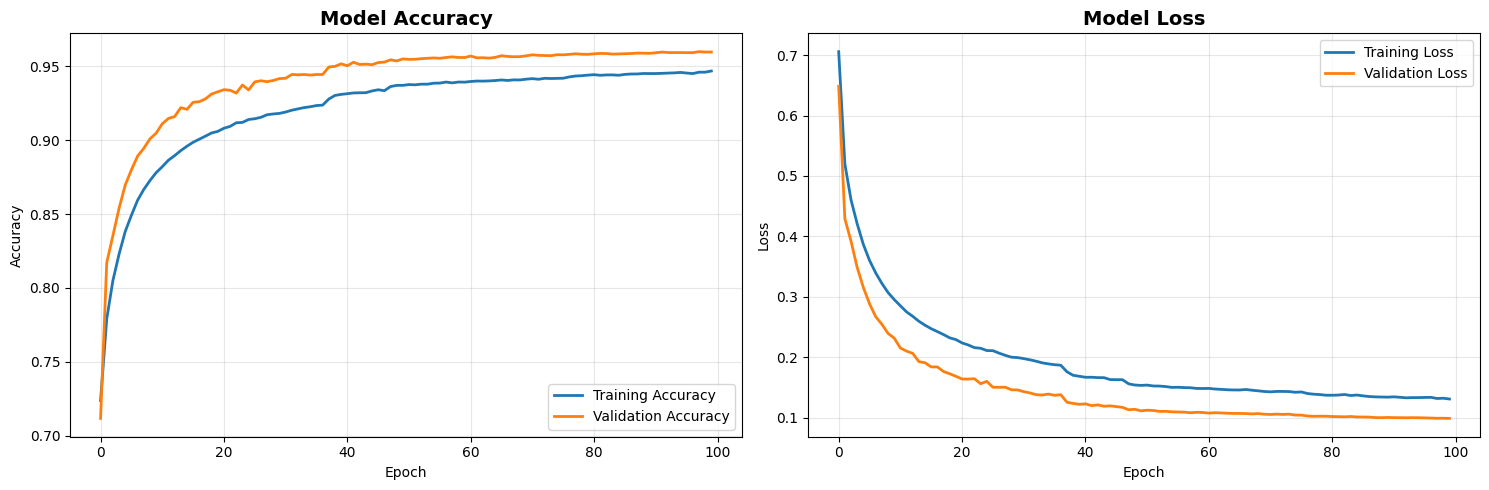

✓ Training history saved


In [9]:
import matplotlib.pyplot as plt

print("\nPlotting training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'nn_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved")

## 10. Evaluate on Test Set

In [10]:
print("\nEvaluating on test set...")

loss, acc = model.evaluate(
    [X_cont_test, X_wild_test, X_soil_test],
    y_test_cat,
    verbose=1
)

print("\n" + "=" * 80)
print(f"★ FINAL TEST ACCURACY: {acc*100:.2f}%")
print(f"★ FINAL TEST LOSS: {loss:.4f}")
print("=" * 80)


Evaluating on test set...
   1/2724 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.8750 - loss: 0.2600

  31/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9671 - loss: 0.1000  

  64/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9653 - loss: 0.0966

  93/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9636 - loss: 0.0977

 126/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9624 - loss: 0.0990

 158/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9614 - loss: 0.1002

 191/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1010

 225/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9602 - loss: 0.1013

 260/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9598 - loss: 0.1015

 296/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9597 - loss: 0.1015

 332/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9596 - loss: 0.1016

 366/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9594 - loss: 0.1017

 400/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9593 - loss: 0.1017

 433/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1017

 468/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1017

 504/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1016

 539/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1014

 572/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1013

 602/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1013

 634/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1013

 668/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1013

 702/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1012

 736/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9592 - loss: 0.1012

 770/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.1012

 804/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.1012

 839/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.1012

 873/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.1011

 907/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.1011

 941/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1011

 976/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1011

1010/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1011

1045/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1010

1080/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1010

1115/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1009

1151/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1009

1185/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1009

1219/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1009

1254/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9590 - loss: 0.1009

1288/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9590 - loss: 0.1009

1322/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9590 - loss: 0.1009

1356/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1390/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1426/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1460/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1494/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1528/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9590 - loss: 0.1008

1563/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1008

1597/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1008

1632/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1668/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1703/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1737/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1771/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1807/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1843/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1007

1879/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

1913/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

1947/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

1981/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2014/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2049/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2083/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2119/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2152/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2187/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1006

2221/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2255/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2290/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2326/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2361/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2396/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2431/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2465/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2501/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2537/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2573/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2608/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2642/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2676/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2711/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9591 - loss: 0.1005

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9591 - loss: 0.1005



★ FINAL TEST ACCURACY: 95.88%
★ FINAL TEST LOSS: 0.1008


## 11. Detailed Performance Analysis

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_probs = model.predict([X_cont_test, X_wild_test, X_soil_test])
y_pred = np.argmax(y_pred_probs, axis=1) + 1
y_true = np.argmax(y_test_cat, axis=1) + 1

print("\nDetailed Classification Report:")
print("=" * 80)
print(classification_report(y_true, y_pred, digits=4))

   1/2724 ━━━━━━━━━━━━━━━━━━━━ 9:41 214ms/step

  29/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step    

  61/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

  91/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 121/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 150/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 178/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 204/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 233/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 264/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 293/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 322/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 351/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 381/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 410/2724 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

 440/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 472/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 502/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 530/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 560/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 590/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 621/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 652/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 682/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 711/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 740/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 769/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 799/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 830/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 860/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 888/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 918/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 947/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

 977/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

1007/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1038/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1069/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1097/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1126/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1156/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1187/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1218/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1249/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1277/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1307/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1336/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1366/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1395/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1424/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1455/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1484/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1513/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1543/2724 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1574/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1603/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1634/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1664/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1693/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1723/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1753/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1785/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1817/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1847/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1876/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1905/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1934/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1964/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

1993/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2023/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2053/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2082/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2111/2724 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

2141/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2171/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2201/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2232/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2262/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2292/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2322/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2354/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2385/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2416/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2447/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2477/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2507/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2536/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2565/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2591/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2621/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2650/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2680/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2710/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step



Detailed Classification Report:
              precision    recall  f1-score   support

           1     0.9605    0.9528    0.9566     31776
           2     0.9636    0.9657    0.9647     42495
           3     0.9648    0.9571    0.9610      5363
           4     0.8771    0.9005    0.8886       412
           5     0.8519    0.9213    0.8853      1424
           6     0.9307    0.9378    0.9342      2605
           7     0.9524    0.9698    0.9610      3077

    accuracy                         0.9588     87152
   macro avg     0.9287    0.9436    0.9359     87152
weighted avg     0.9589    0.9588    0.9588     87152



## 12. Confusion Matrix


Creating confusion matrix...


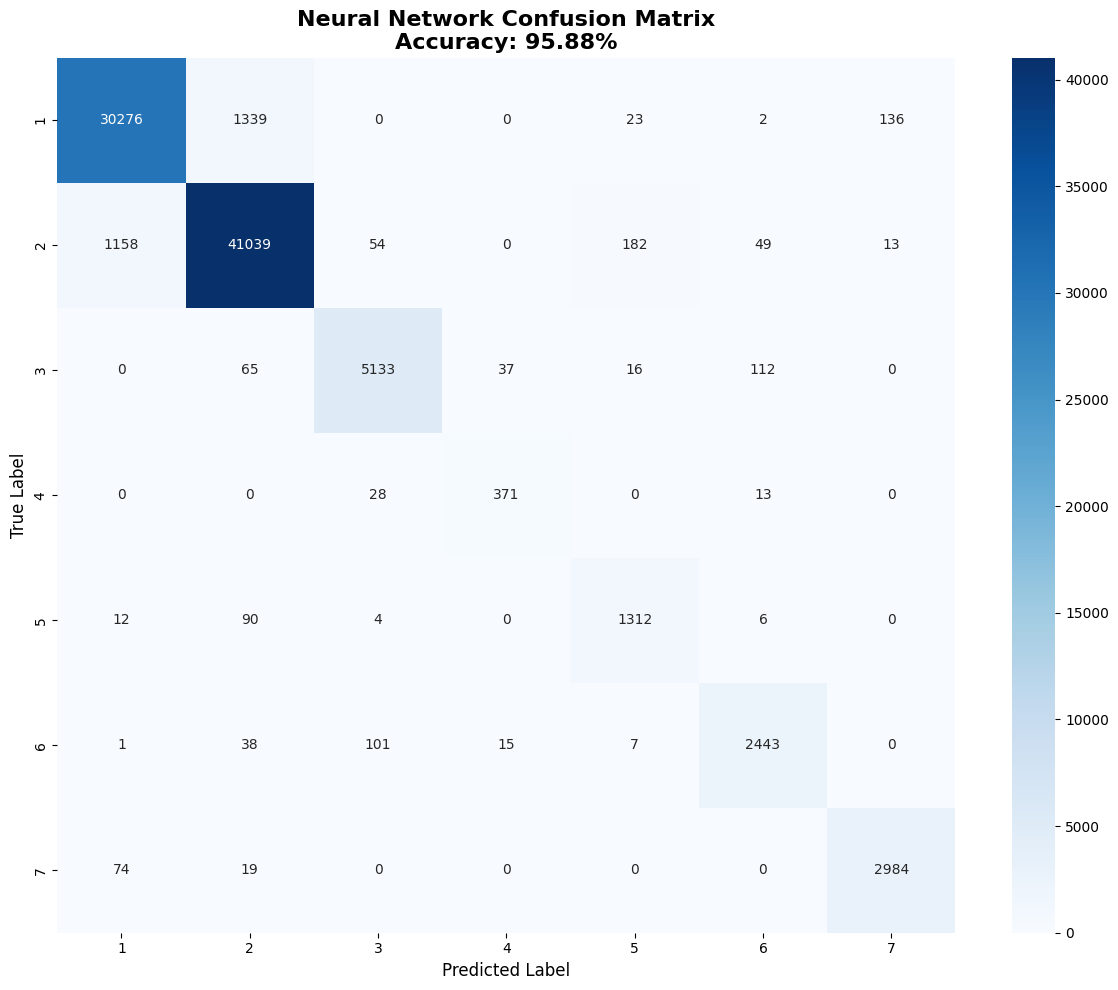

✓ Confusion matrix saved


In [12]:
print("\nCreating confusion matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(1, 8),
    yticklabels=range(1, 8)
)
plt.title(
    f'Neural Network Confusion Matrix\nAccuracy: {acc*100:.2f}%',
    fontsize=16,
    fontweight='bold'
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'nn_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

## 13. Save Model

In [13]:
model_path = os.path.join(base_dir, 'neural_network_model.keras')
model.save(model_path)
print(f"✓ Full model saved to: {model_path}")

✓ Full model saved to: C:\PYTHON\AIT511 Course Project 2\archive\neural_network_model.keras


## 14. Summary

In [14]:
print("\n" + "=" * 80)
print("NEURAL NETWORK TRAINING COMPLETE")
print("=" * 80)
print(f"✓ Model: Wide & Deep MLP")
print(f"✓ Architecture: [1024, 512, 512, 256]")
print(f"✓ Activation: Swish")
print(f"✓ Test accuracy: {acc*100:.2f}%")
print(f"✓ Test loss: {loss:.4f}")
print(f"✓ Training samples: {X_cont_train.shape[0]:,}")
print(f"✓ Test samples: {X_cont_test.shape[0]:,}")
print(f"✓ Features: {X_cont_train.shape[1]} continuous + 2 categorical")
print(f"\nOptimizations Applied:")
print(f"  - Mixed precision training (FP16)")
print(f"  - XLA JIT compilation")
print(f"  - Batch normalization")
print(f"  - Dropout regularization")
print(f"  - Learning rate scheduling")
print(f"  - Early stopping")
print(f"\nFiles saved:")
print(f"  - Model: {model_path}")
print(f"  - Best weights: best_95_v2_model.weights.h5")
print(f"  - Training history: nn_training_history.png")
print(f"  - Confusion matrix: nn_confusion_matrix.png")

if acc >= 0.95:
    print(f"\n🎉 TARGET ACHIEVED: {acc*100:.2f}% >= 95%")
else:
    print(f"\n📊 Current accuracy: {acc*100:.2f}% (target: 95%)")
    print("Consider further hyperparameter tuning or feature engineering.")


NEURAL NETWORK TRAINING COMPLETE
✓ Model: Wide & Deep MLP
✓ Architecture: [1024, 512, 512, 256]
✓ Activation: Swish
✓ Test accuracy: 95.88%
✓ Test loss: 0.1008
✓ Training samples: 493,860
✓ Test samples: 87,152
✓ Features: 32 continuous + 2 categorical

Optimizations Applied:
  - Mixed precision training (FP16)
  - XLA JIT compilation
  - Batch normalization
  - Dropout regularization
  - Learning rate scheduling
  - Early stopping

Files saved:
  - Model: C:\PYTHON\AIT511 Course Project 2\archive\neural_network_model.keras
  - Best weights: best_95_v2_model.weights.h5
  - Training history: nn_training_history.png
  - Confusion matrix: nn_confusion_matrix.png

🎉 TARGET ACHIEVED: 95.88% >= 95%
